In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Tuple
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')
gif_dir = os.path.join(os.path.dirname(os.getcwd()), 'gif')


plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

class ToggleSwitch(nn.Module):
    def __init__(self, 
                 sample_theta: bool = True,
                 return_dic: bool = False) -> None:
        super().__init__()
        self.param_range = (torch.tensor([0.01, 0.01, 0.01, 0.01, 250.0, 0.01, 0.01]),
                           torch.tensor([50.0, 50.0, 5.0, 5.0, 450.0, 0.5, 0.4]))
        
        self.initial_state = torch.Tensor([10.0, 10.0])
        self.thete_default = torch.tensor([22.0, 12.0, 4.0, 4.5, 325.0, 0.25, 0.15])
        self.param_dim = 7
        self.sample_theta = sample_theta
        self.return_dic = return_dic

    def prior(self, n: int) -> Tensor:
        if not self.sample_theta:
            return self.thete_default.unsqueeze(0).repeat(n, 1) # [n, param_dim = 7]

        lower, upper = self.param_range
        theta = lower + (upper - lower) * torch.rand((n, self.param_dim)) 
            
        return theta # [n, param_dim = 7]
    
    def noise_generator(self, n: int, m: int = 1, T: int = 300) -> Tensor:
        """
        Obtain noise for simulators
        """

        U = torch.distributions.uniform.Uniform(0, 1)
        noise_1 = U.sample((n, m, T, 2))
        noise_2 = U.sample((n, m, 1))
              
        return [noise_1, noise_2]

    def simulator(self, theta: Tensor, noises: list[Tensor]) -> Tensor:
        """
        theta: [n, param_dim = 7]
        noise: list of Tensors containing noise for simulators
        """
        noise_1, noise_2 = noises
        n, m, T, _ = noise_1.shape
        
        alpha_1 = theta[:, 0].unsqueeze(-1).repeat(1, m) # [n, m]
        alpha_2 = theta[:, 1].unsqueeze(-1).repeat(1, m)
        beta_1 = theta[:, 2].unsqueeze(-1).repeat(1, m)
        beta_2 = theta[:, 3].unsqueeze(-1).repeat(1, m)
        mu = theta[:, 4].unsqueeze(-1).repeat(1, m)
        sigma = theta[:, 5].unsqueeze(-1).repeat(1, m)
        gamma = theta[:, 6].unsqueeze(-1).repeat(1, m)

        initial_state = torch.Tensor([10.0, 10.0])

        kappa_1 = kappa_2 = 1.0; delta_1 = delta_2 = 0.03

        def step_function(state: list, noise_u: Tensor, noise_v: Tensor) -> list[Tensor]:
            """
            state: list with length 2. Each element is a tensor of shape [n, m]
            noise_u: noise for each time step with shape [n, m]
            """
            noise_u = noise_u.unsqueeze(-1) if noise_u.dim() == 1 else noise_u
            noise_v = noise_v.unsqueeze(-1) if noise_v.dim() == 1 else noise_v

            u_t, v_t = state[0], state[1]
            u_mean = u_t + alpha_1 / (1 + v_t**beta_1) - (kappa_1 + delta_1 * u_t)
            u_next = _truncated_normal(noise = noise_u, loc = u_mean, std = torch.Tensor([0.5]))
            v_mean = v_t + alpha_2 / (1 + u_t**beta_2) - (kappa_2 + delta_2 * v_t)
            v_next = _truncated_normal(noise = noise_v, loc = v_mean, std = torch.Tensor([0.5]))

            return [u_next, v_next]

        state = [initial_state[0].repeat(n, m), initial_state[1].repeat(n, m)]

        u_list = []
        for t in range(T):
            state = step_function(state, noise_u = noise_1[:, :, t, 0].squeeze(-1), noise_v = noise_1[:, :, t, 1].squeeze(-1))
            u_list.append(state[0])

        final_state = state
        u_T, v_T = final_state[0], final_state[1]
        x = _truncated_normal(
            loc = mu + u_T,
            std = mu * sigma / (u_T ** gamma),
            noise = noise_2.squeeze(-1)
            )
      
        x = x.nan_to_num(0)
        x = torch.clamp(x, max = 2000)

        u = torch.stack(u_list, dim=-1)
      
        return x, u # [n, m]
    
    def forward(self, 
                theta: Tensor = None, 
                noises: Tensor = None, 
                n: int = 1, 
                T: int = 300, 
                m: int = 1) -> Tuple[Tensor, Tensor]:
        
        if theta is None:
            theta = self.prior(n) # [n, param_dim = 7]

        if noises is None:
            noises = self.noise_generator(n, m, T)
    
        x, u  = self.simulator(theta, noises) # [n, m]
        
        return theta, x, u

def _truncated_normal(noise: Tensor, loc: Tensor, std: Tensor) -> Tensor:
  """
  Obtain samples from truncated normal distribution given randam variable u ~ U(0, 1)
  See wikipedia https://en.wikipedia.org/wiki/Truncated_normal_distribution
  """
  a = 0
  Phi_a = torch.erf((a - loc) / std)
  x = torch.erfinv(Phi_a + noise * (1 - Phi_a)) * std + loc

  return x

In [27]:
n = 1
simulator = ToggleSwitch(sample_theta = False)
noises = simulator.noise_generator(n = n, m = 1, T = 300)
T_list = [50, 80, 300]
_, x_low, u_low = simulator(noises = [noises[0][:, :, 0:T_list[0], :], noises[1]], n = n, m = 1, T = T_list[0])
_, x_mid, u_mid = simulator(noises = [noises[0][:, :, 0:T_list[1], :], noises[1]], n = n, m = 1, T = T_list[1])
_, x_high, u_high = simulator(noises = [noises[0][:, :, 0:T_list[2], :], noises[1]], n = n, m = 1, T = T_list[2])

In [248]:
x_low.shape

torch.Size([1, 1])

In [281]:
torch.concat([u_low.squeeze(0), x_low], dim=1).numpy().T

array([[  9.030768 ],
       [  8.118593 ],
       [  6.726693 ],
       [  5.404185 ],
       [  3.72402  ],
       [  3.0267475],
       [  3.2066765],
       [ 11.429482 ],
       [ 32.87457  ],
       [ 52.340847 ],
       [ 71.3656   ],
       [ 89.49953  ],
       [108.21312  ],
       [125.41233  ],
       [141.06763  ],
       [157.28308  ],
       [174.10954  ],
       [190.17467  ],
       [205.27718  ],
       [219.8642   ],
       [234.45677  ],
       [248.95117  ],
       [262.51474  ],
       [275.1763   ],
       [287.3821   ],
       [299.63965  ],
       [309.68848  ],
       [321.6915   ],
       [333.3949   ],
       [344.56958  ],
       [355.28708  ],
       [365.63824  ],
       [375.52222  ],
       [386.18414  ],
       [396.19092  ],
       [406.05865  ],
       [415.0367   ],
       [423.39606  ],
       [431.2969   ],
       [437.92413  ],
       [445.64618  ],
       [453.42764  ],
       [460.49023  ],
       [467.34726  ],
       [474.34055  ],
       [48

In [284]:
u_low.squeeze(0).numpy().shape

(1, 50)

In [285]:
torch.concat([u_low.squeeze(0), x_low], dim=1).numpy().shape

(1, 51)

In [313]:
import matplotlib.pyplot as plt
import numpy as np

def plot_for_gif(T: int, t: int, ax: plt.Axes, show_x_label = False) -> plt.Axes:

    T_list = [50, 80, 300]
    T_index = T_list.index(T)

    colors =  ["#25A986", "#25A986", "#0C0C85"]
    trajectories = [u_low.squeeze(1).numpy(), u_mid.squeeze(1).numpy(), u_high.squeeze(1).numpy()]
    title = ["Low fidelity", "Low fidelity", "High fidelity"]

    if t > len(trajectories[T_index].T):
        t = len(trajectories[T_index].T)

    ax.set_xlim(0, 1)
    ax.set_ylim(np.min(trajectories[2].T - 10), np.max(trajectories[2].T + 10))
    ax.plot(np.linspace(0, 1, len(trajectories[T_index].T))[:t], trajectories[T_index].T[:t], color = colors[T_index], alpha = 0.5, linewidth = 4)
    ax.scatter(np.linspace(0, 1, len(trajectories[T_index].T))[:t], trajectories[T_index].T[:t], color = colors[T_index], marker = '.', s = 80)
    
    if show_x_label:
        ax.set_xlabel("$t$", fontsize = 20)

    else:
        ax.set_xticklabels([])

    ax.set_ylabel("$u_t$", fontsize = 20)

    # ax.set_ylabel("$x$", fontsize = 20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title[T_index], fontsize = 20)

    return ax

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_56325/4198737596.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


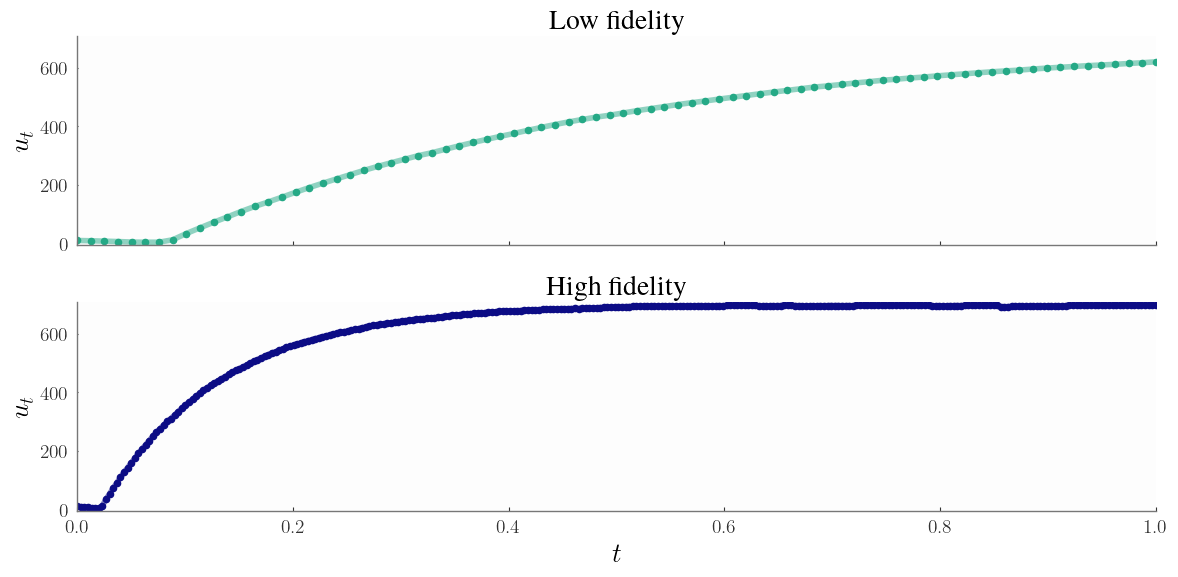

In [314]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_for_gif(T = 80, t = 80, ax = ax[0], show_x_label = False)
plot_for_gif(T = 300, t = 300, ax = ax[1], show_x_label = True)
fig.tight_layout()
fig.show()

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_56325/44677584.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(12, 6))


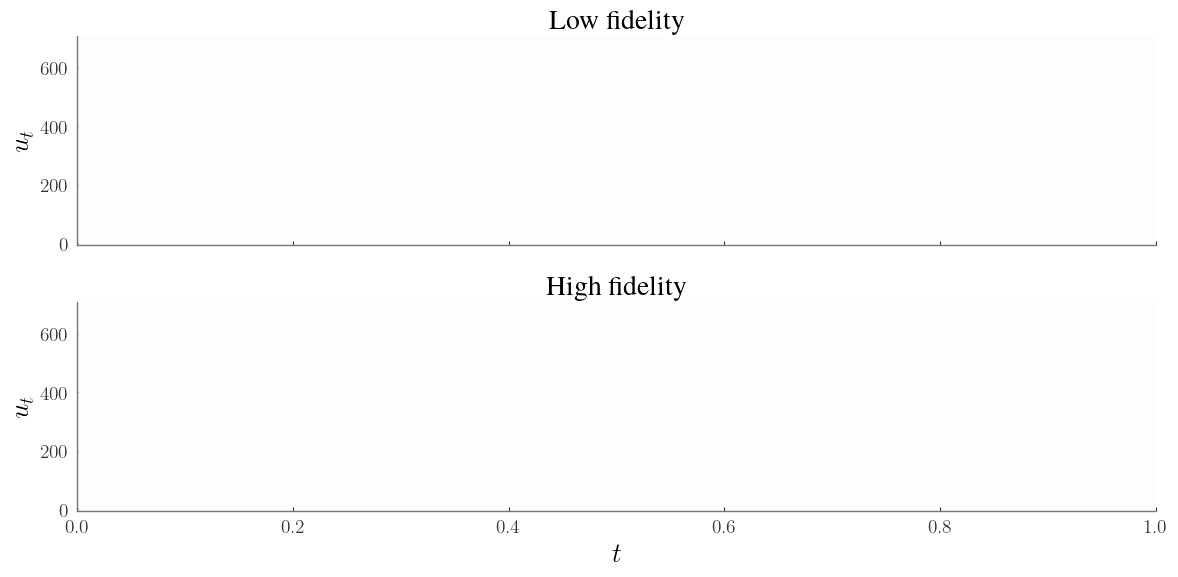

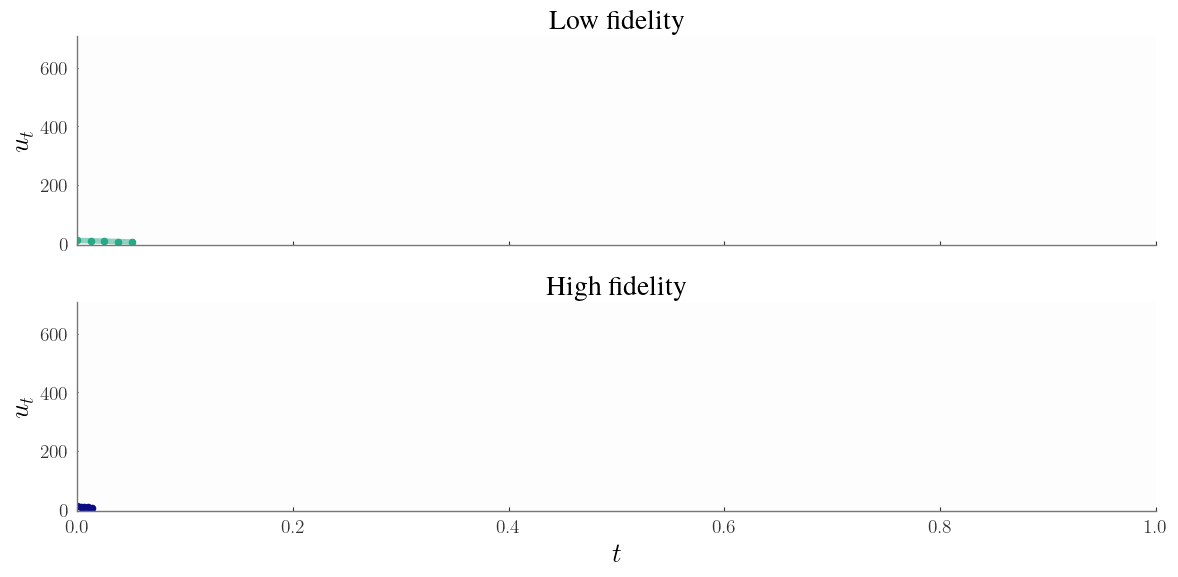

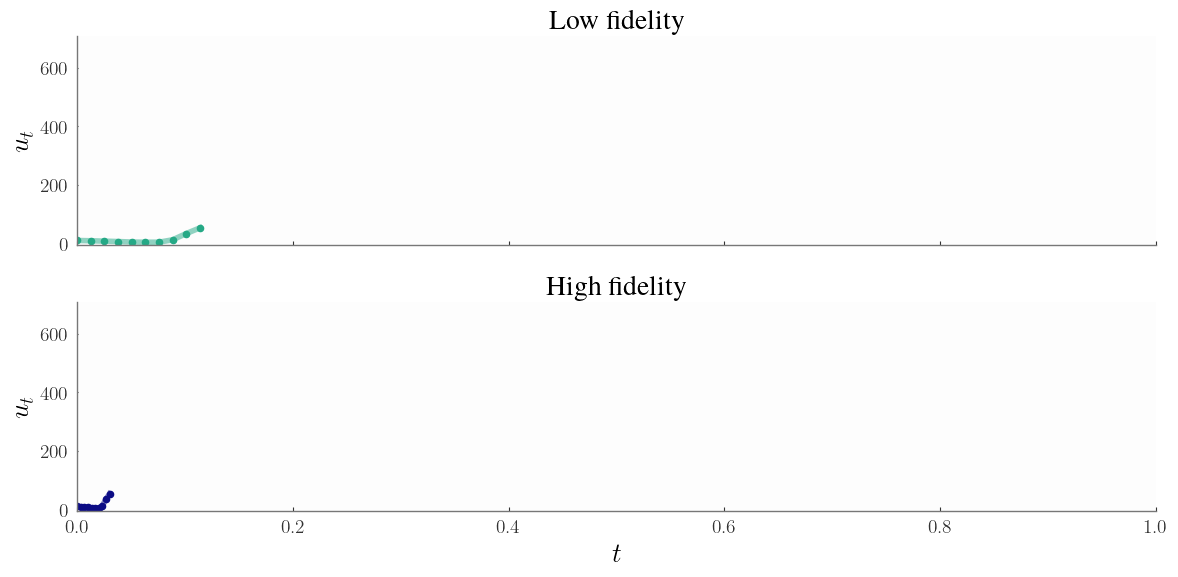

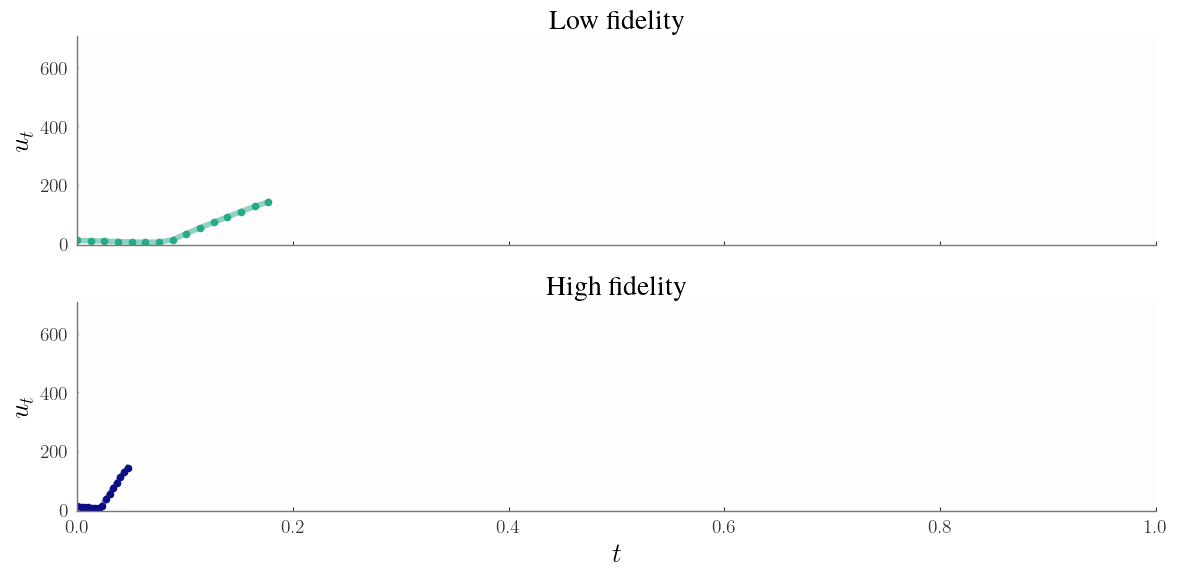

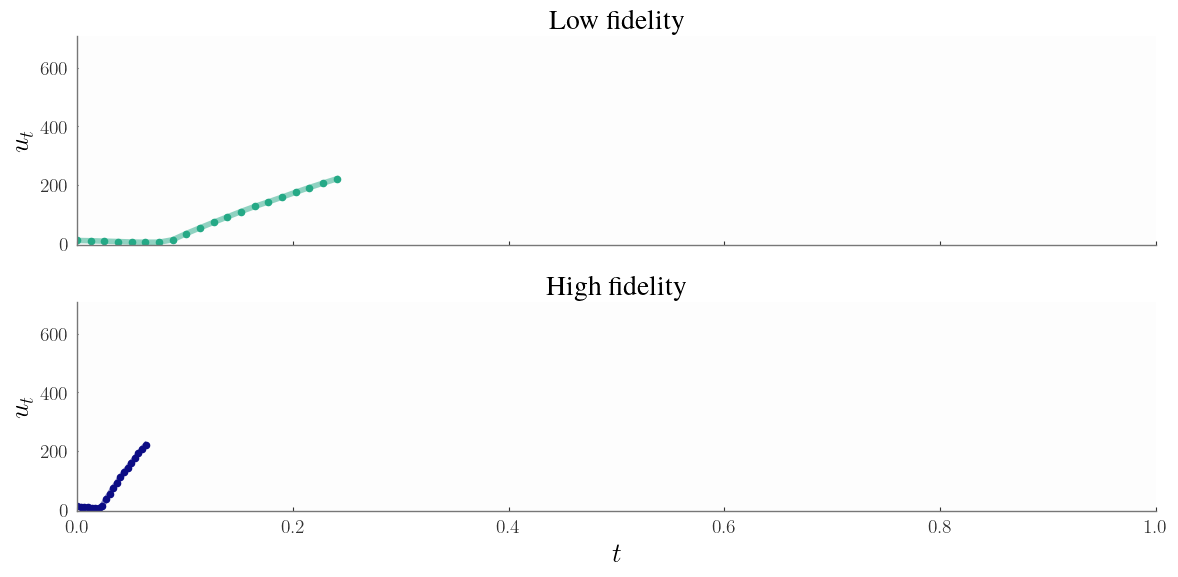

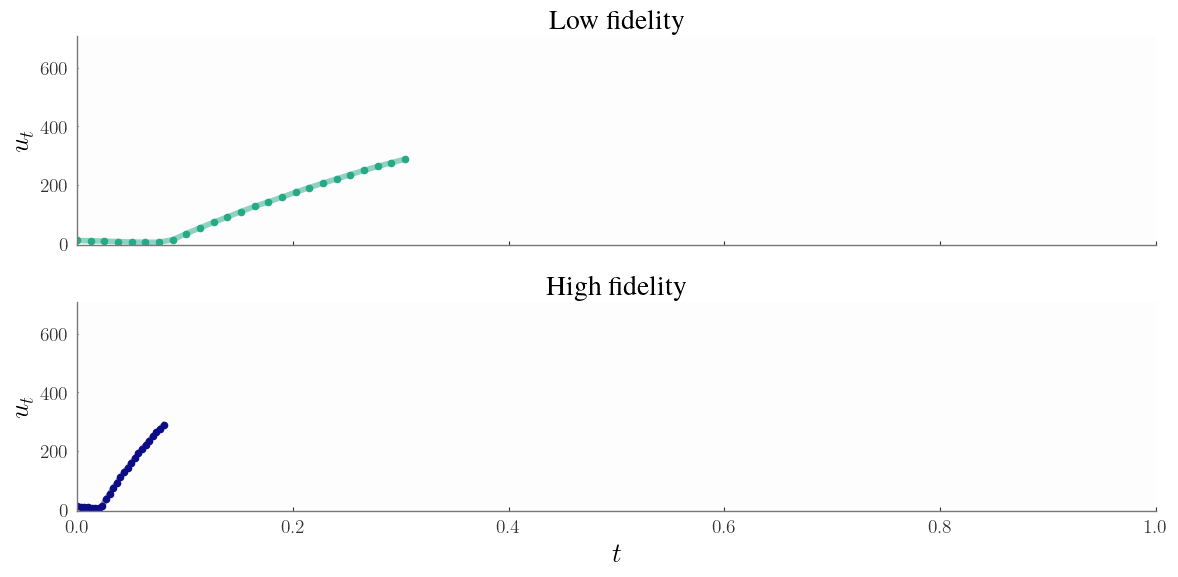

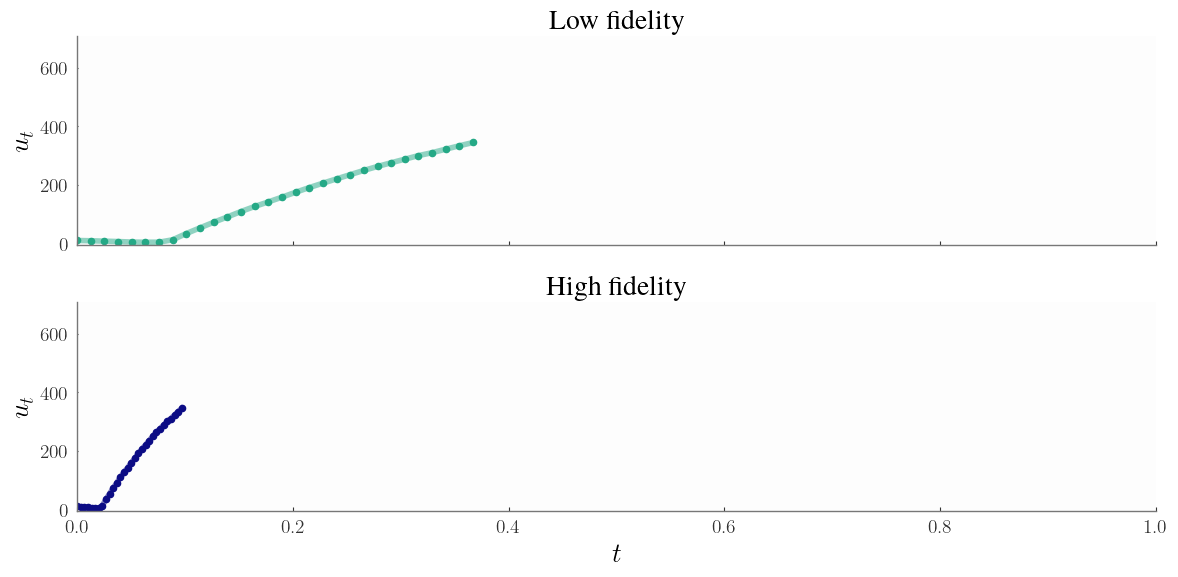

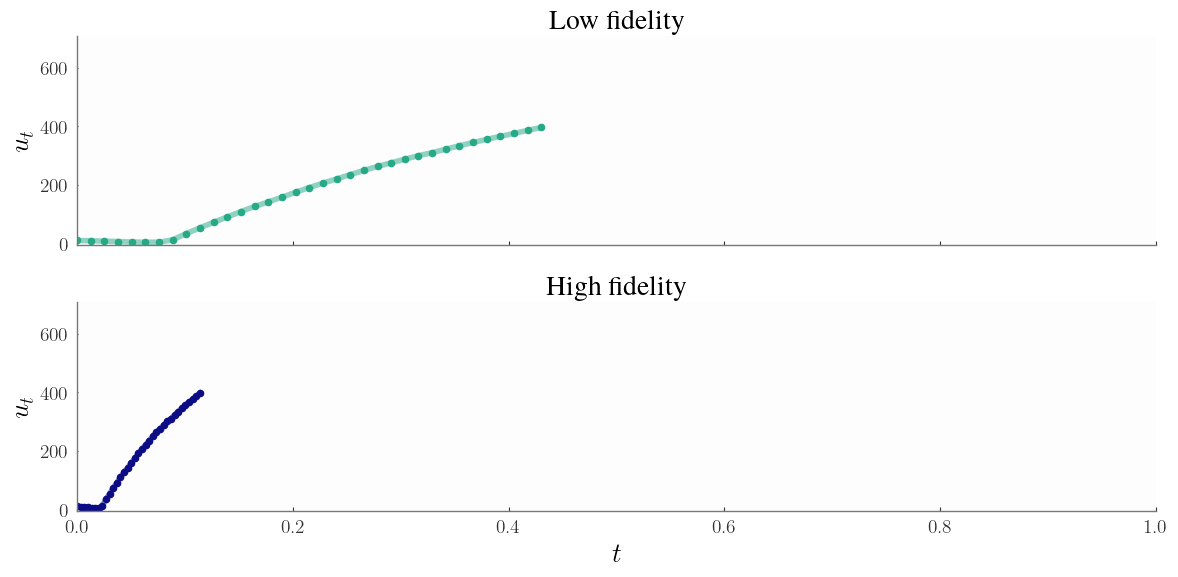

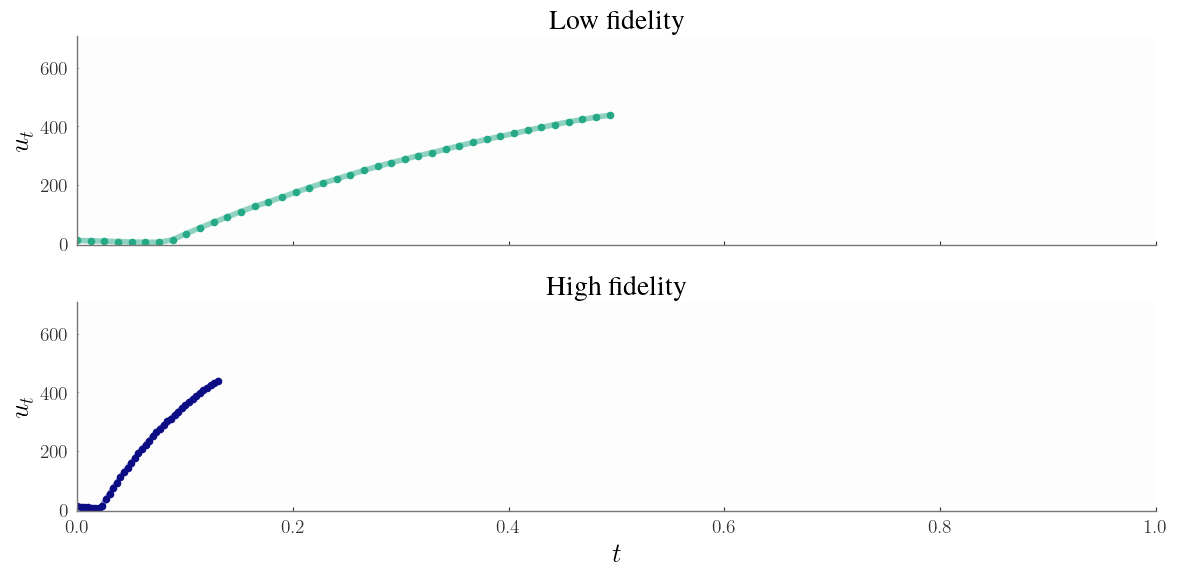

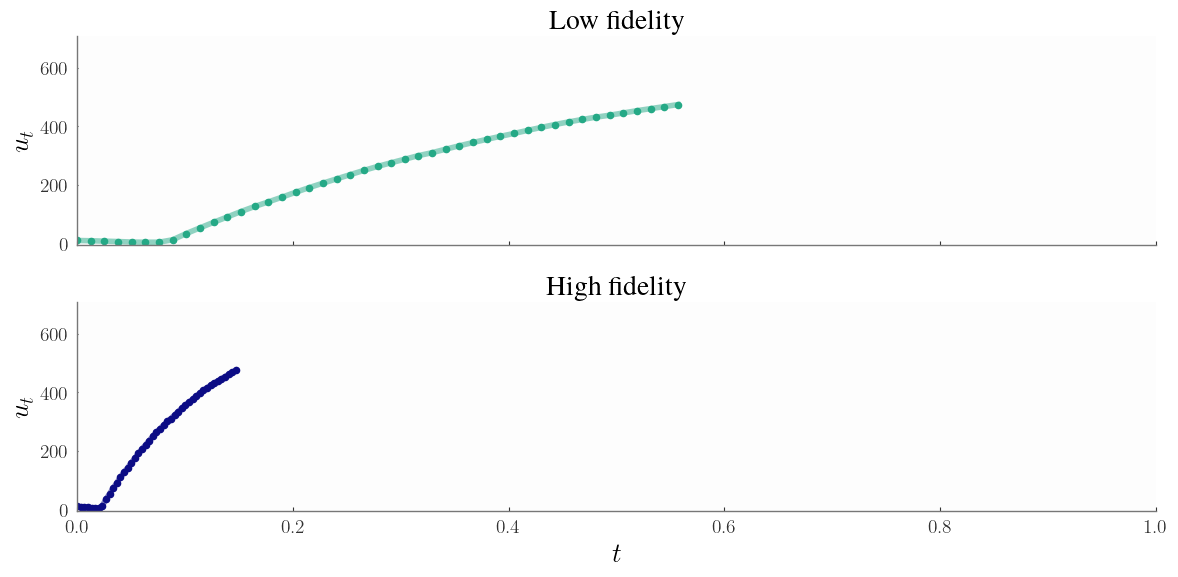

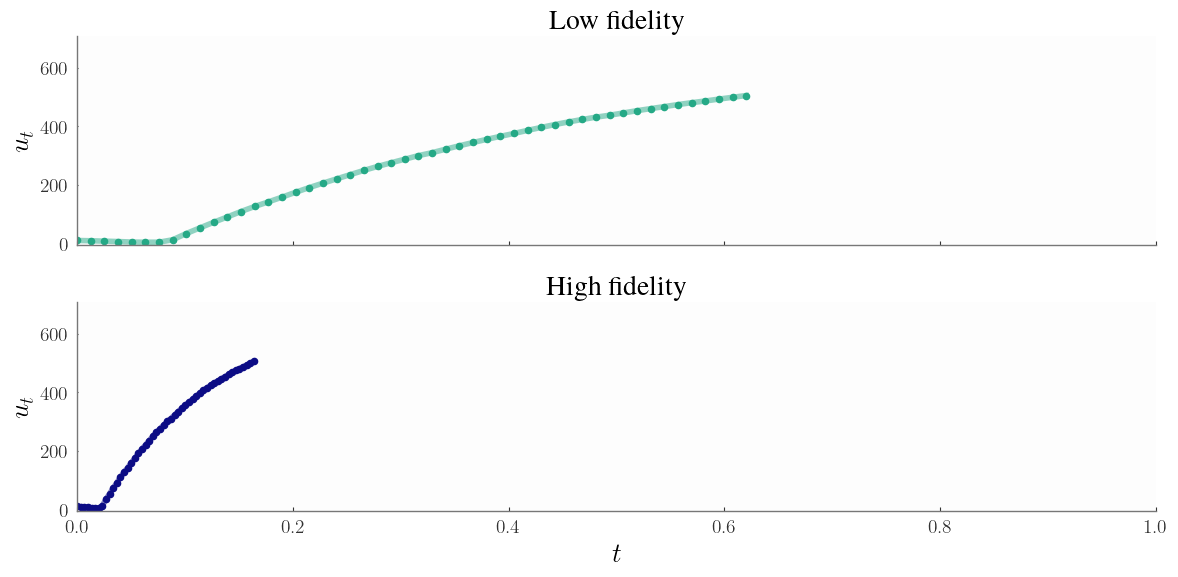

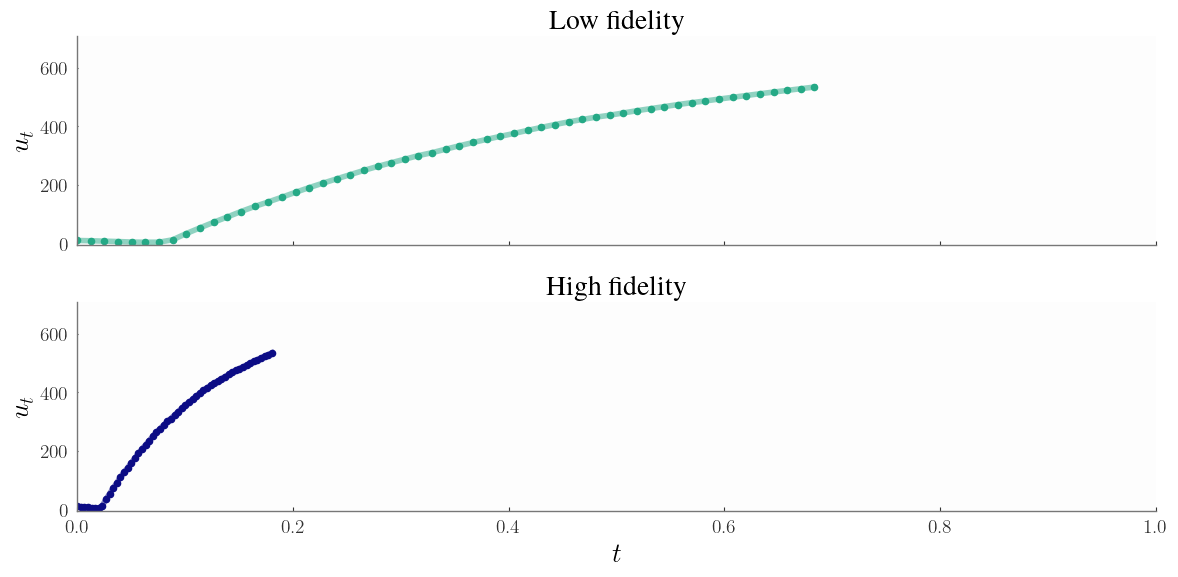

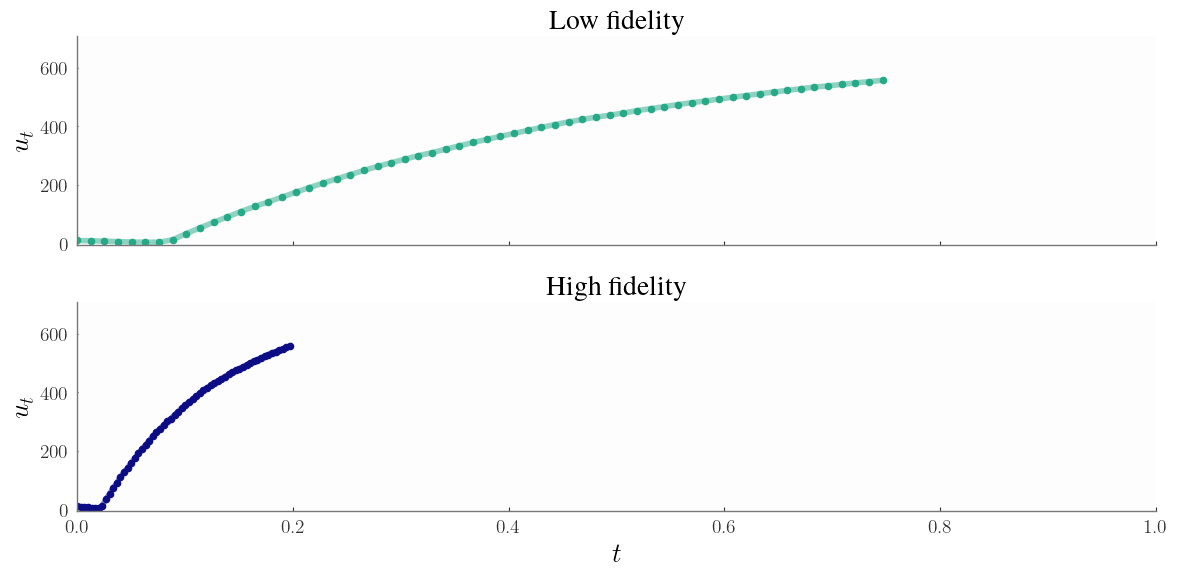

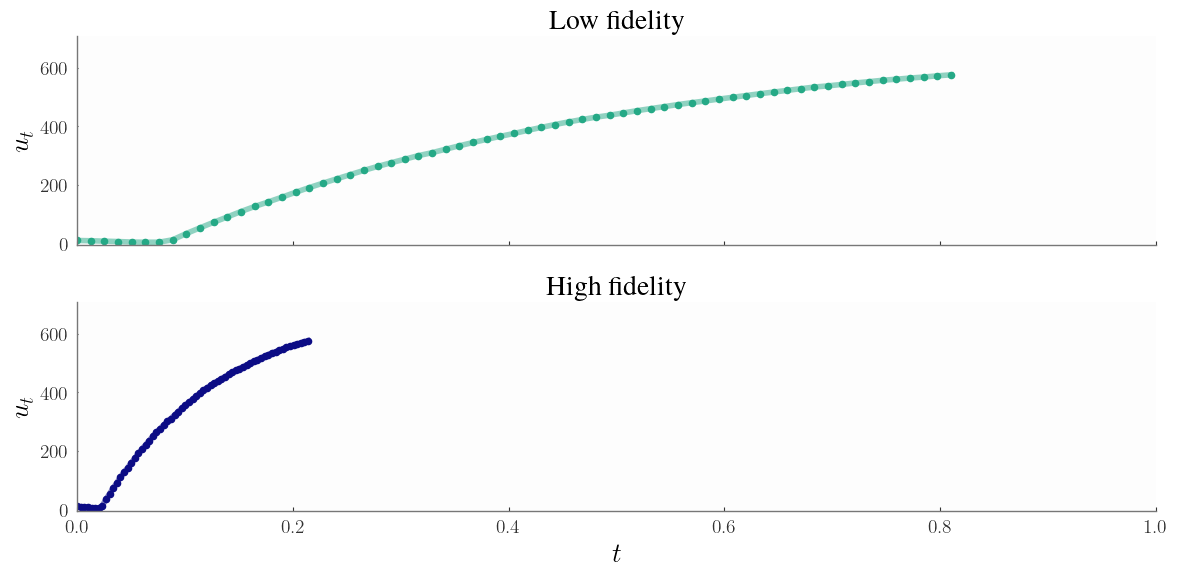

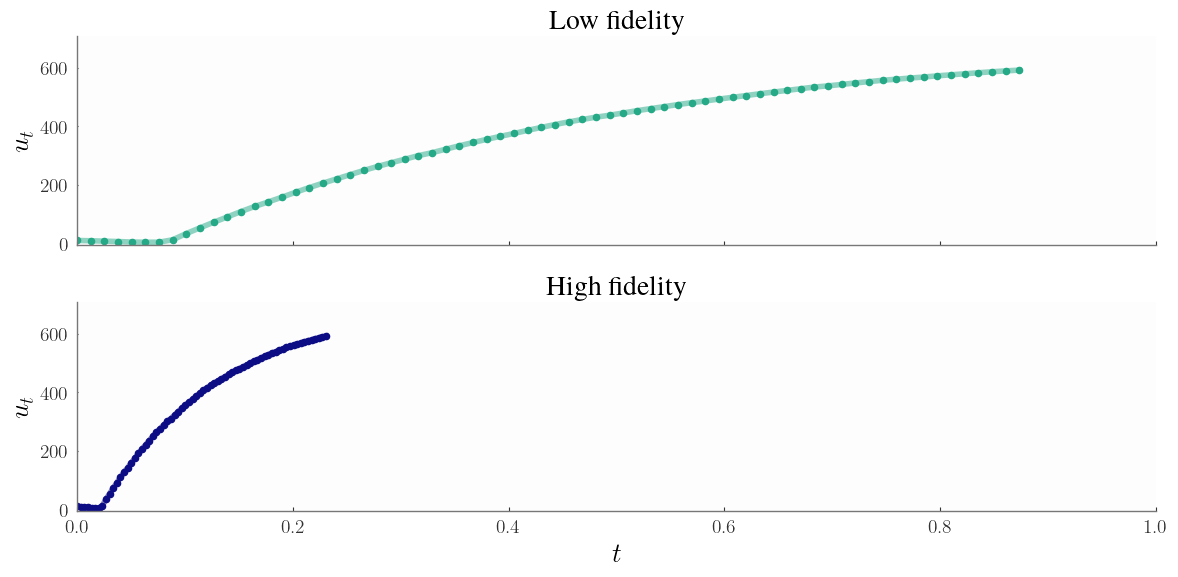

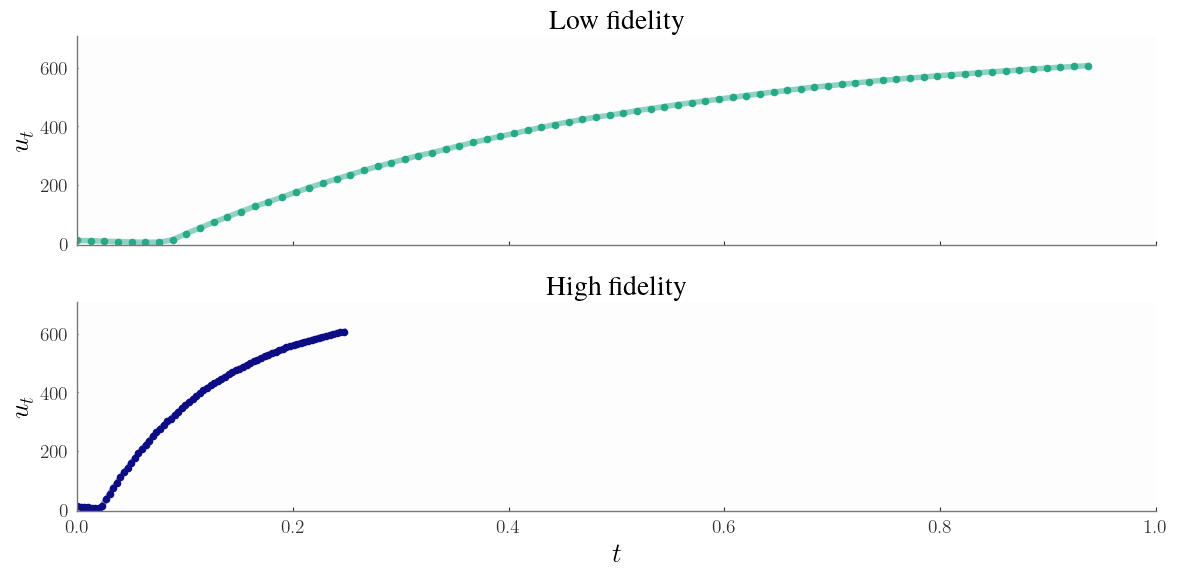

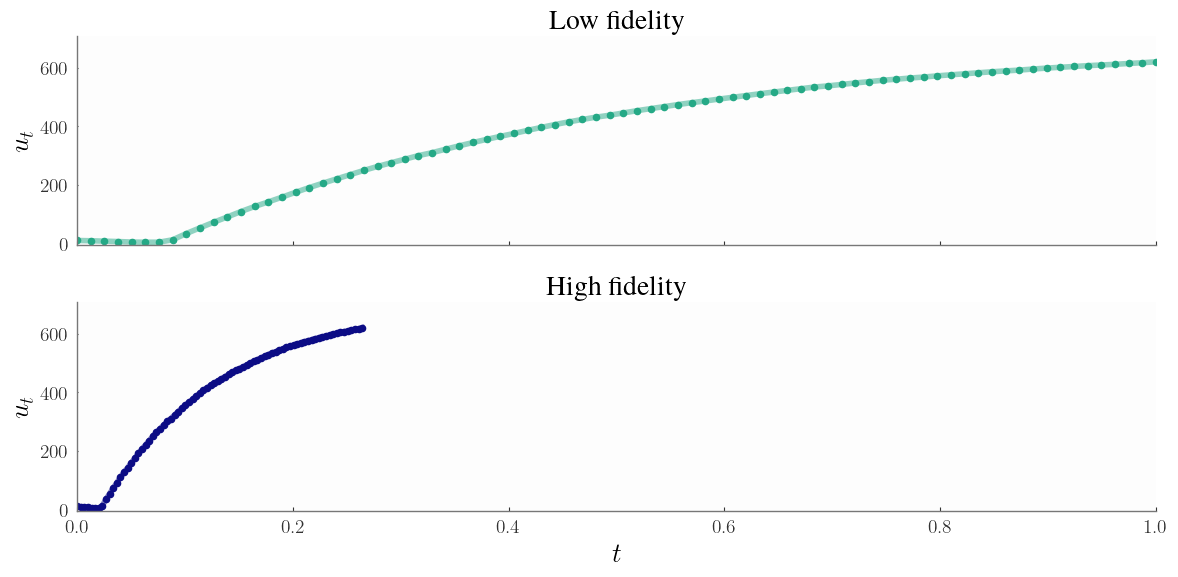

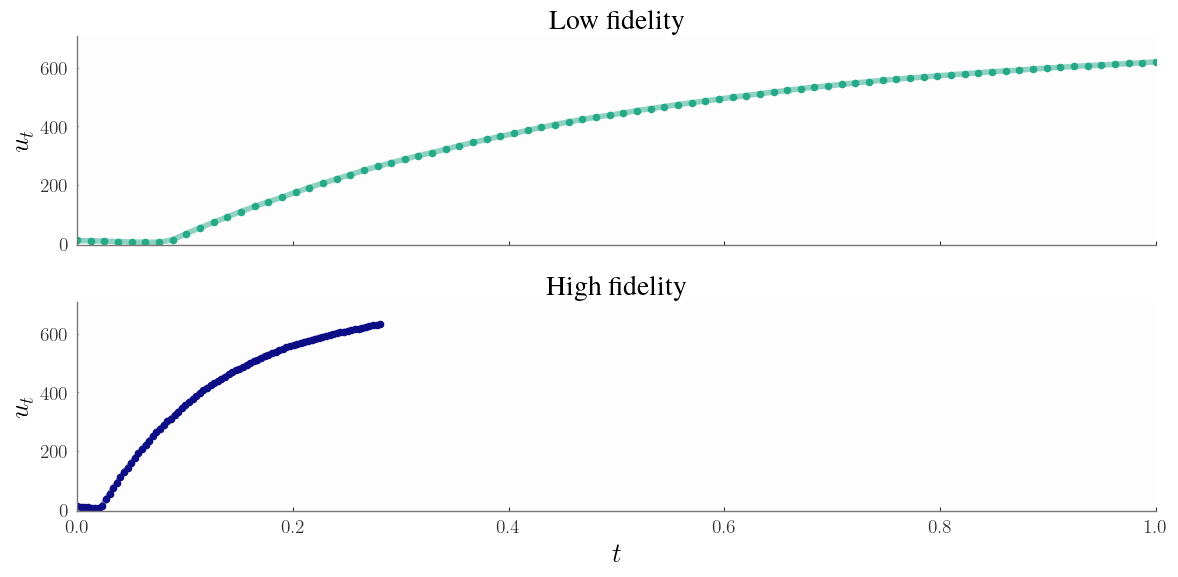

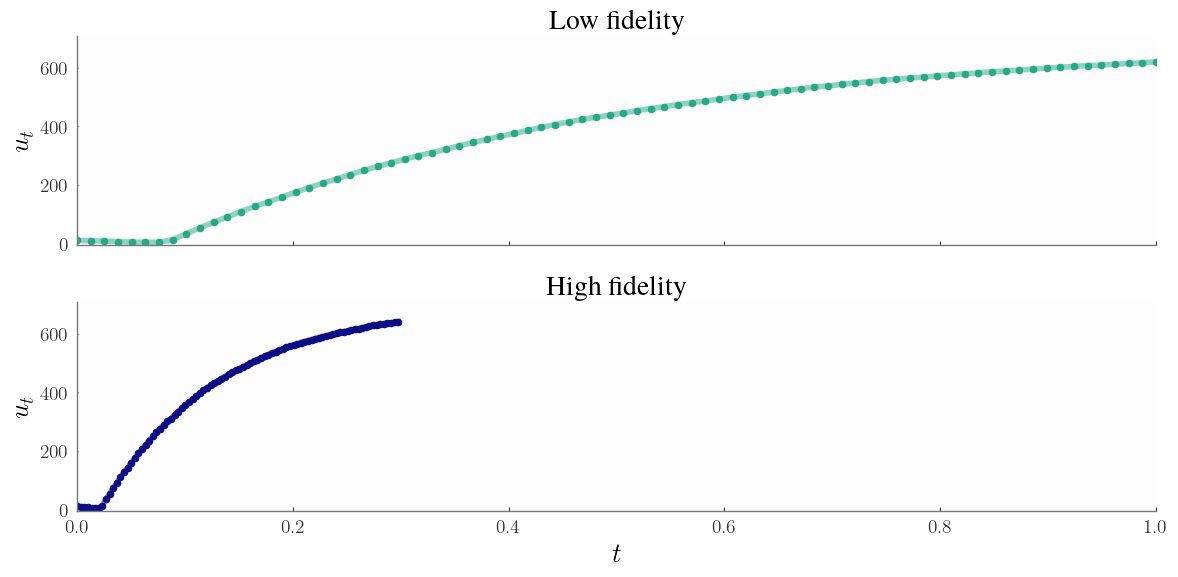

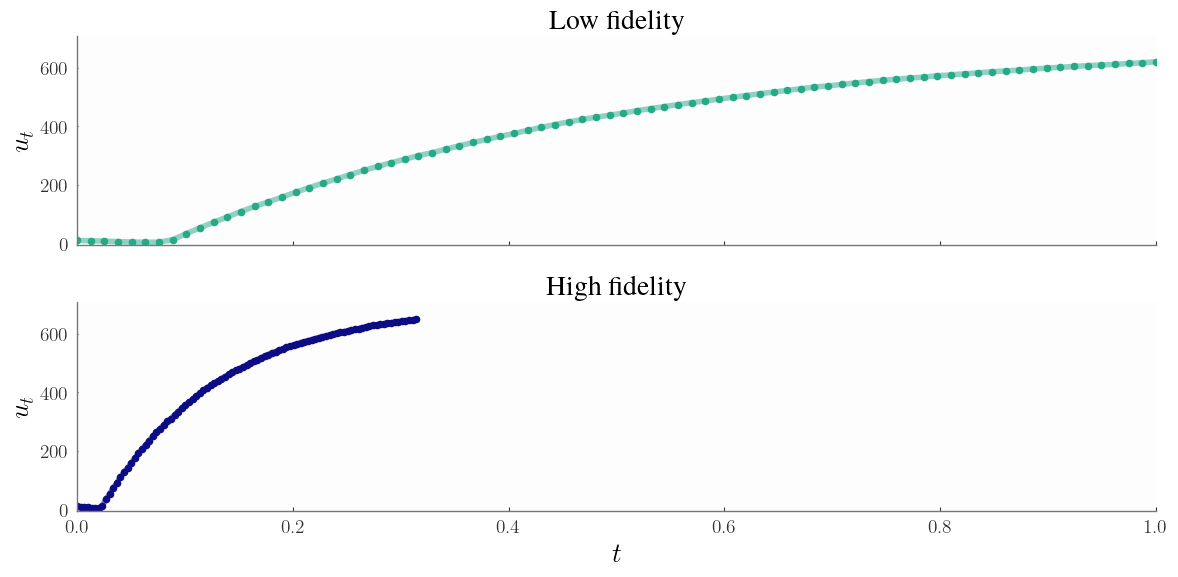

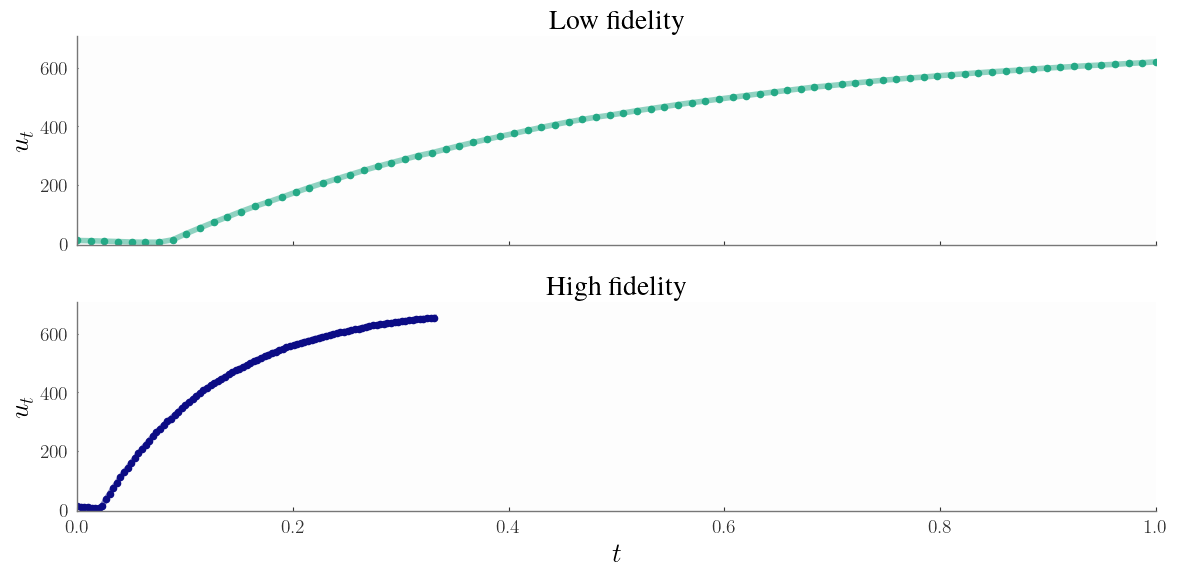

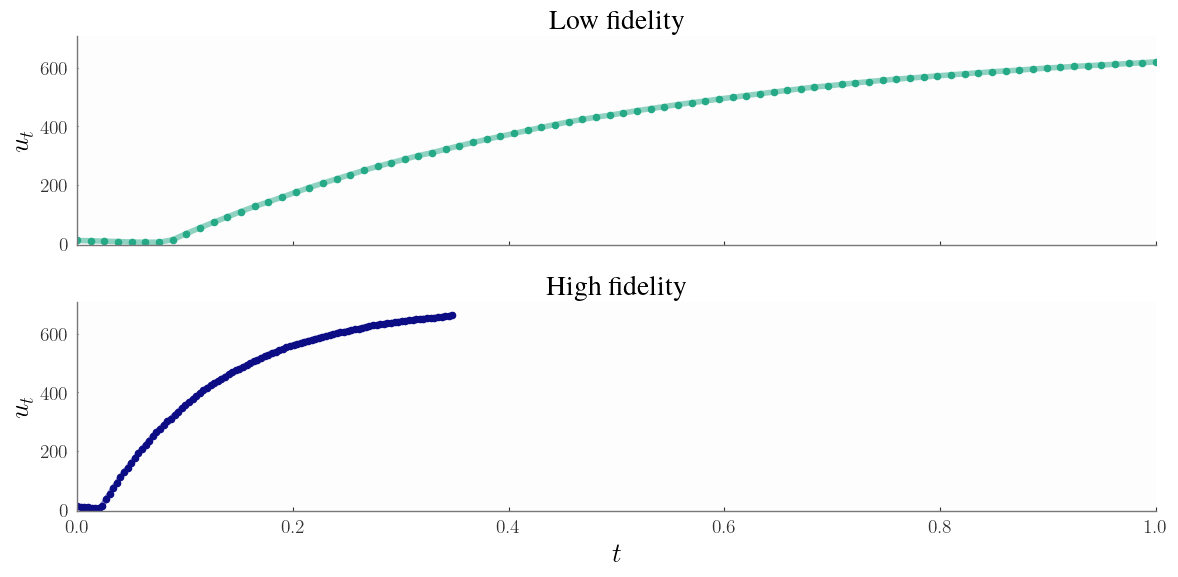

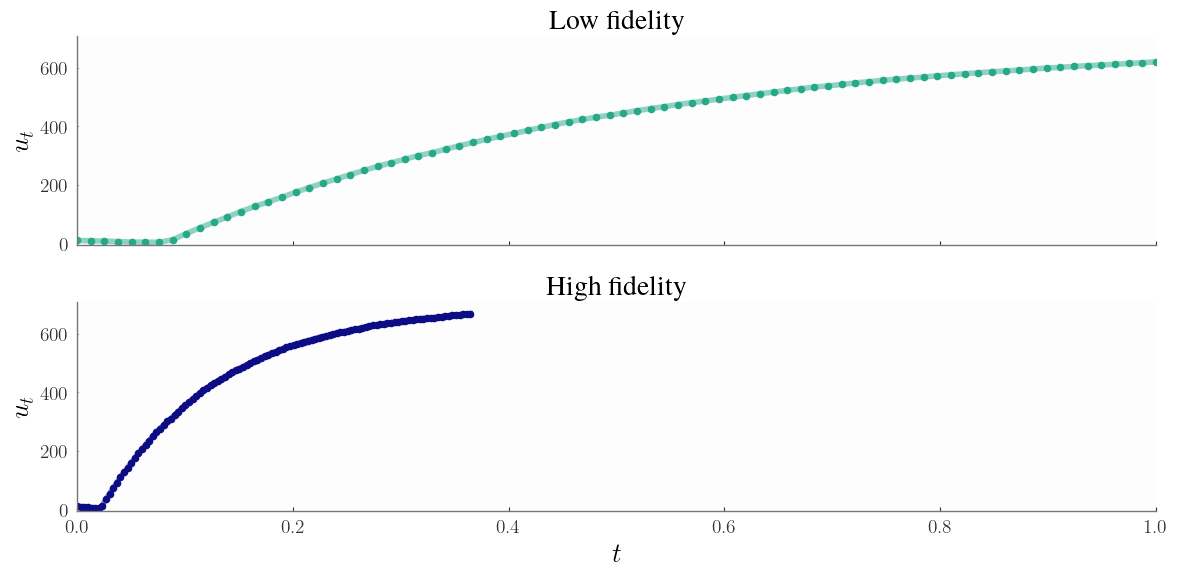

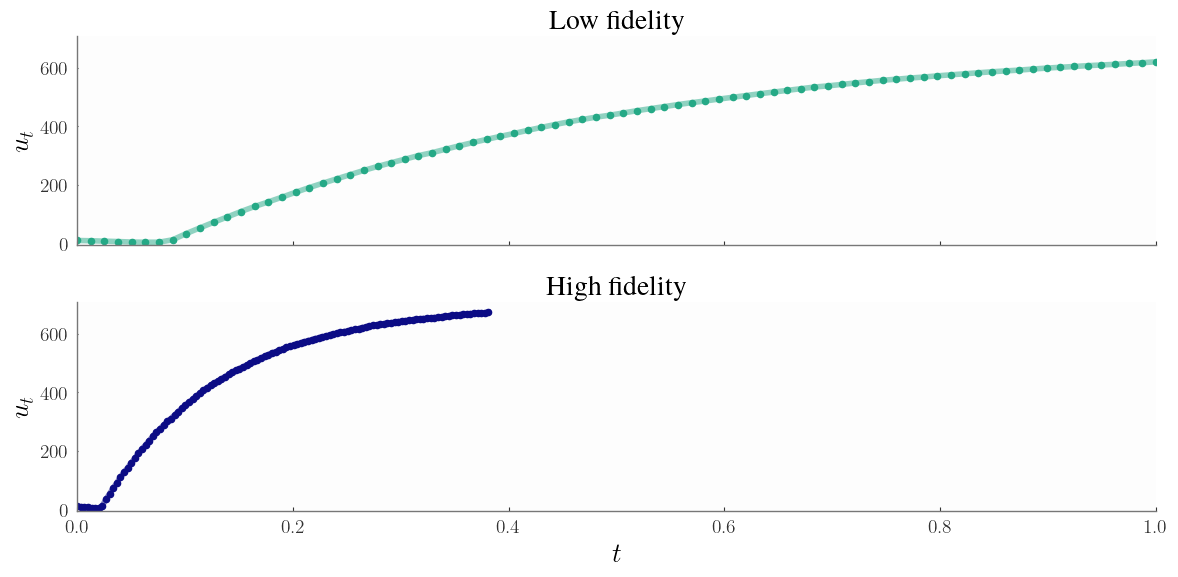

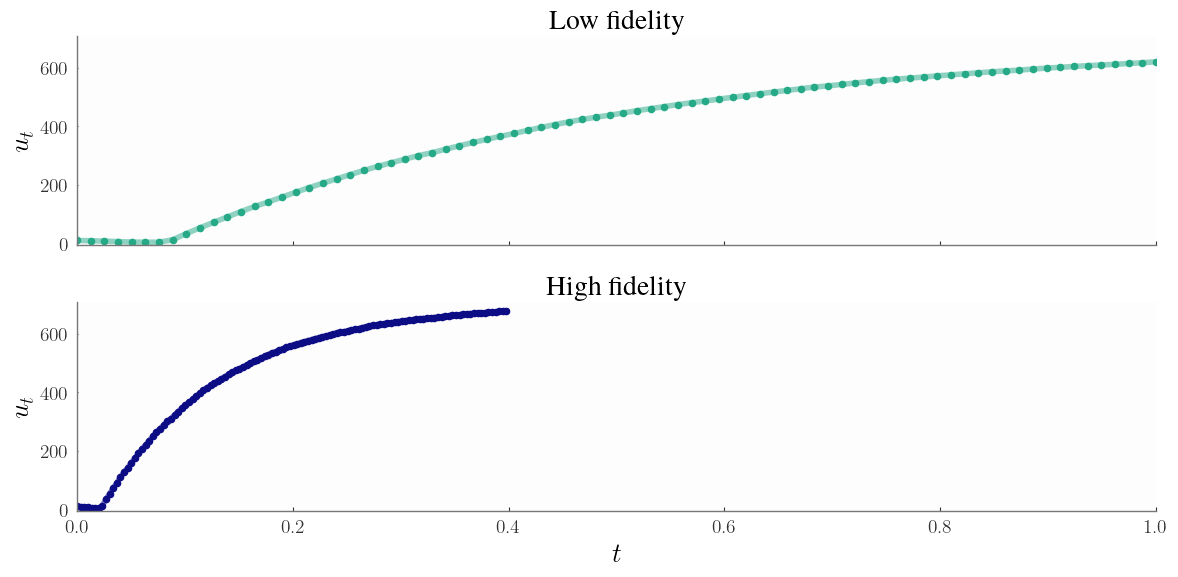

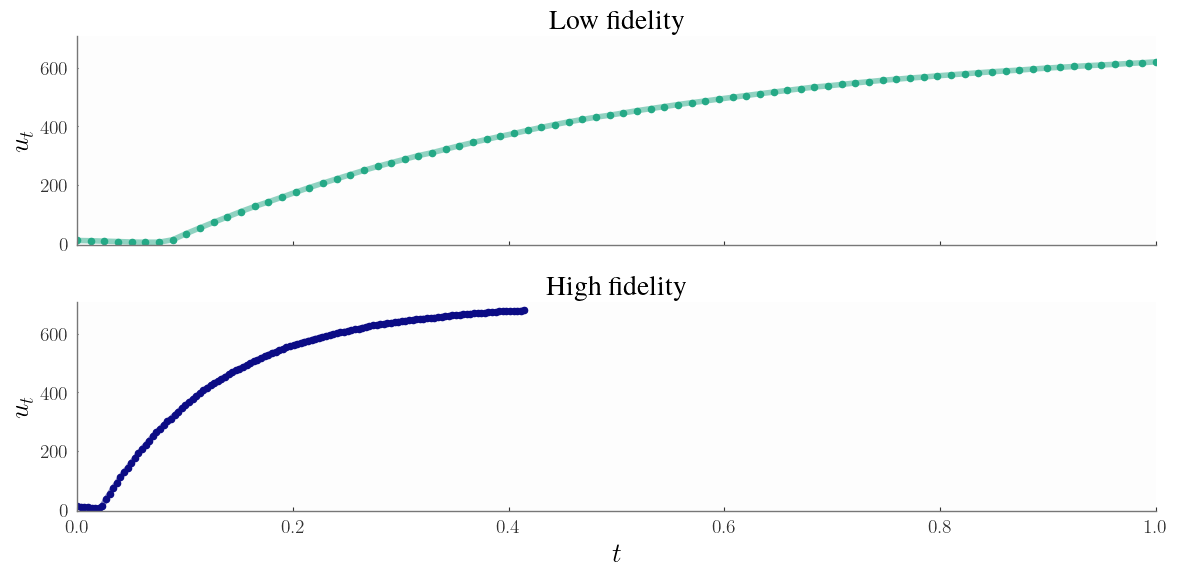

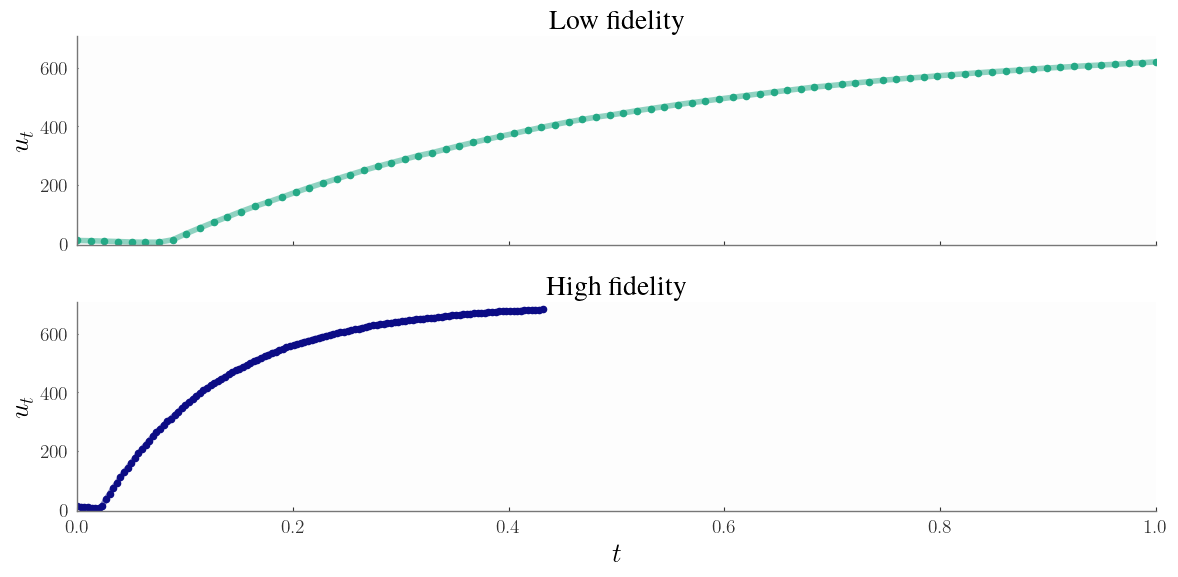

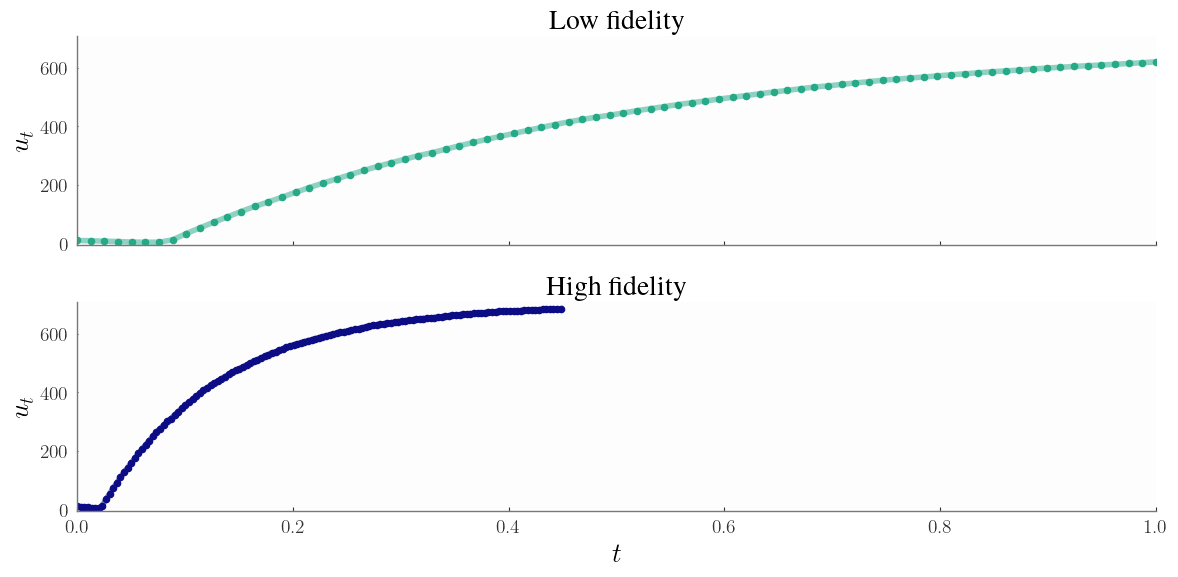

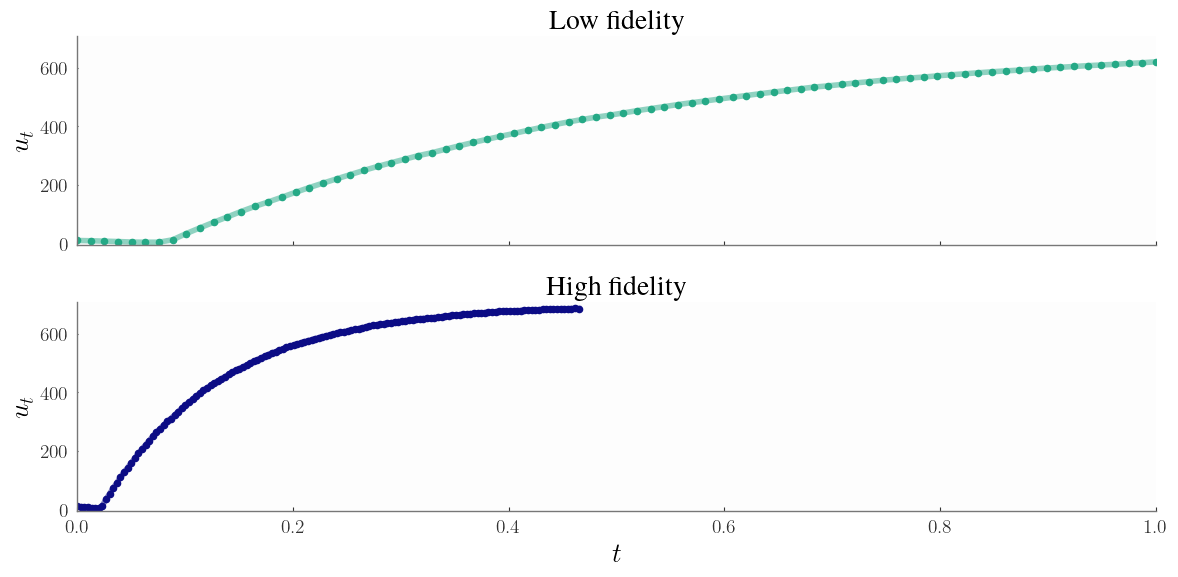

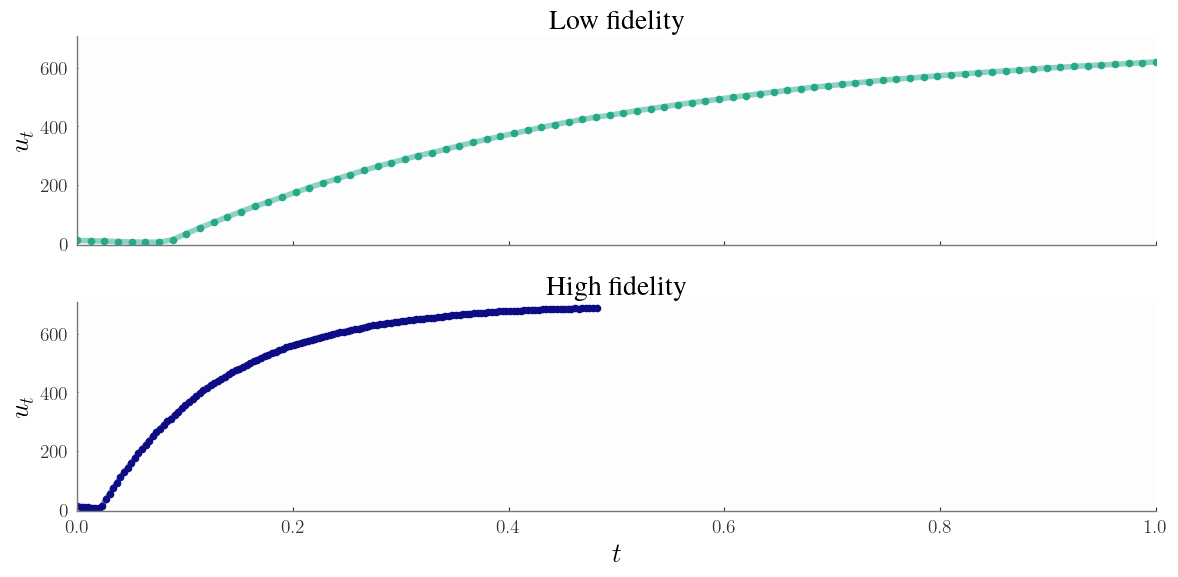

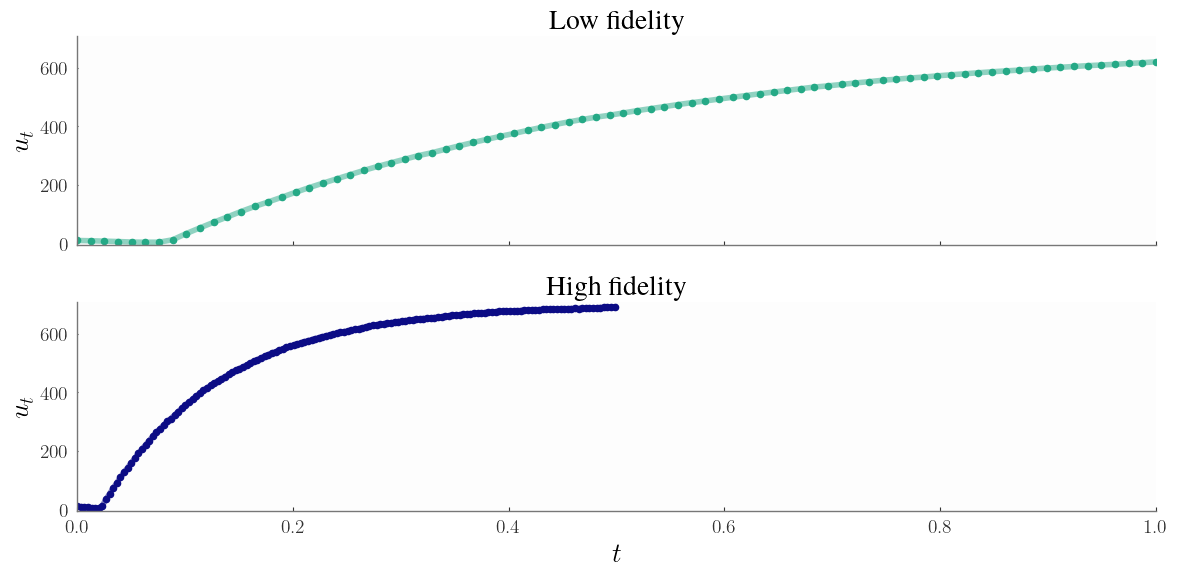

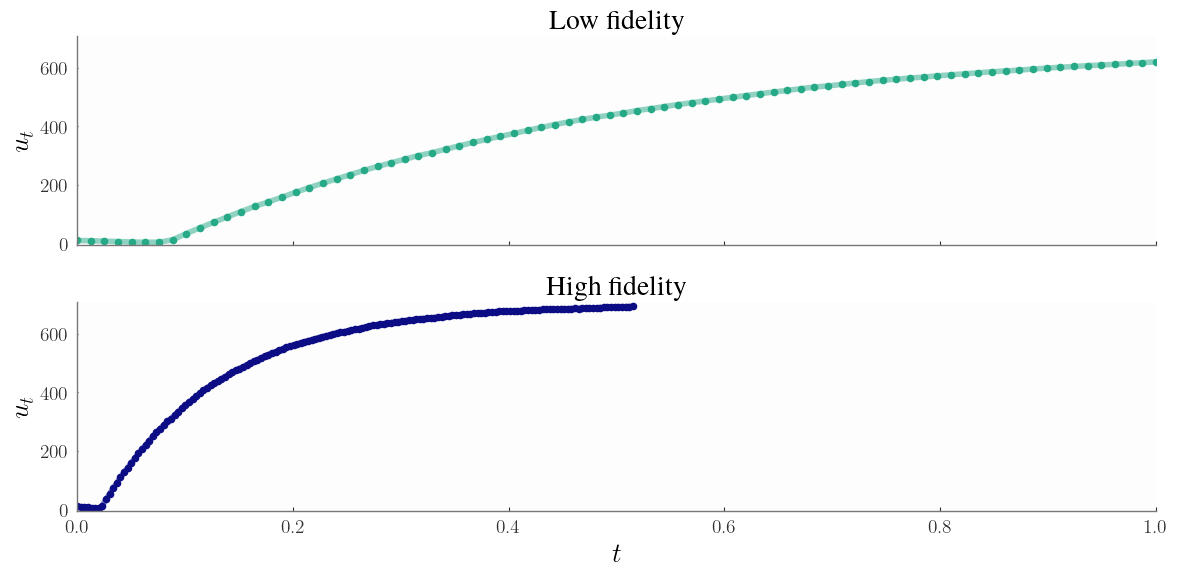

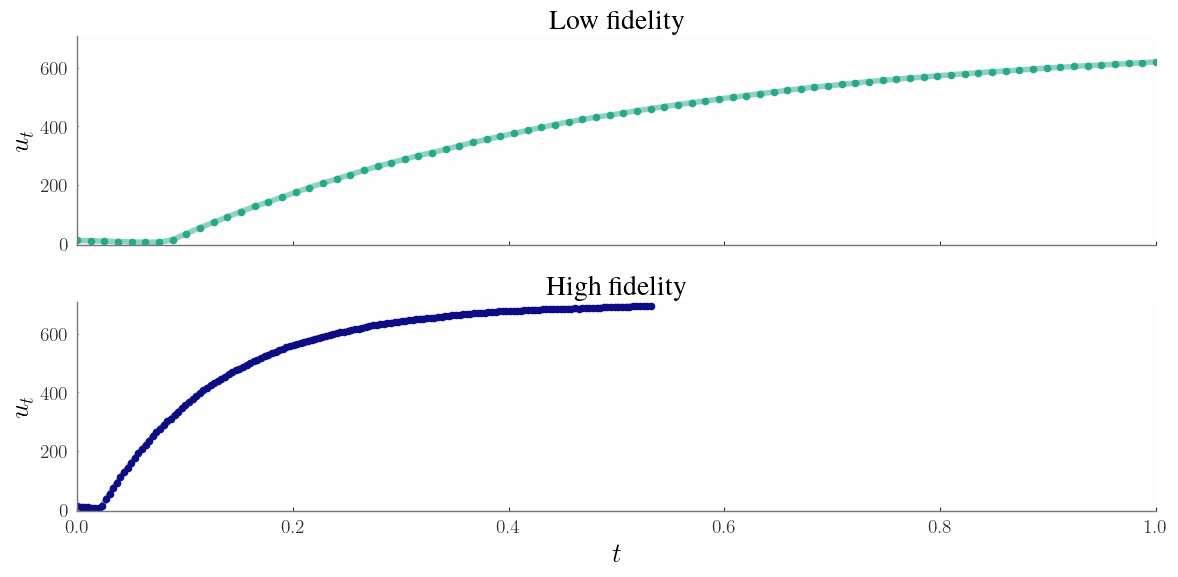

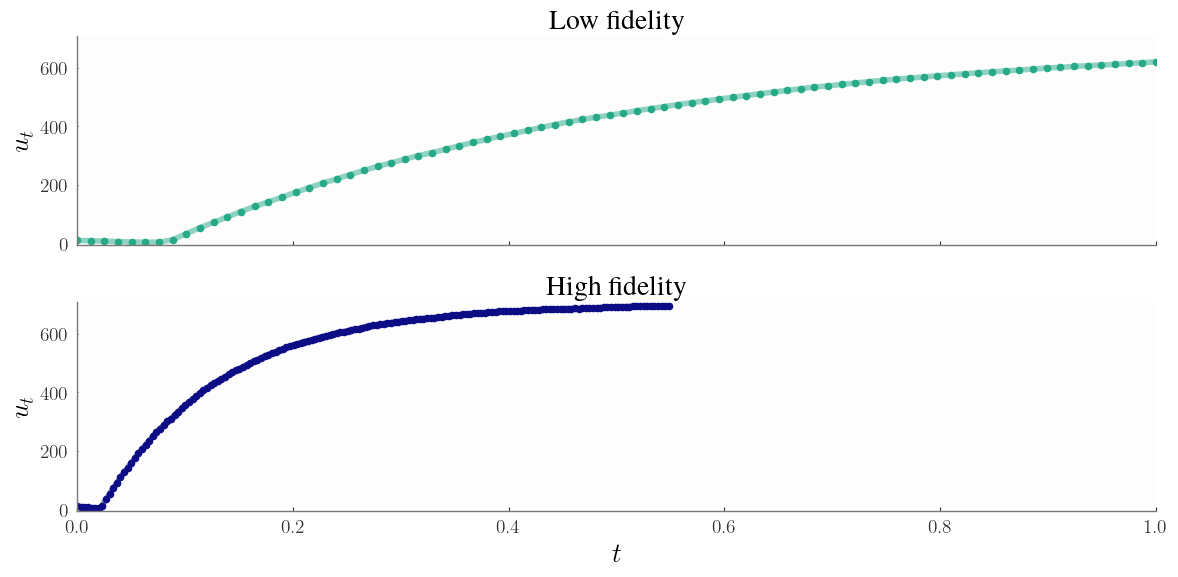

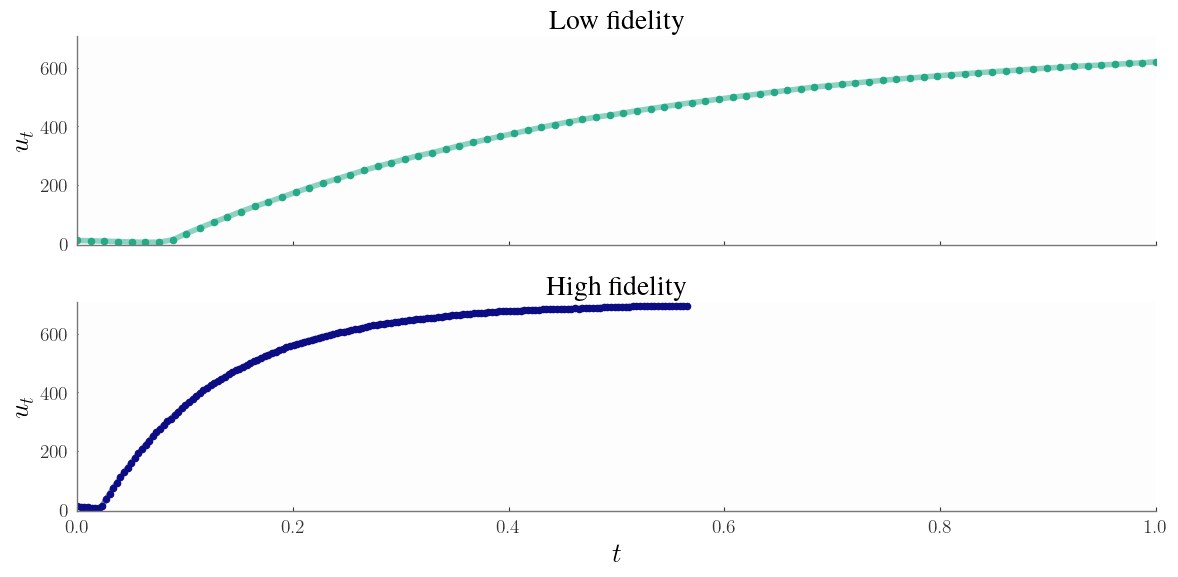

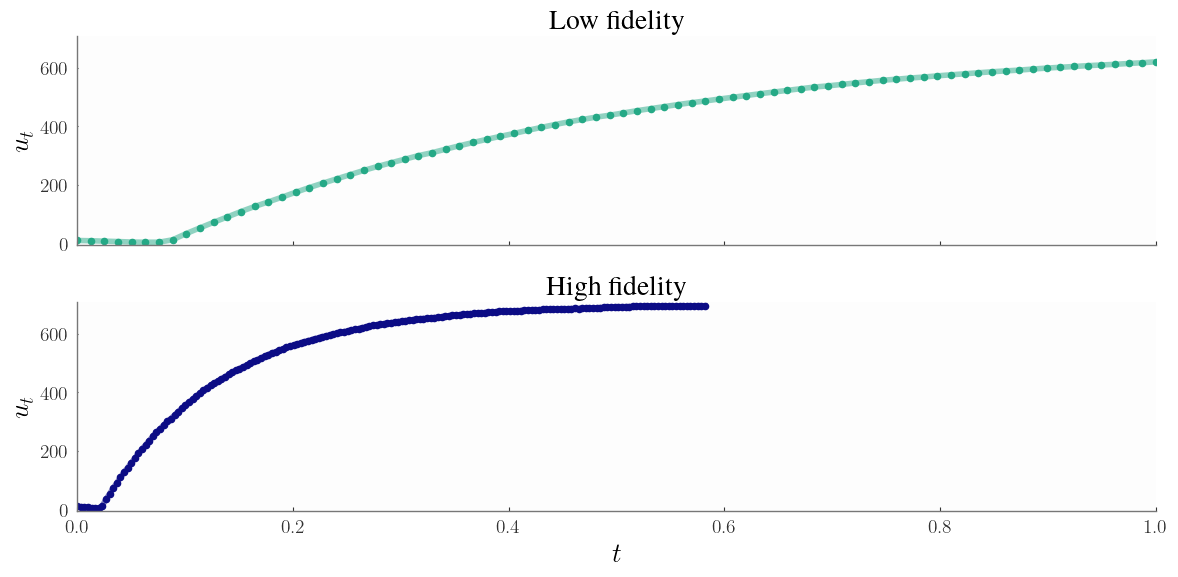

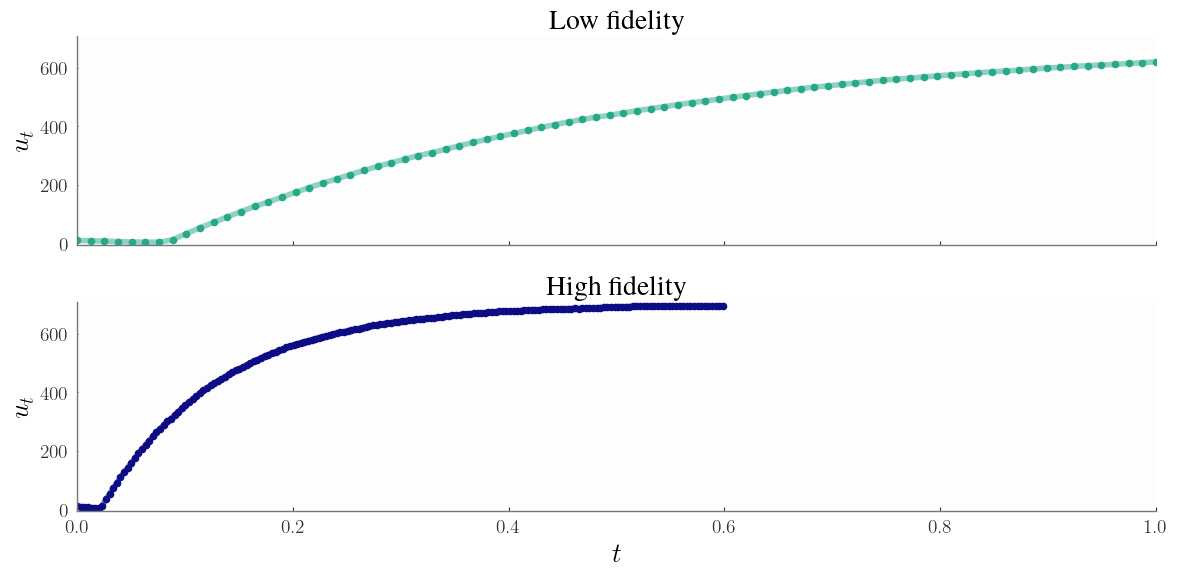

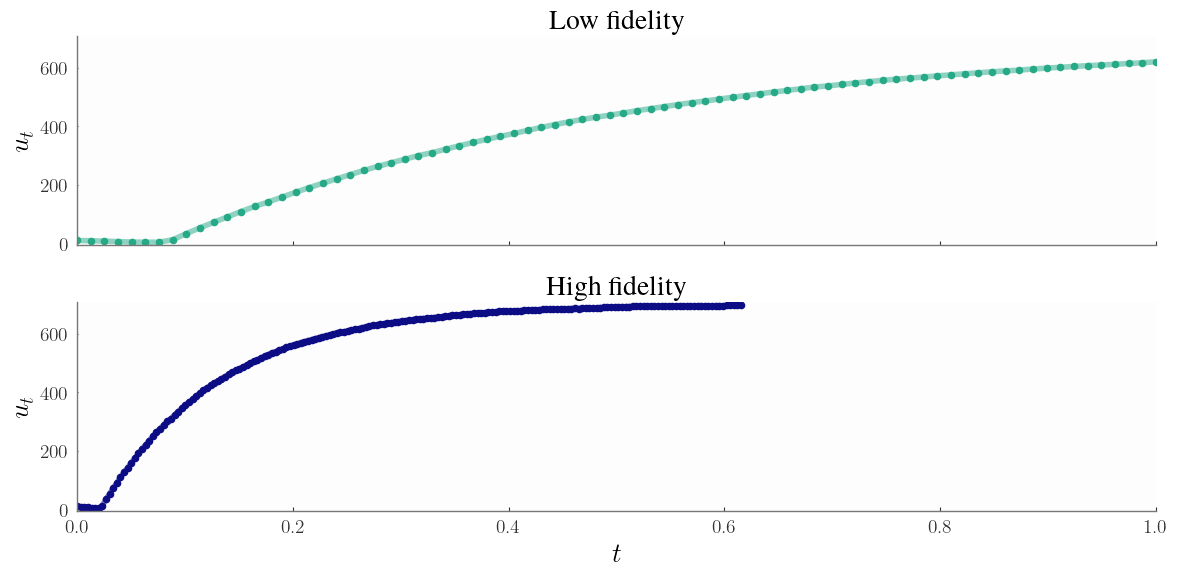

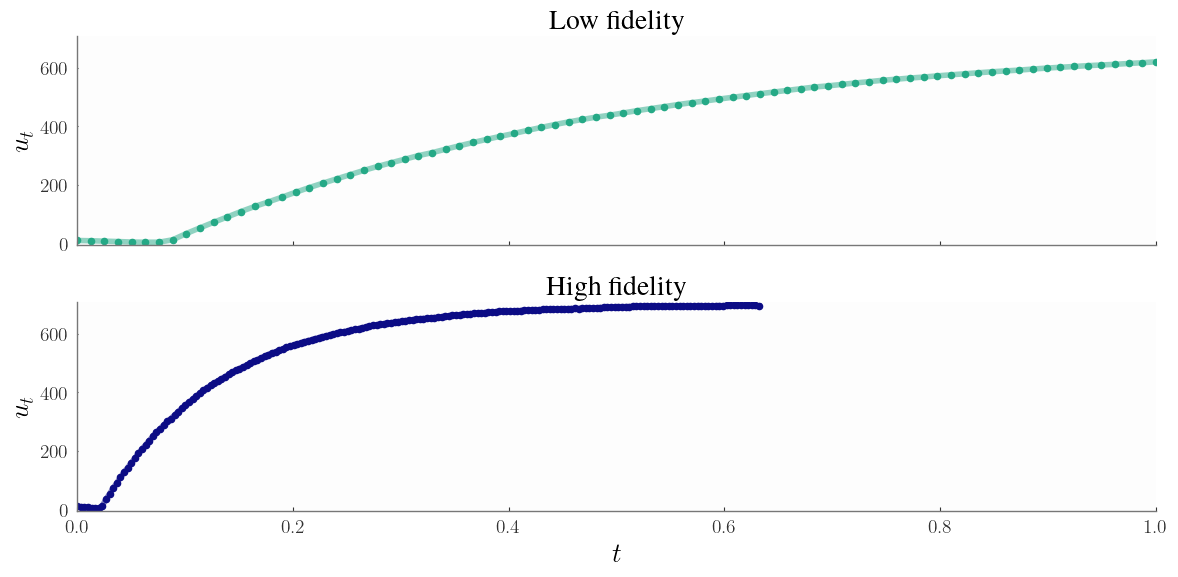

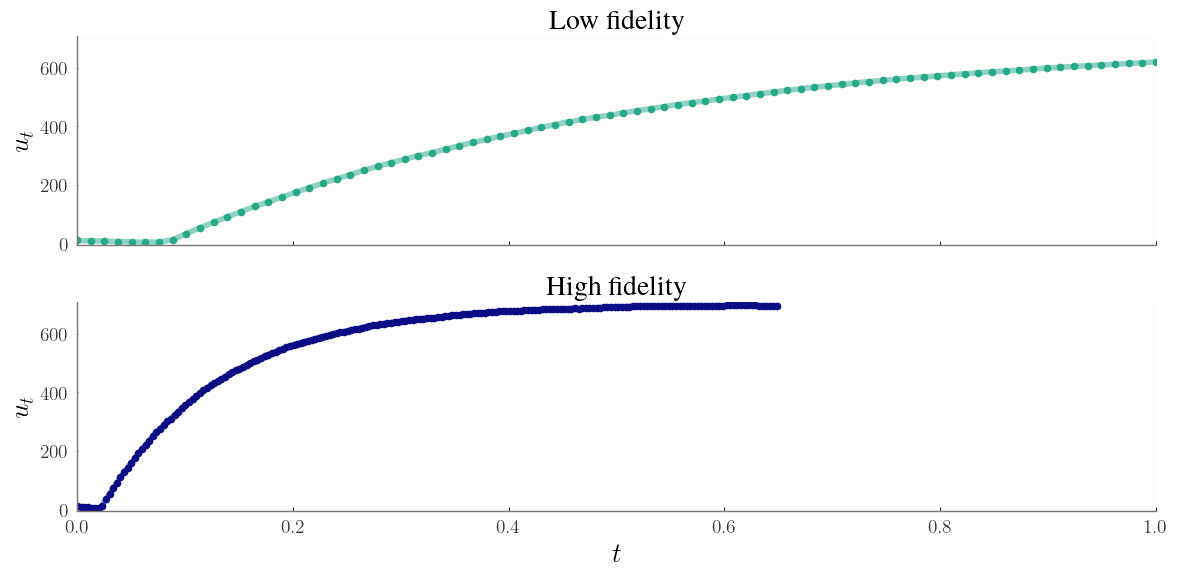

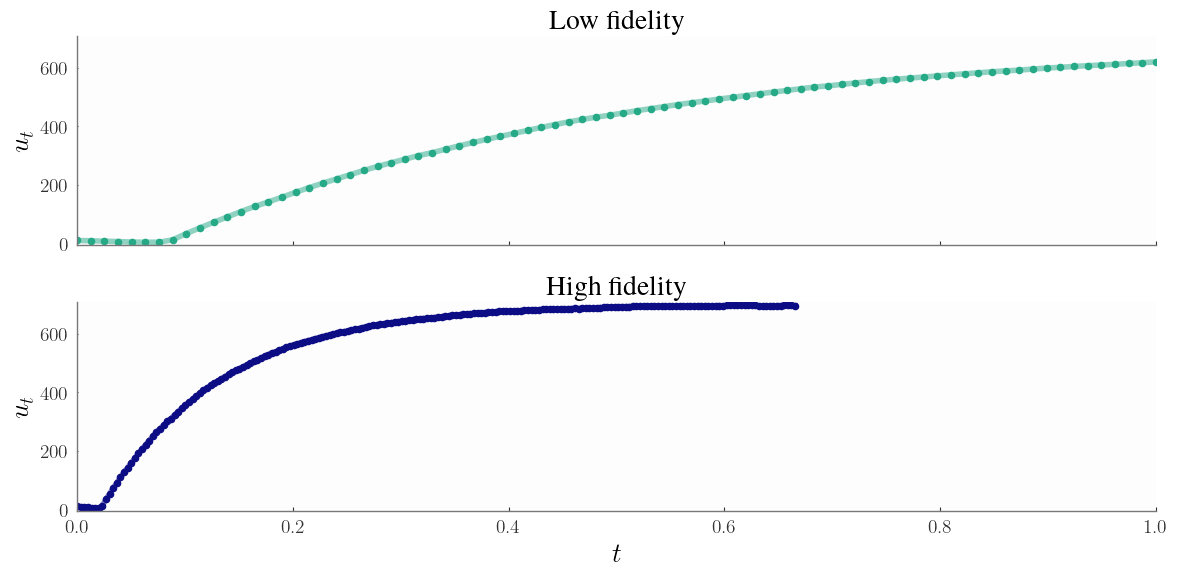

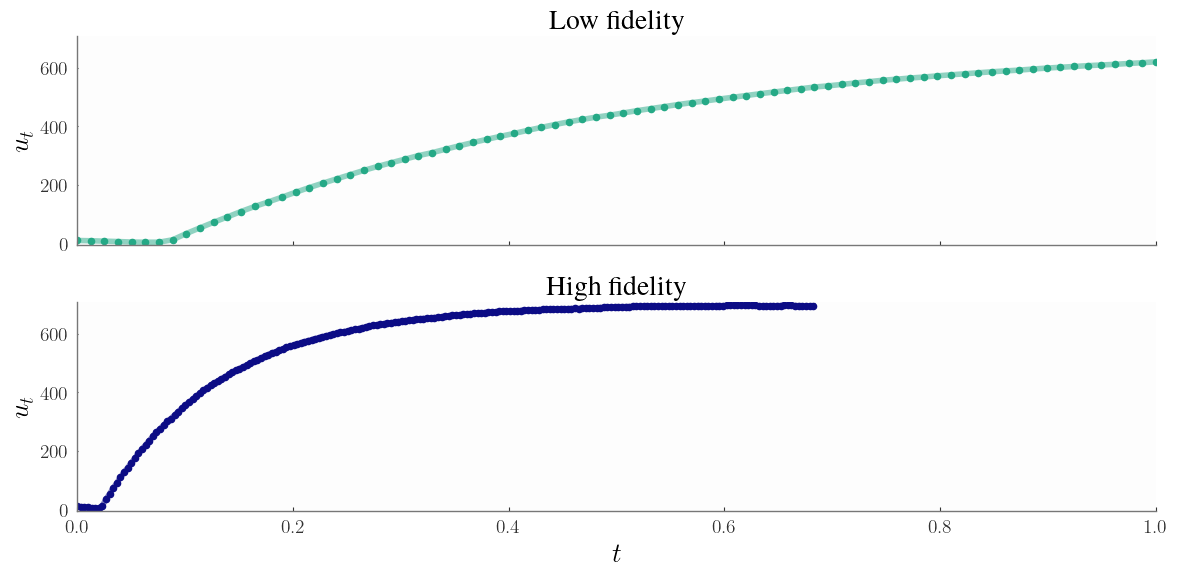

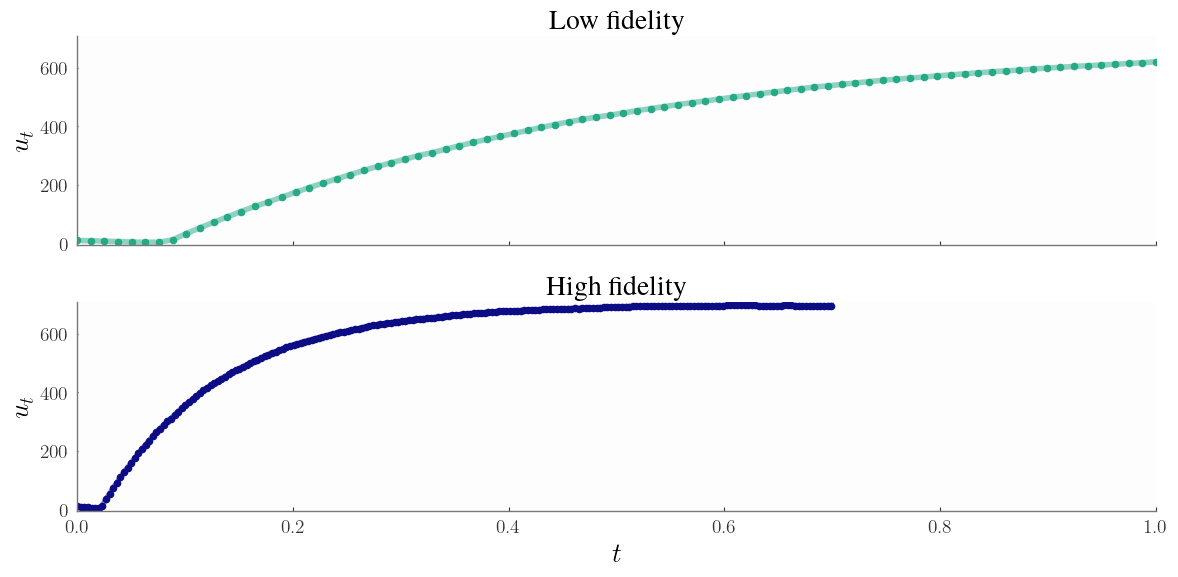

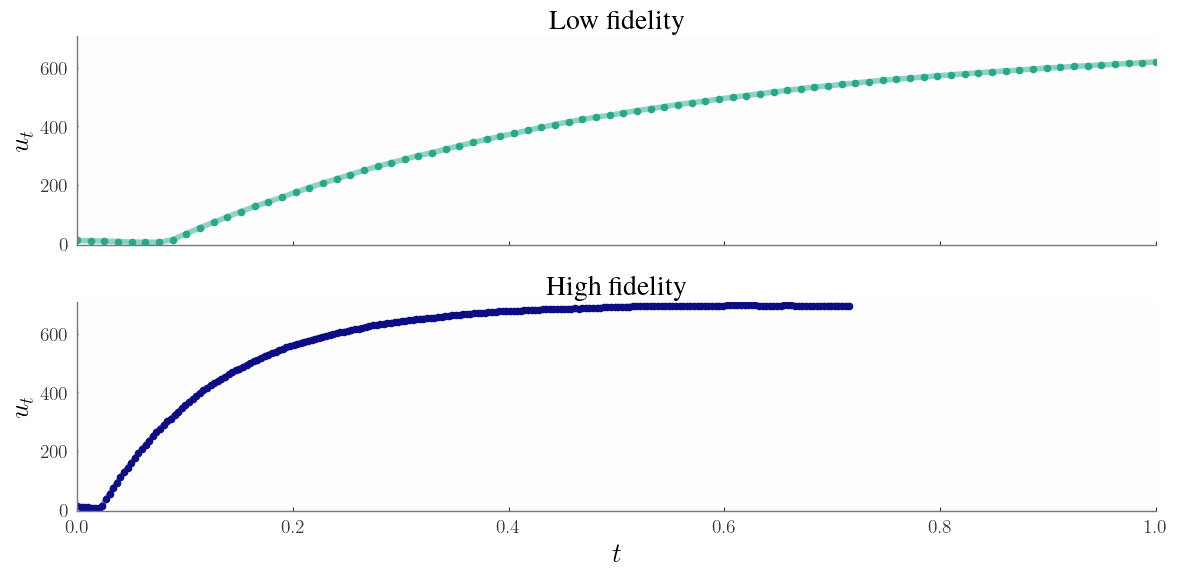

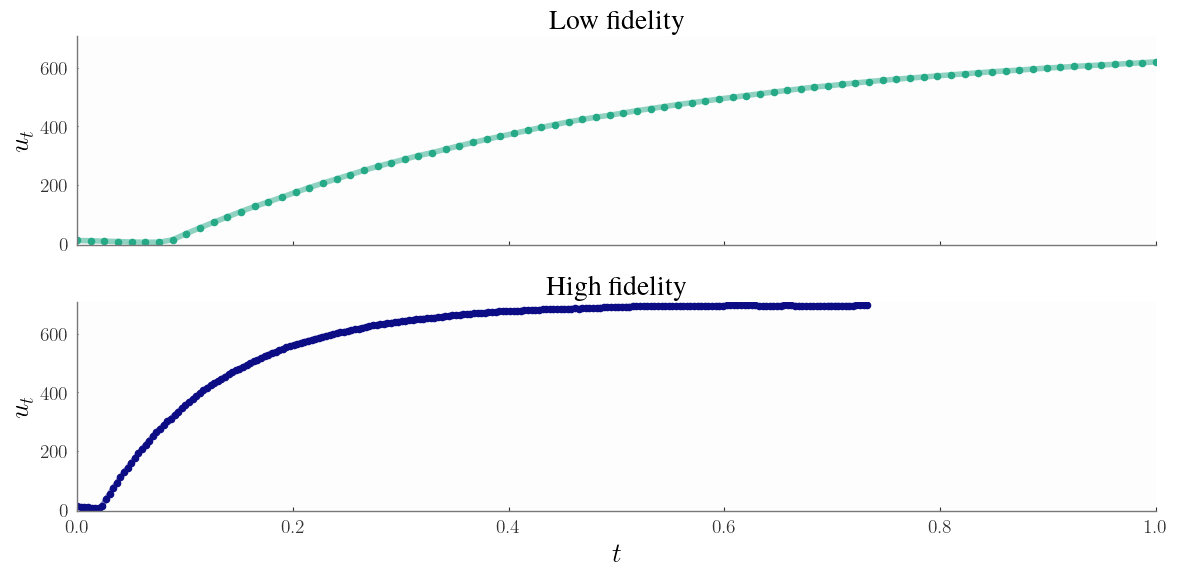

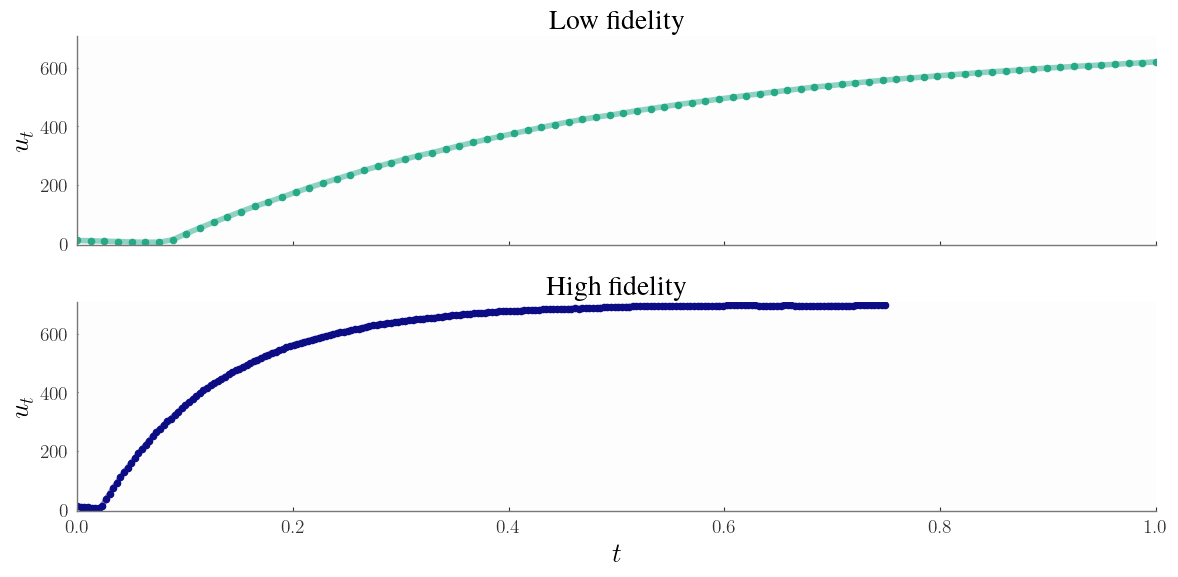

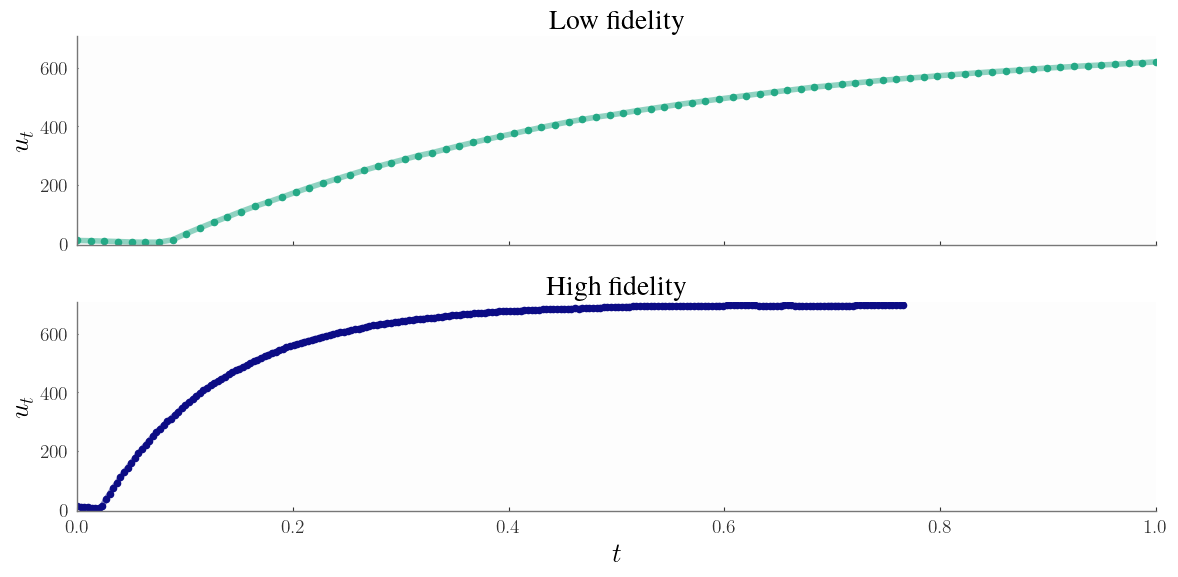

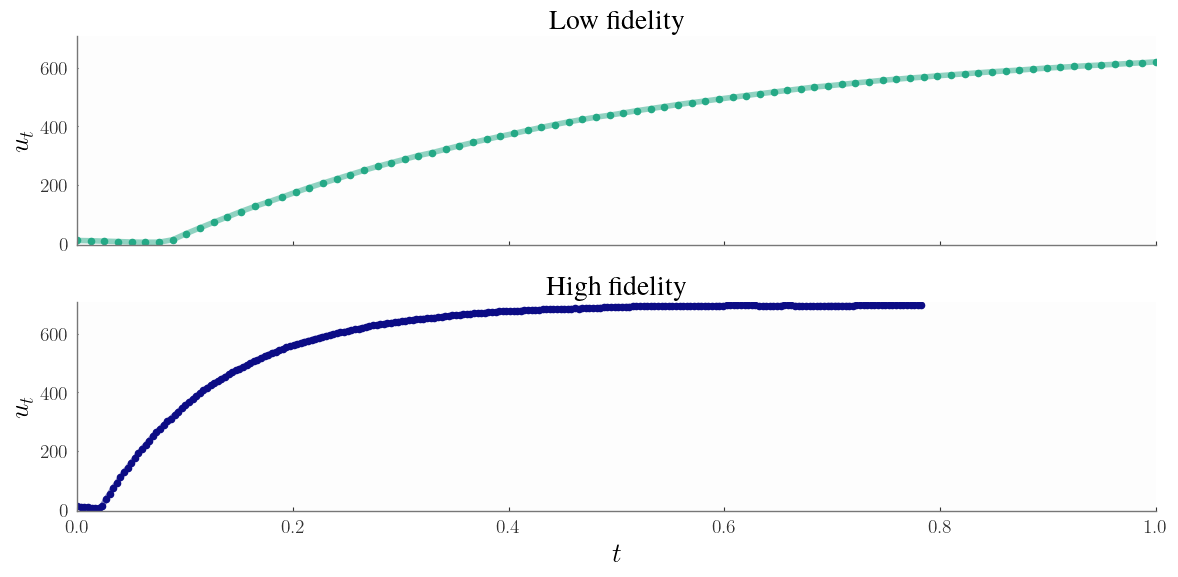

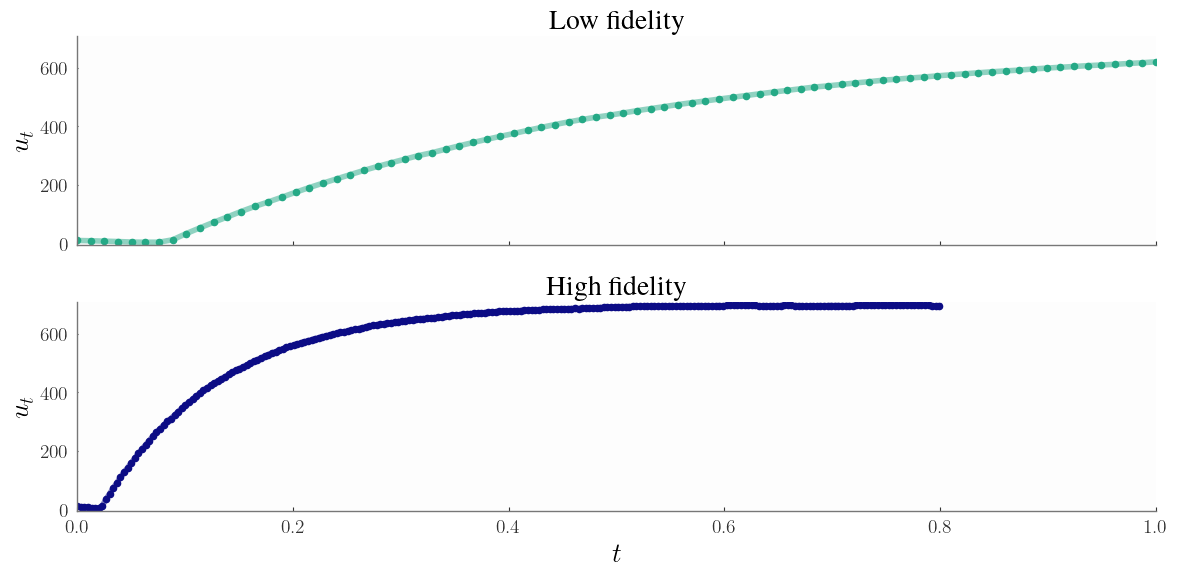

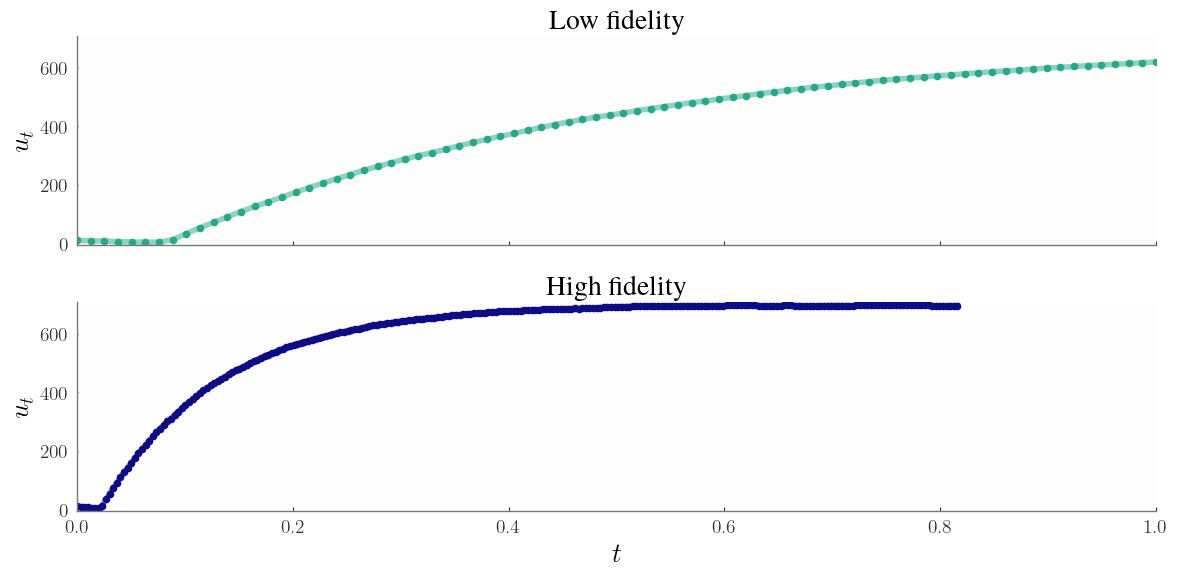

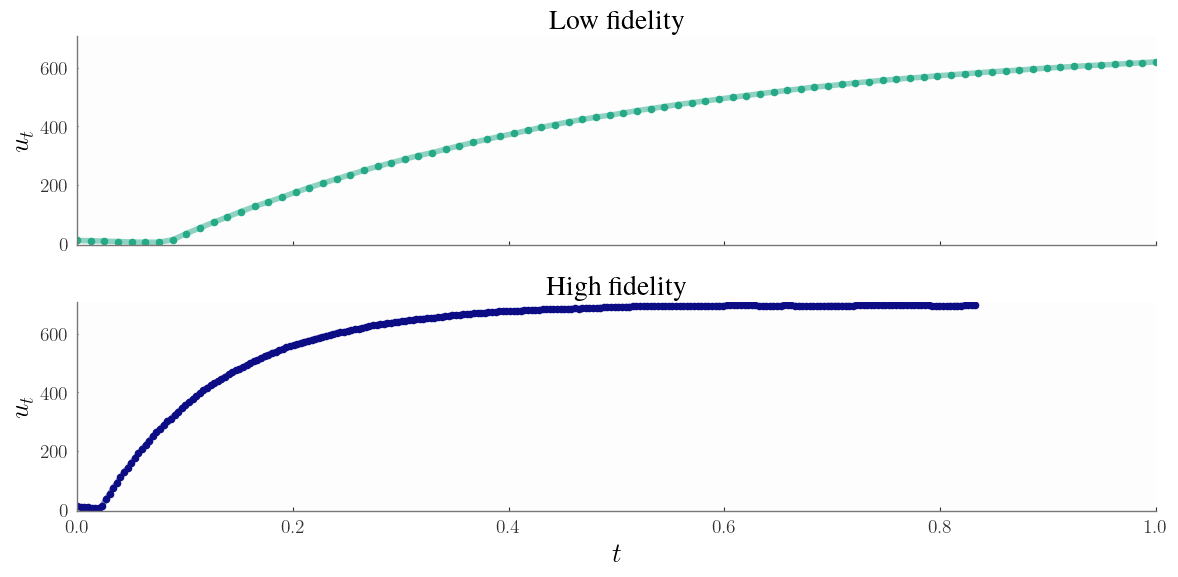

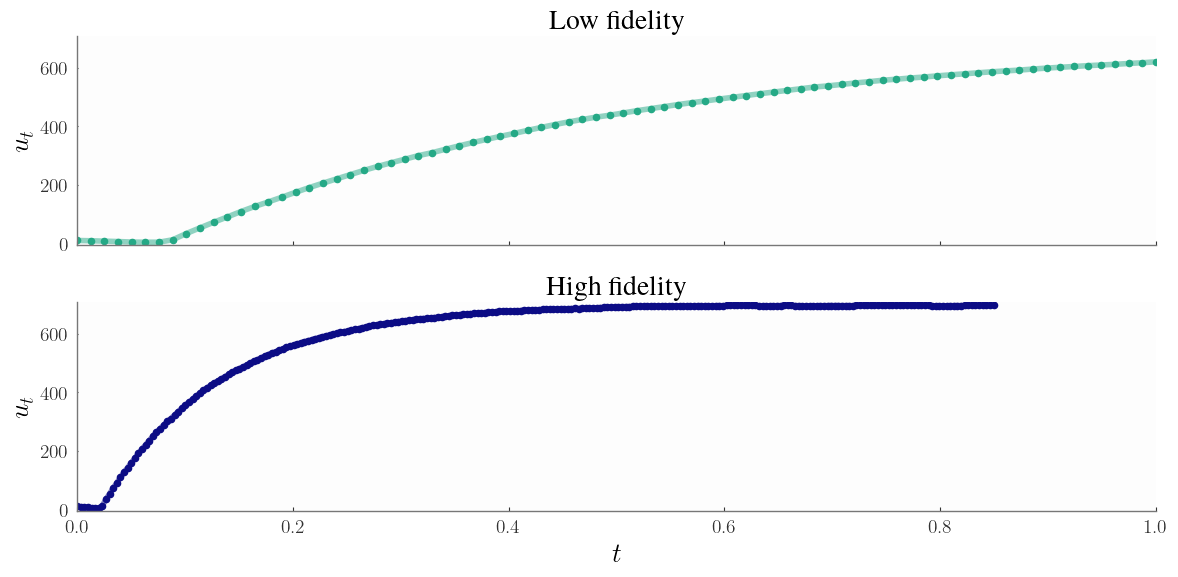

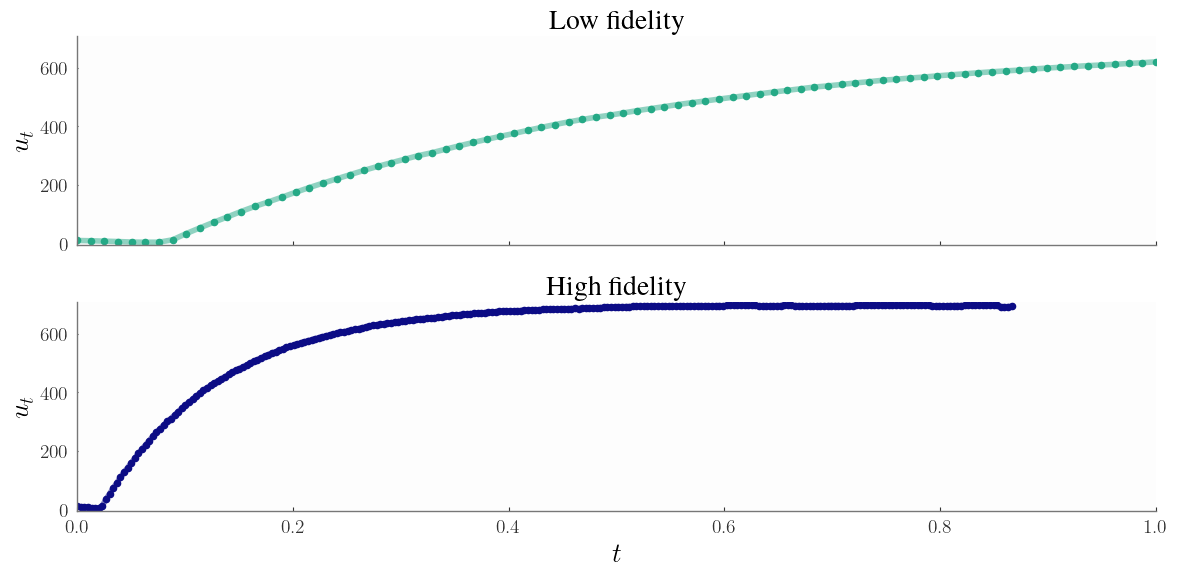

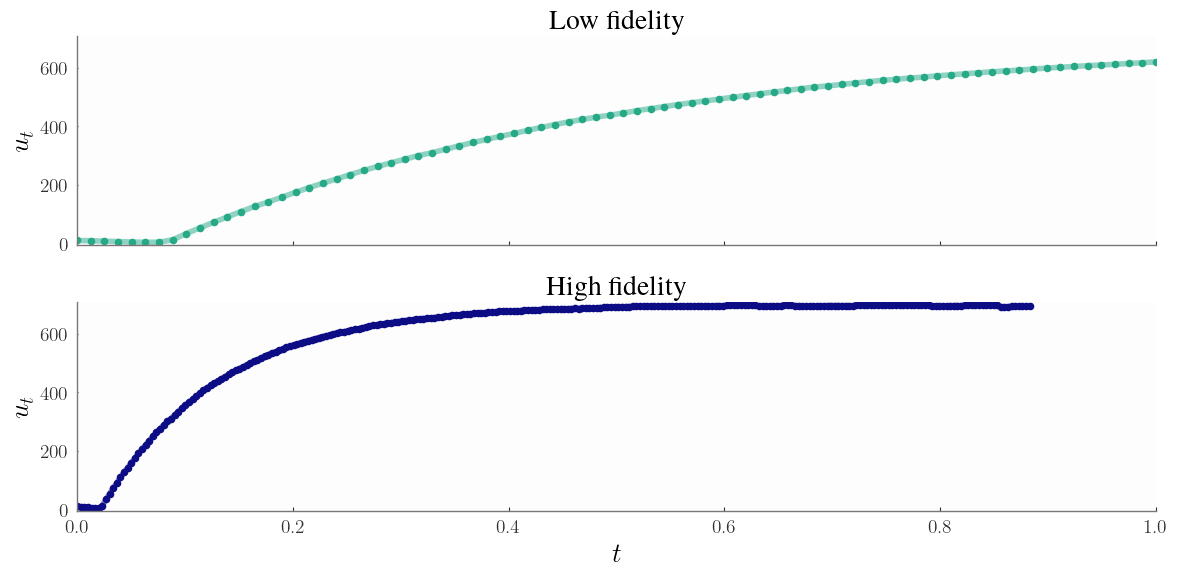

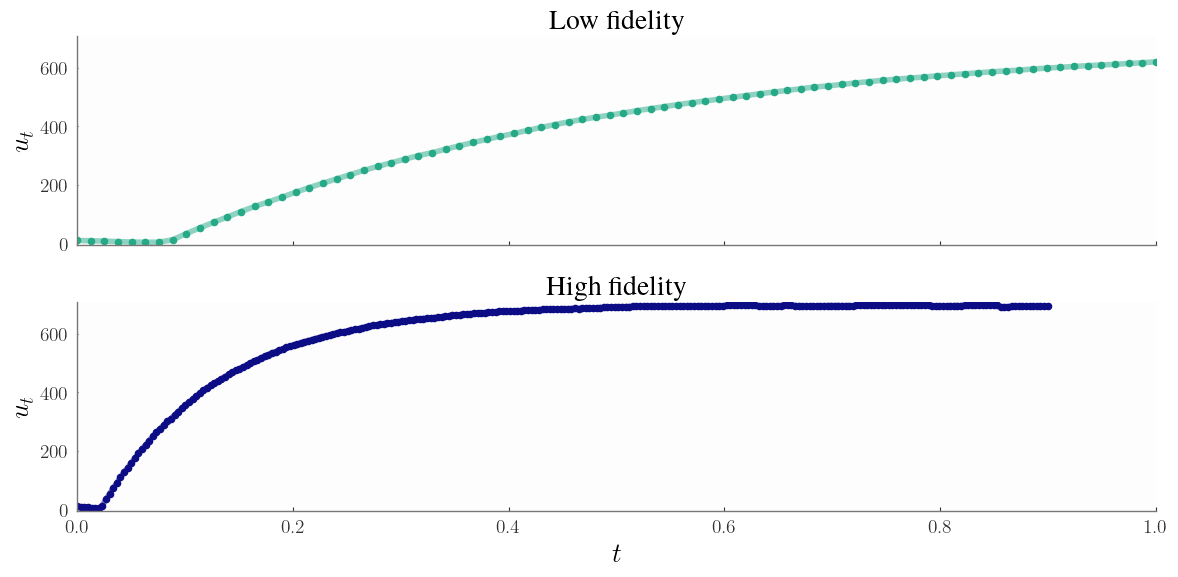

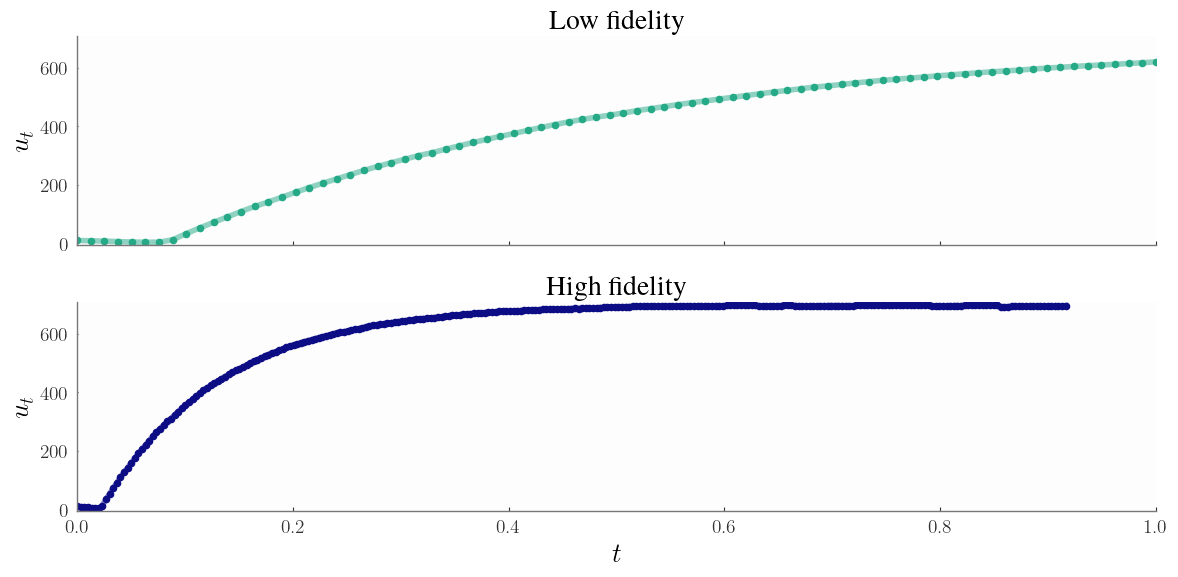

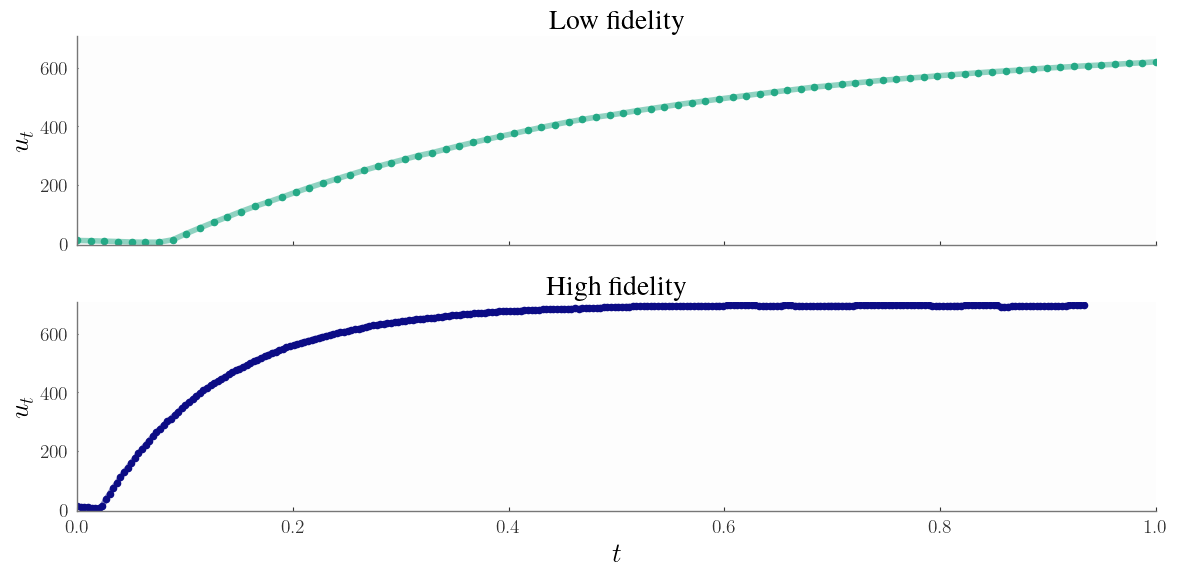

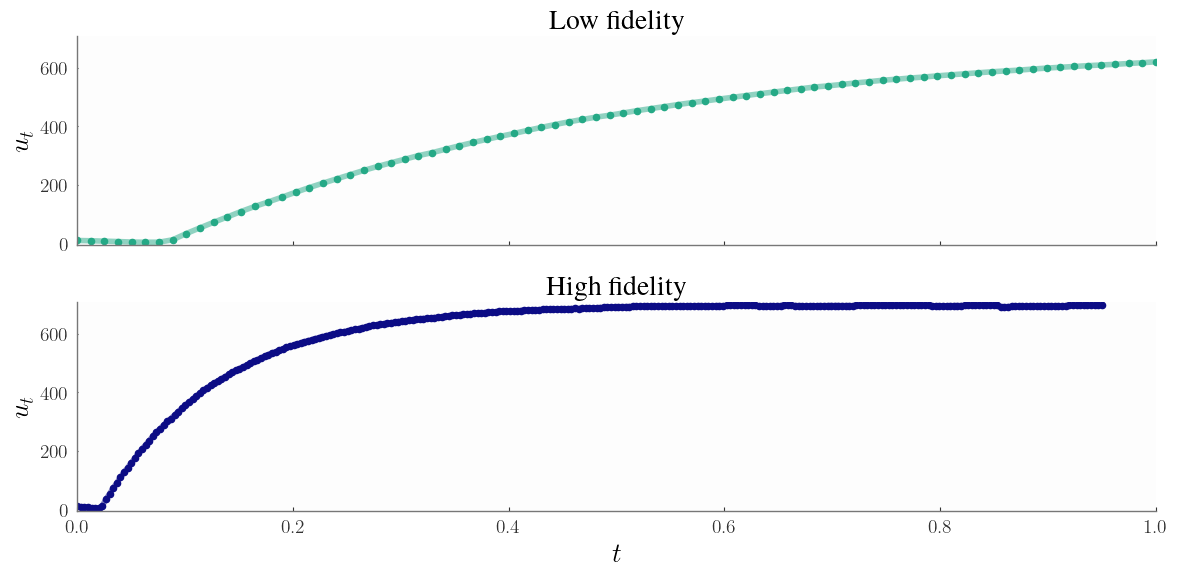

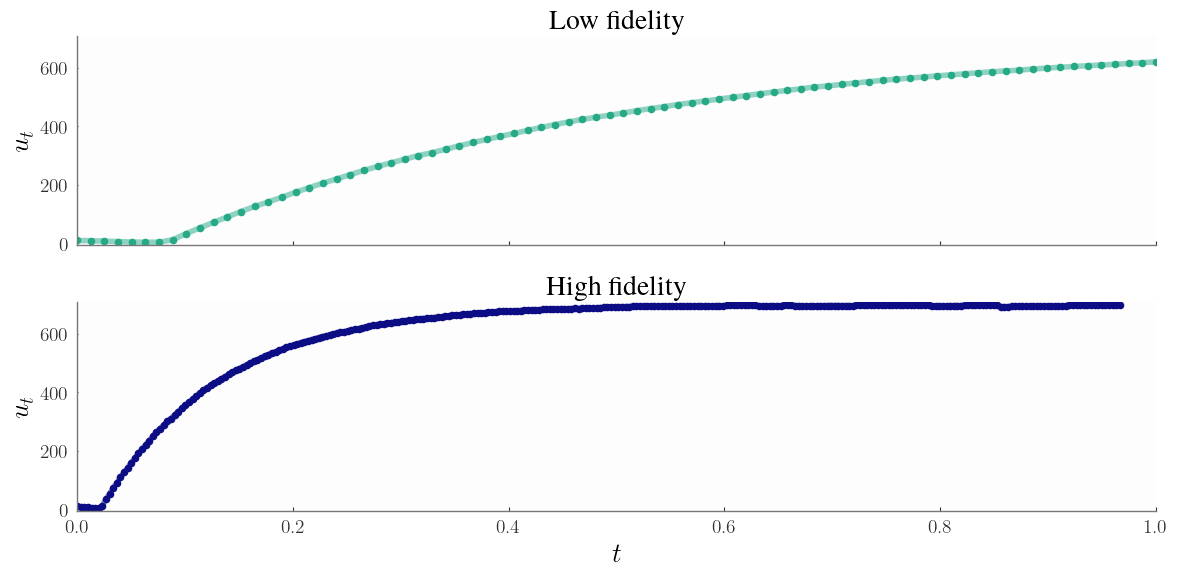

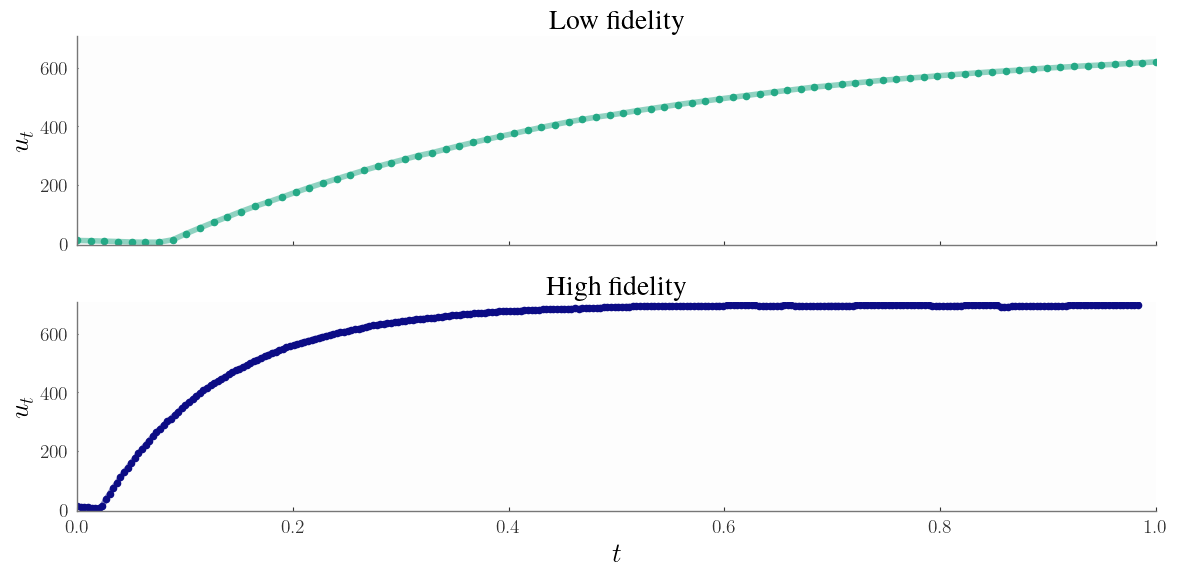

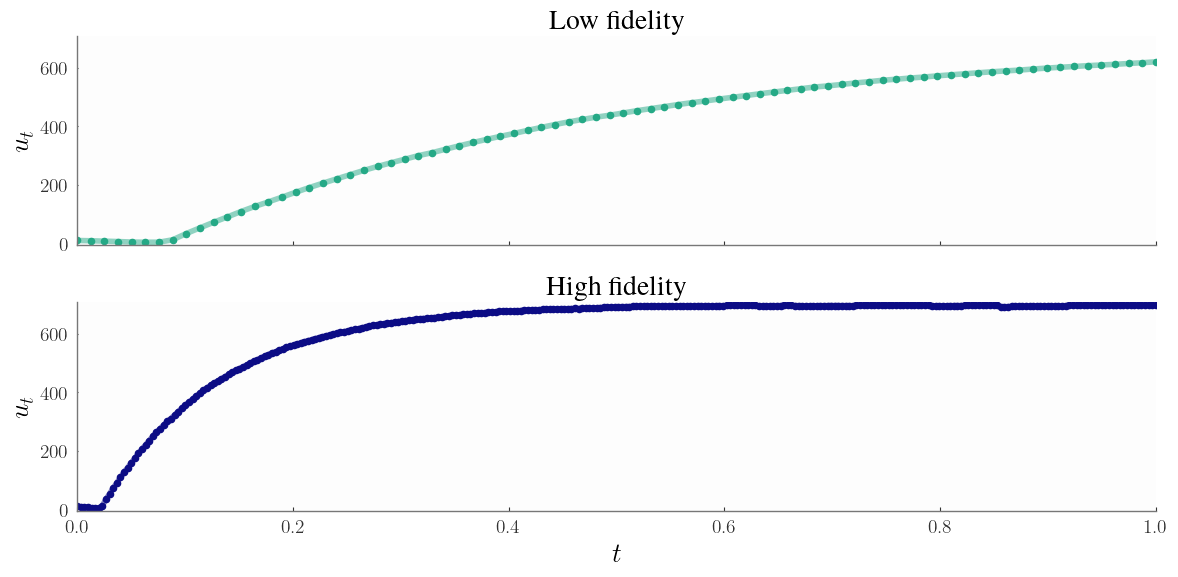

In [315]:
i = 0
T = 300
for t in range(0, T + 1, 5):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    plot_for_gif(T = 80, t = t, ax = ax[0], show_x_label = False)
    plot_for_gif(T = 300, t = t, ax = ax[1], show_x_label = True)
    fig.tight_layout()
    path = os.path.join(gif_dir, f'ts2_{str(i).zfill(3)}.png')
    fig.savefig(path, dpi = 300, bbox_inches = 'tight')
    i += 1

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_56325/2015181213.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 3))


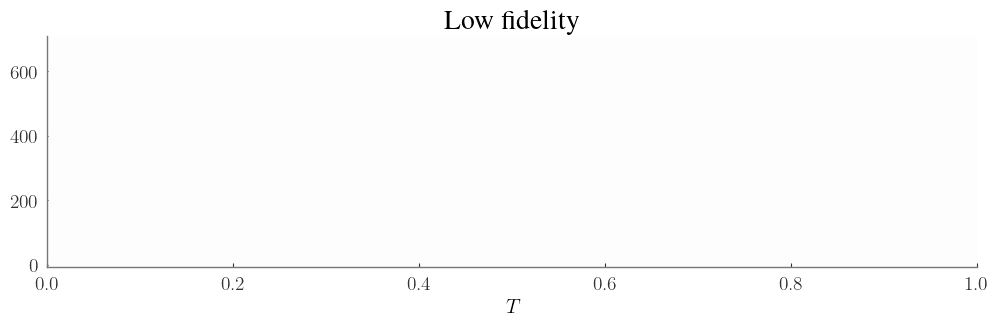

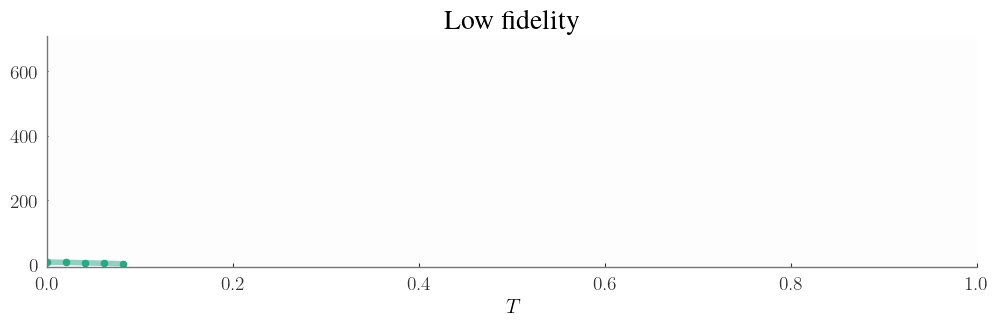

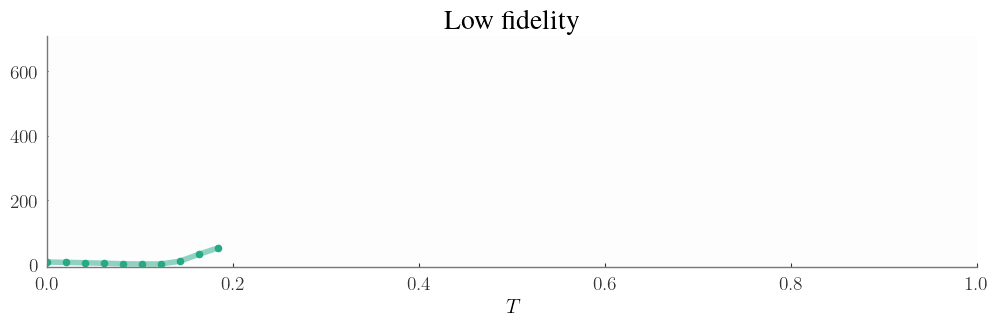

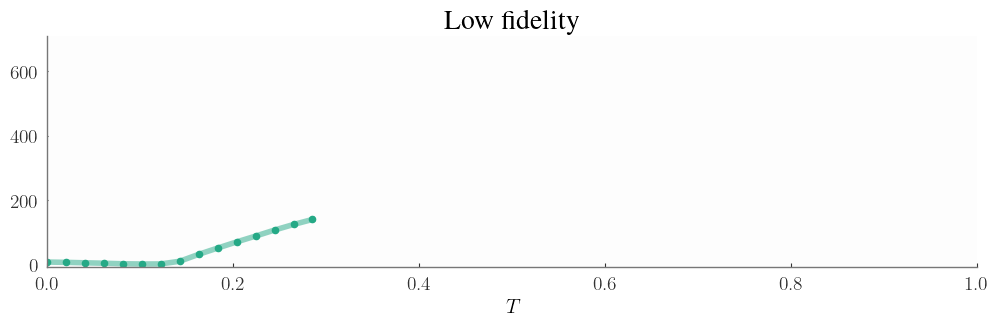

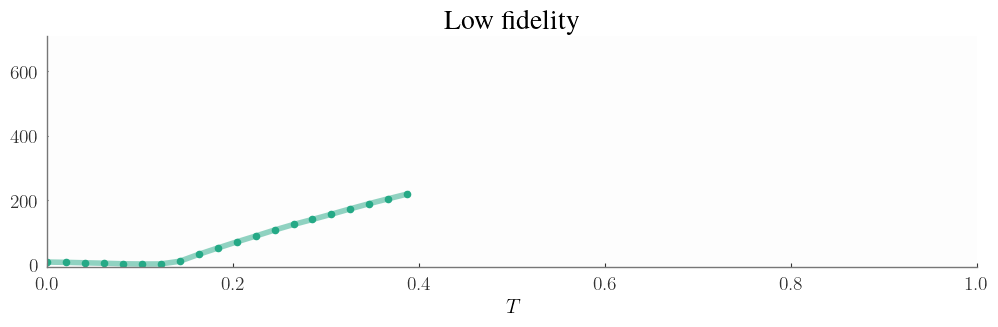

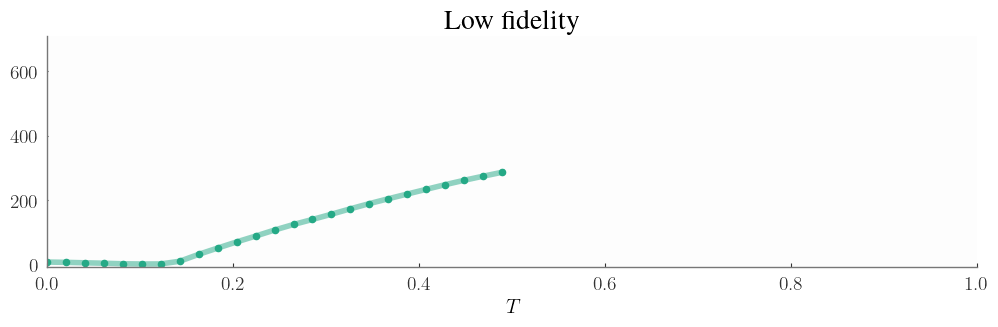

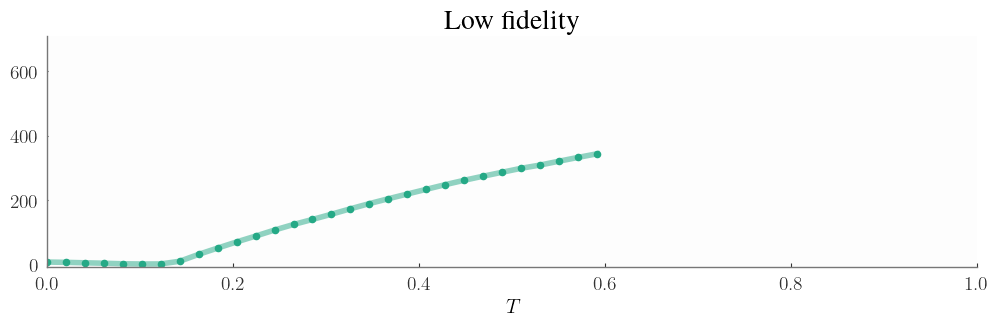

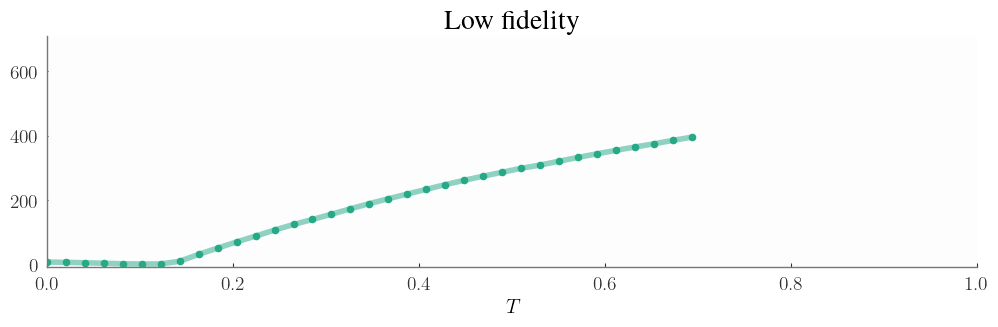

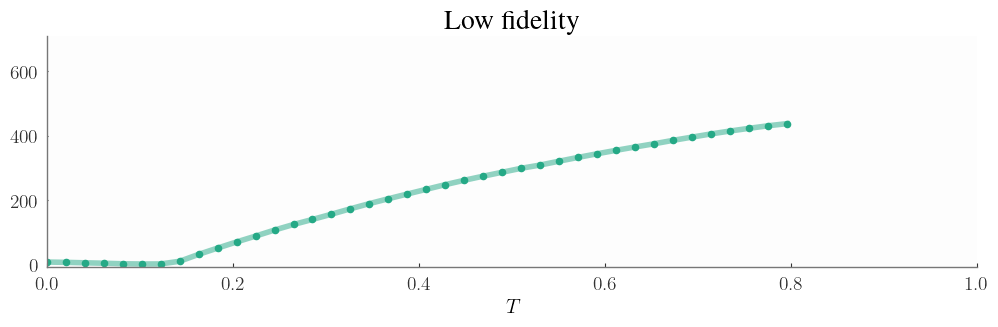

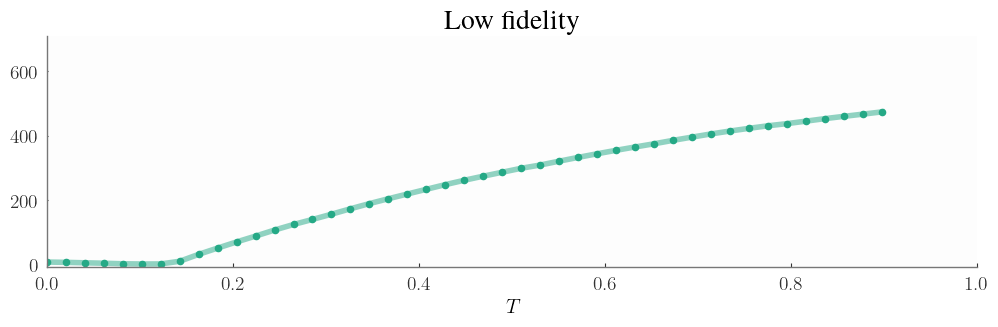

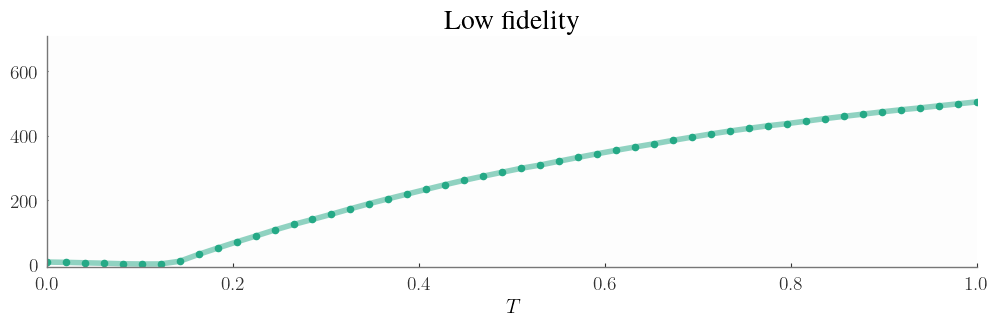

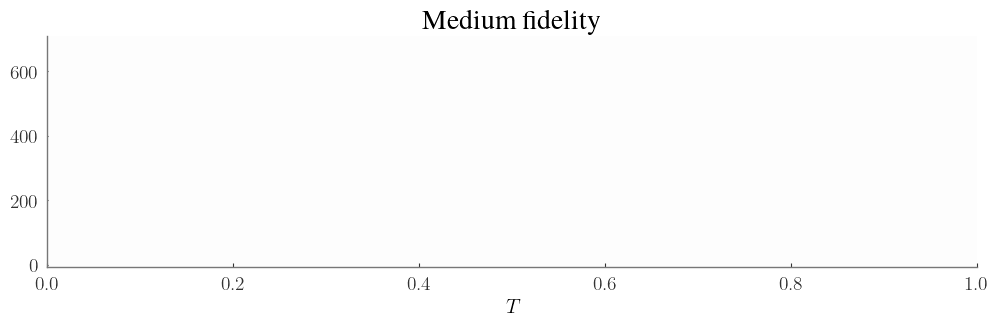

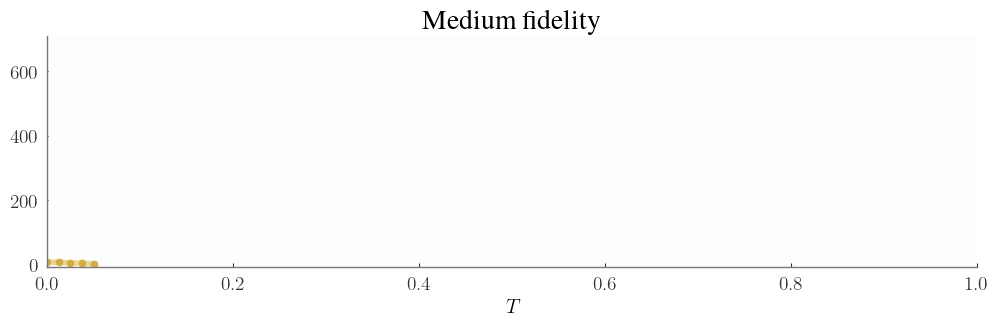

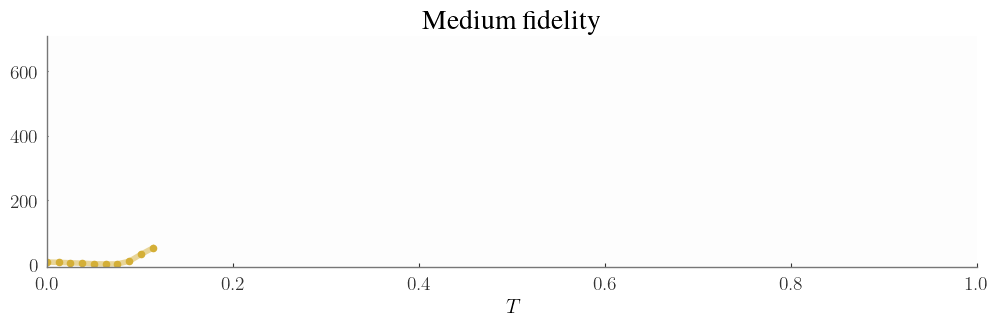

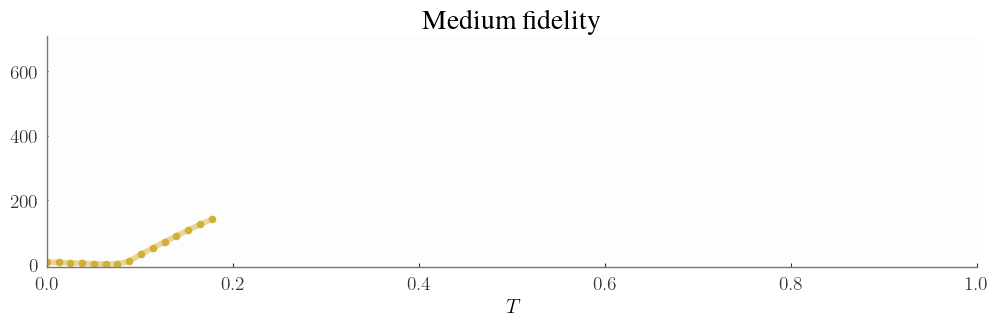

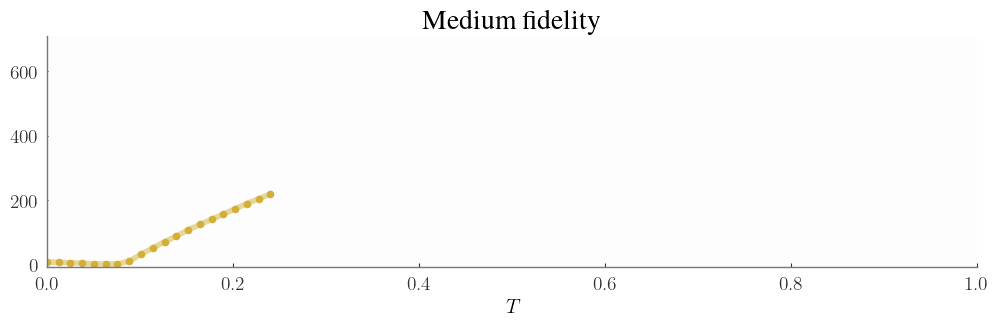

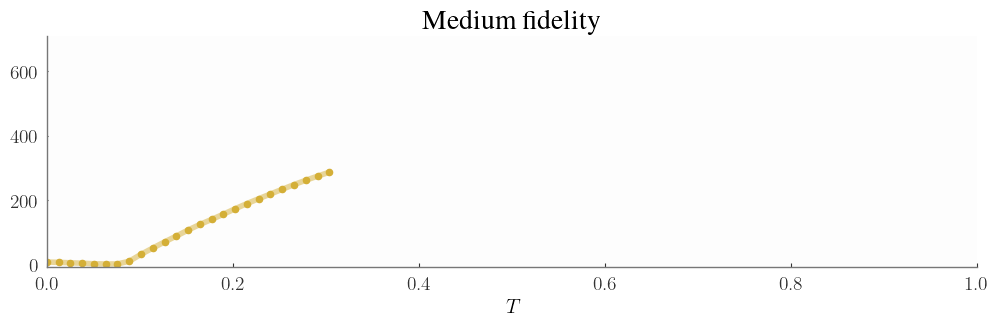

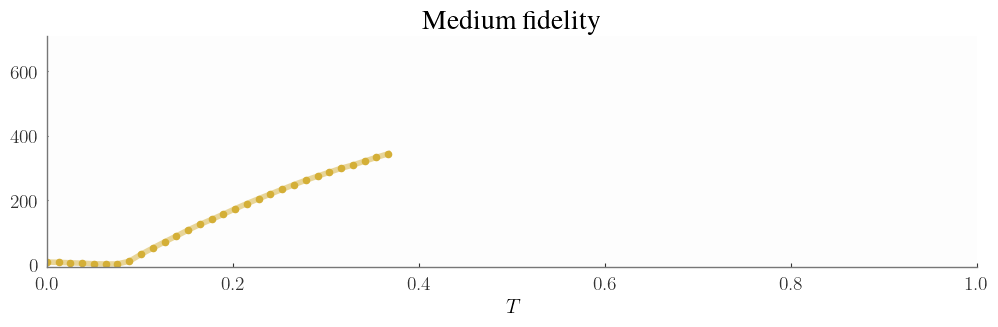

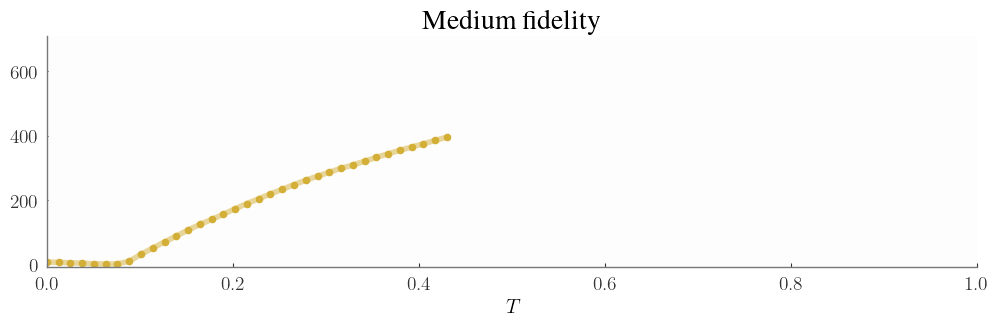

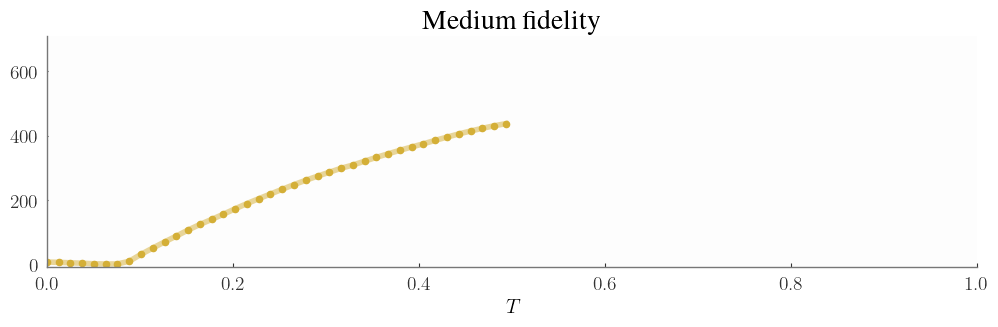

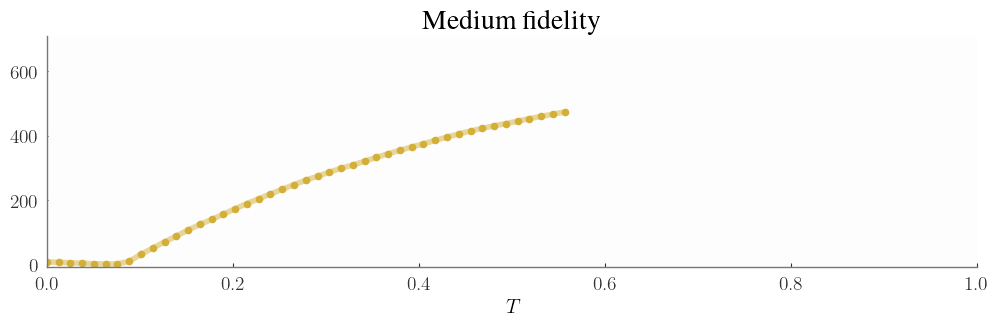

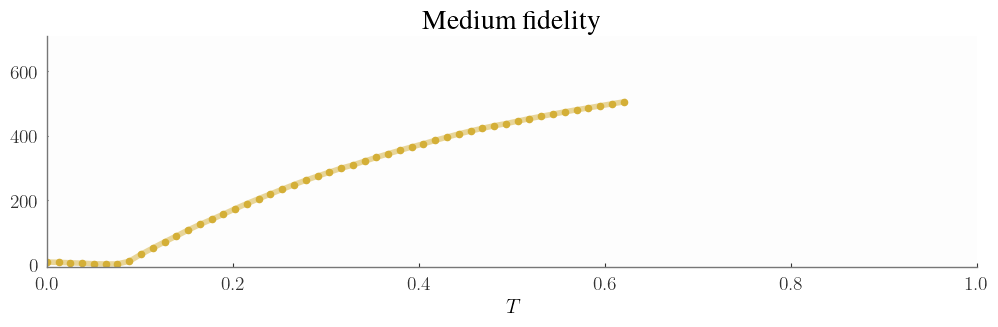

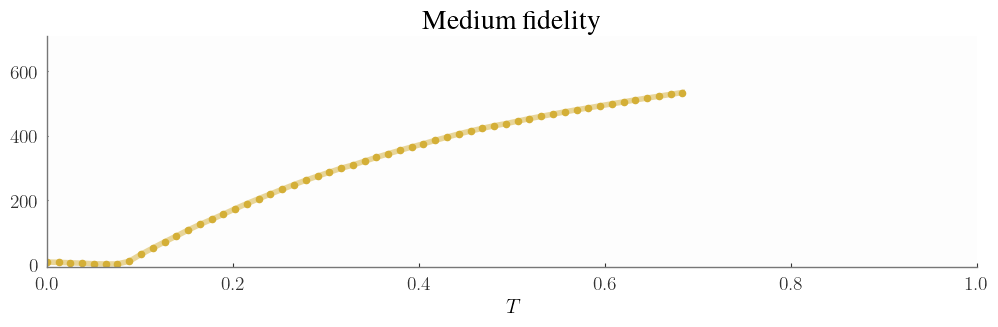

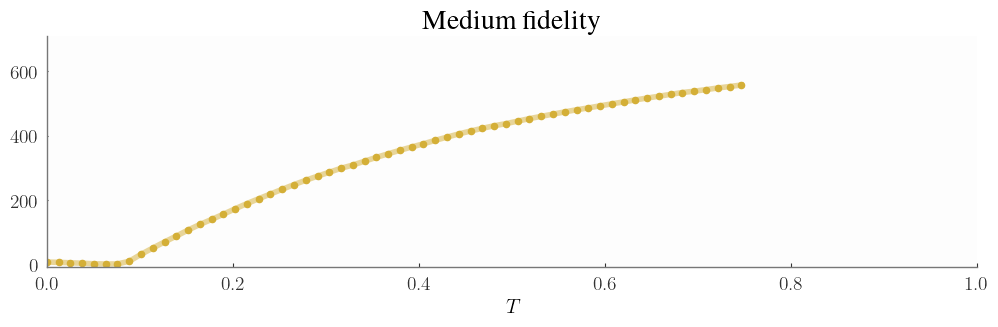

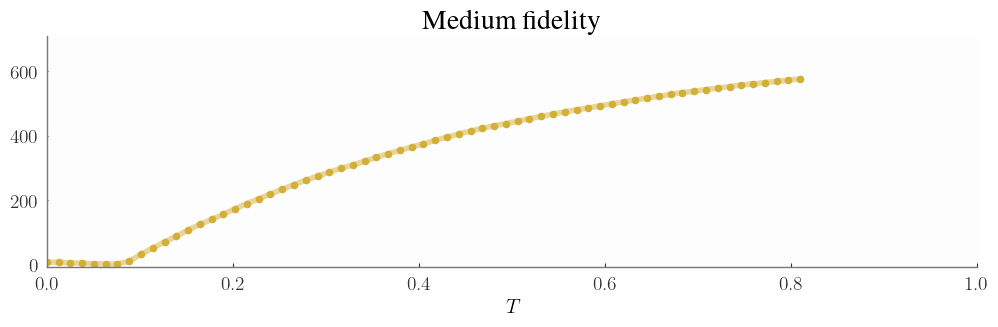

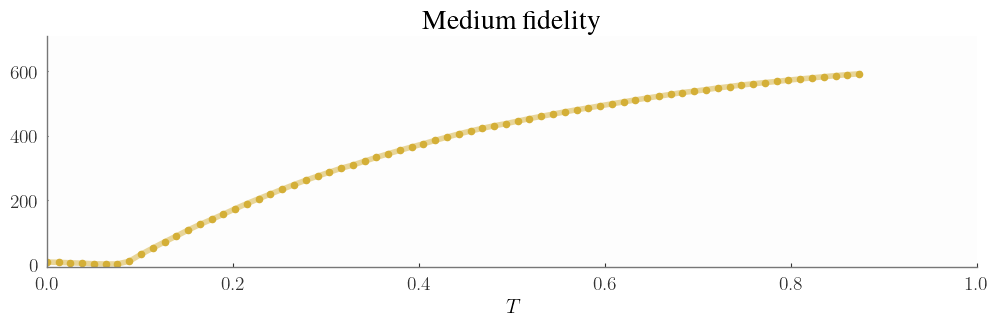

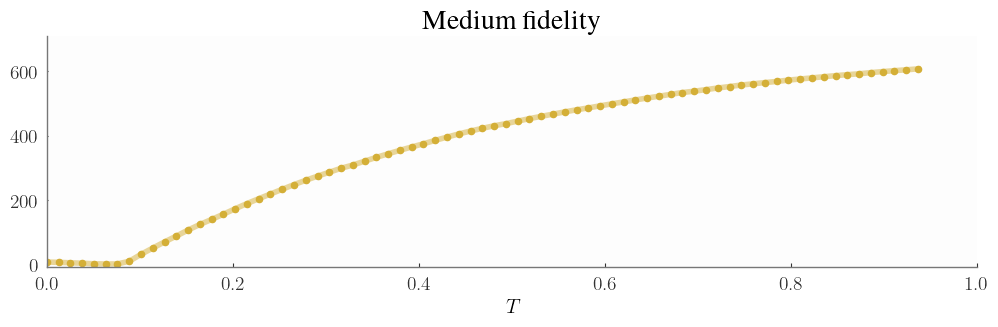

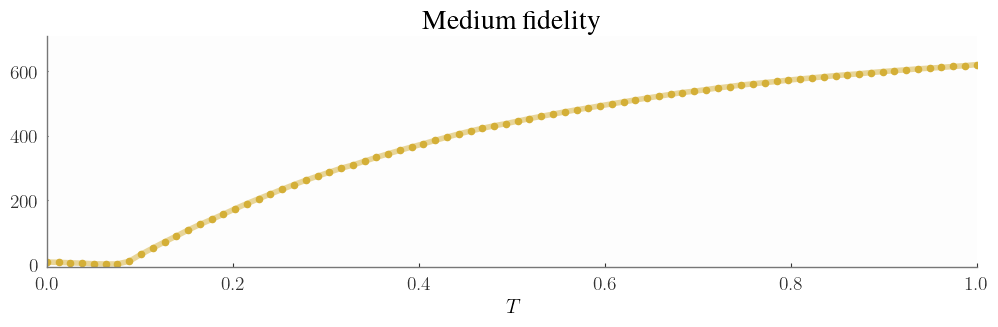

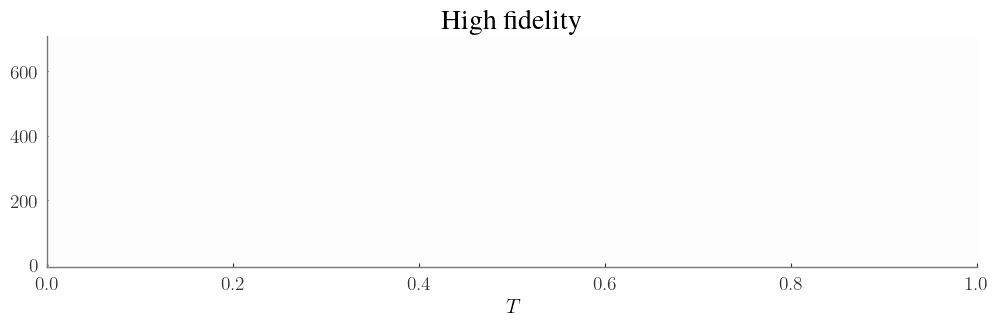

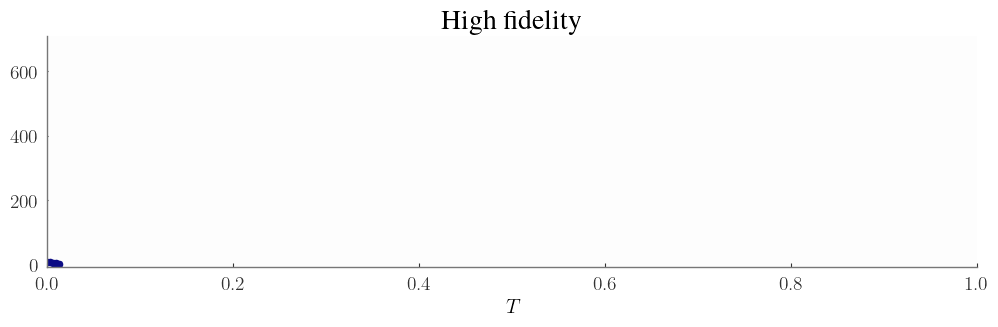

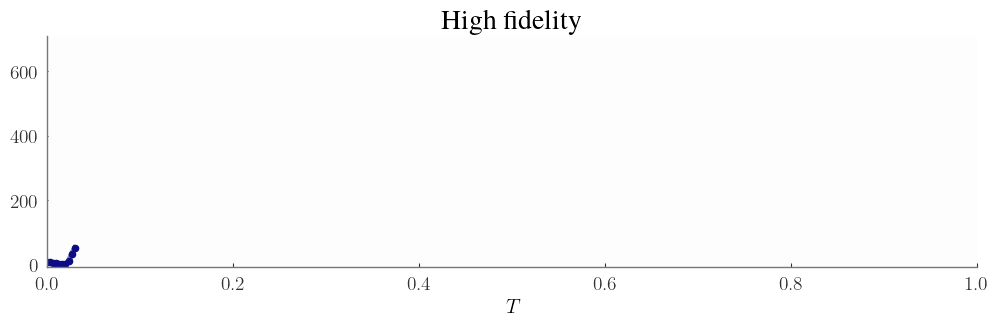

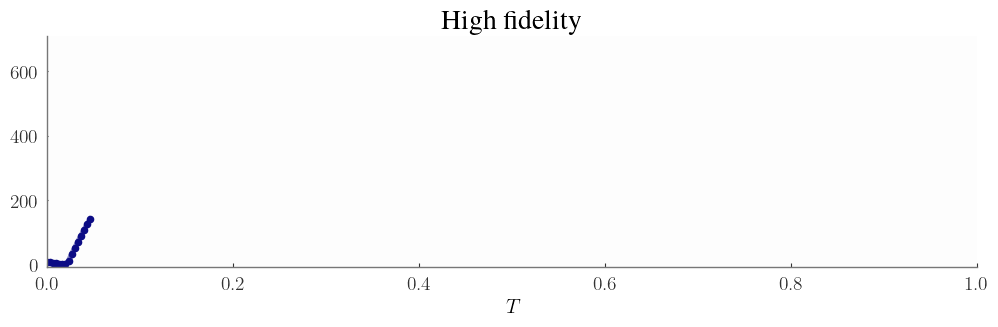

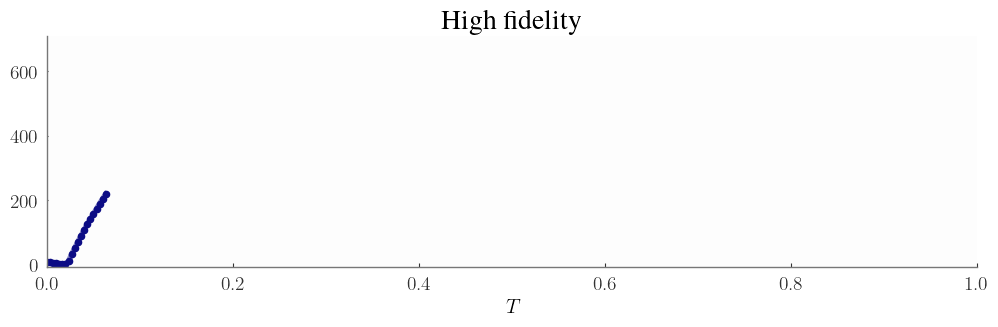

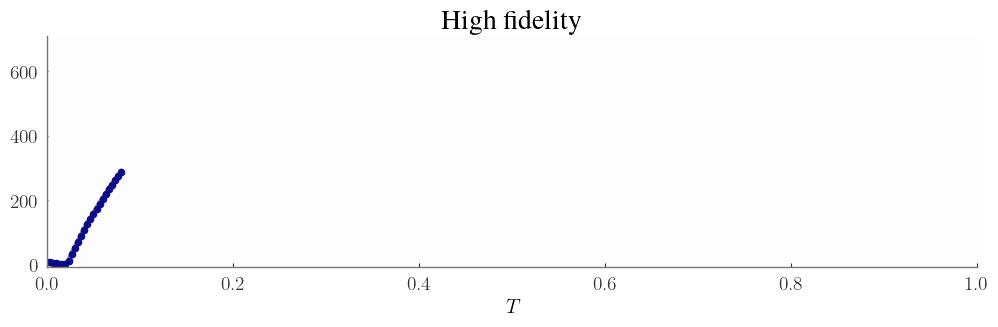

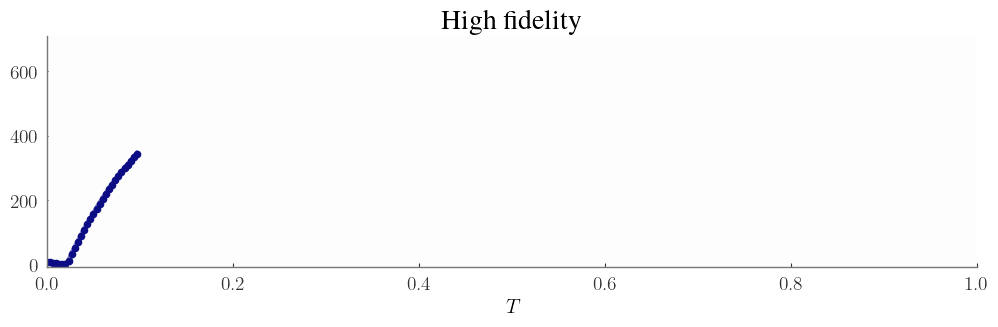

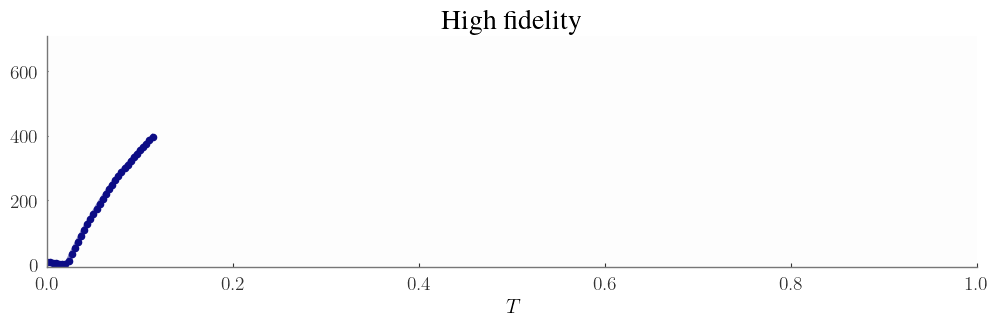

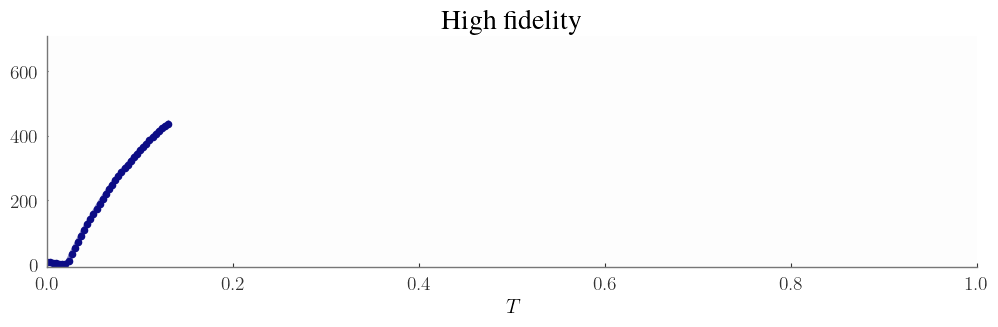

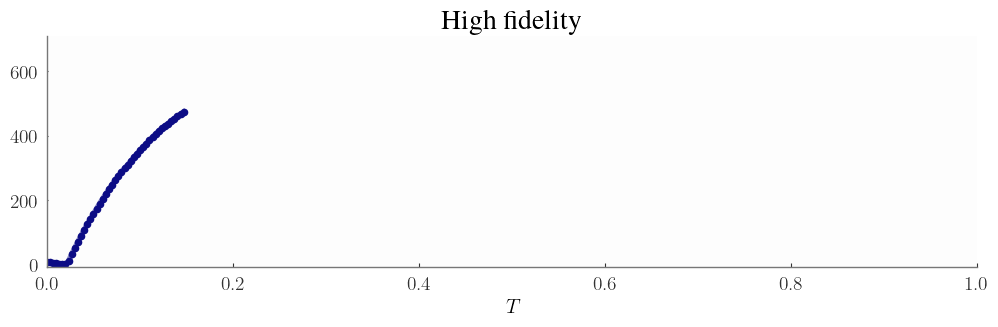

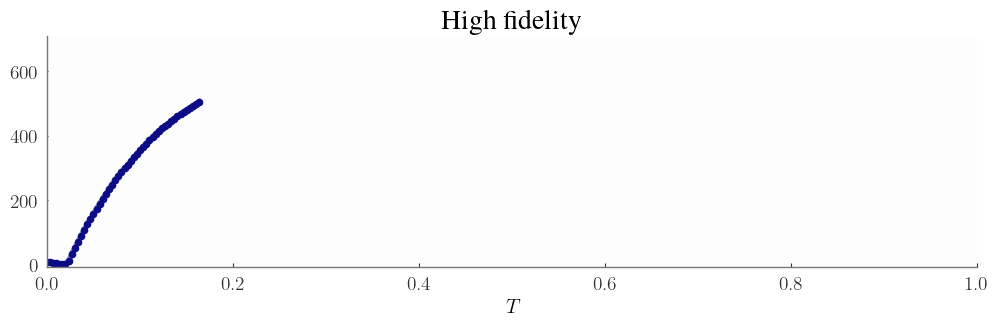

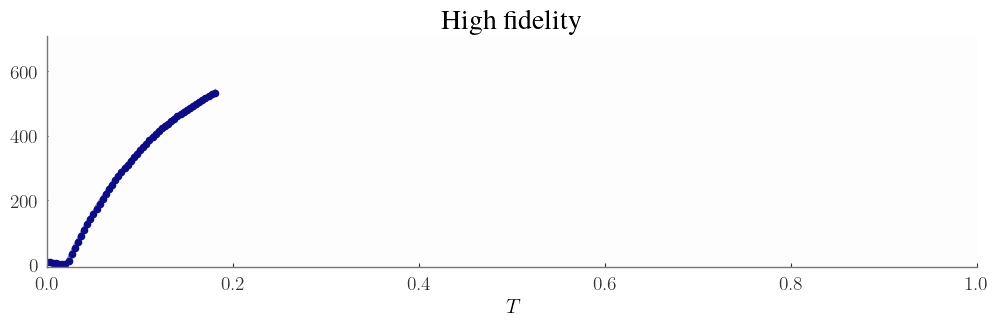

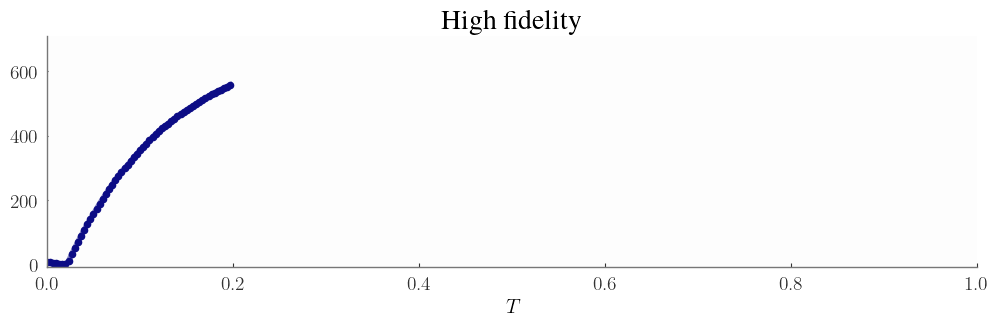

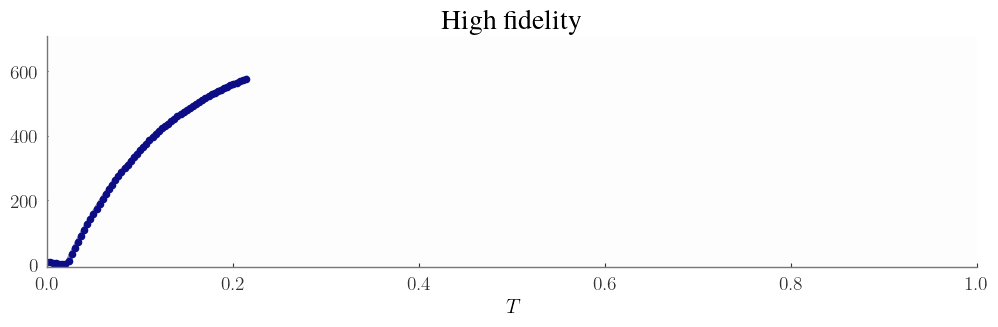

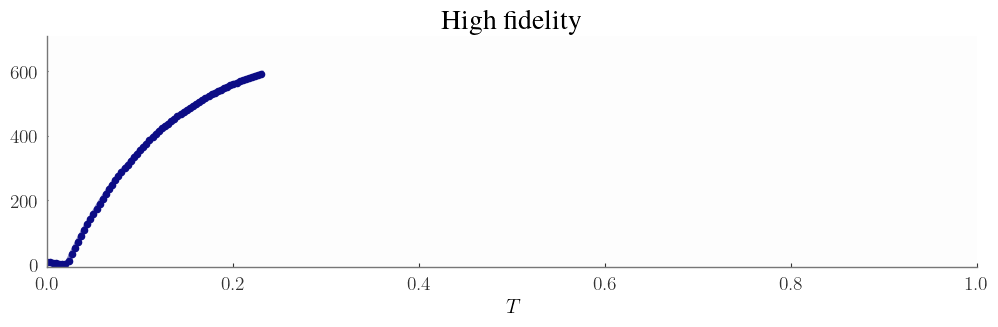

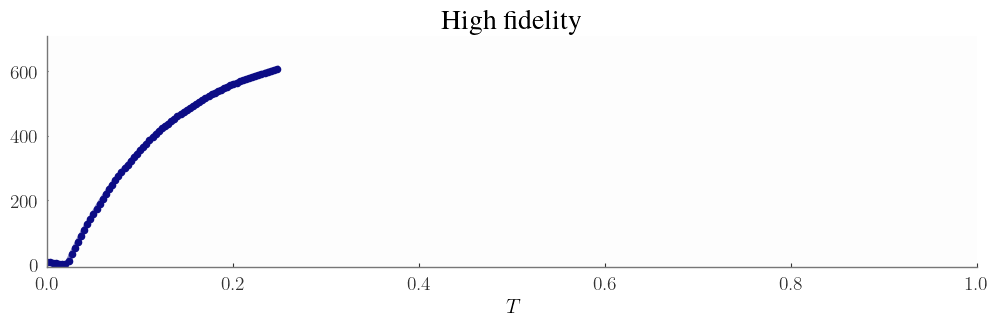

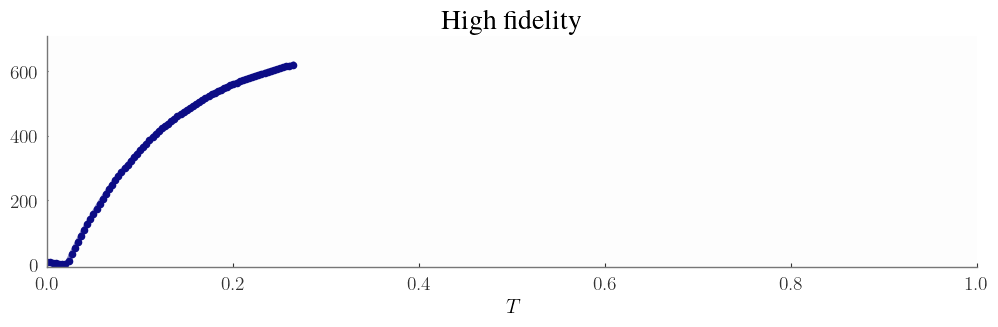

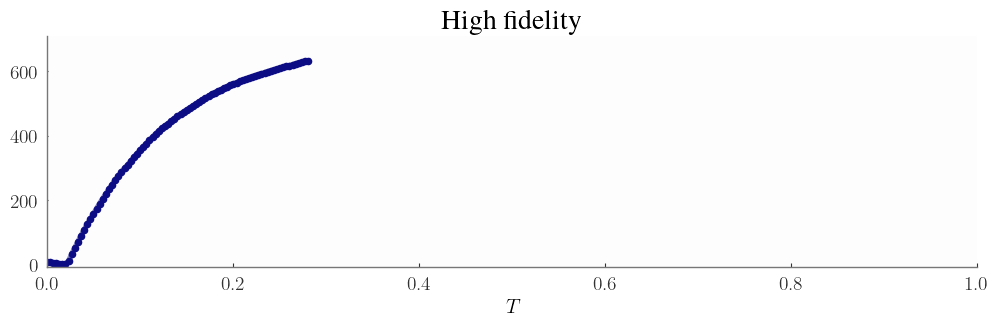

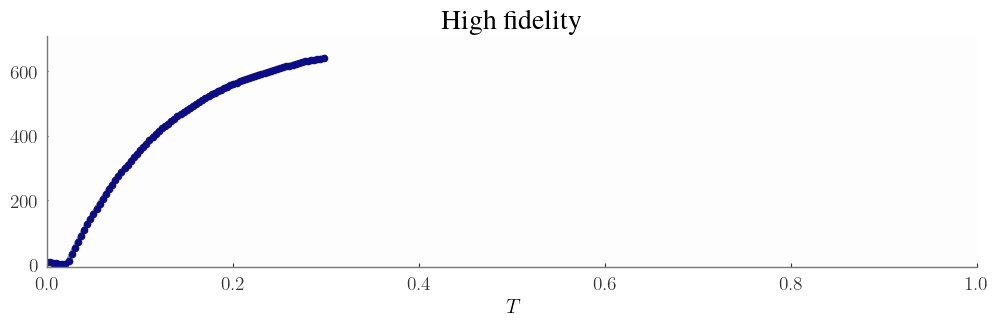

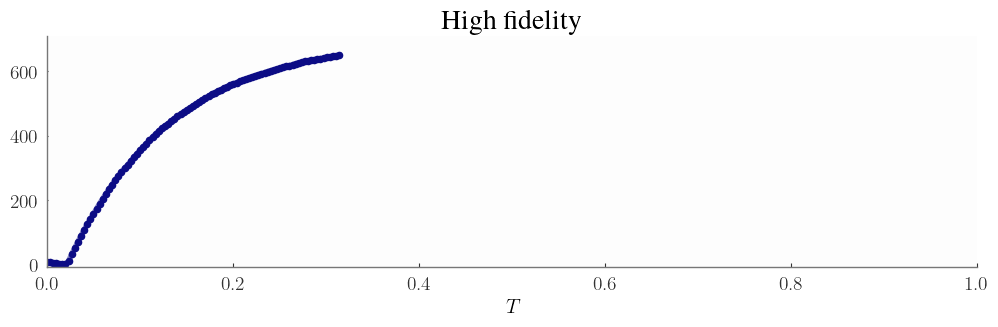

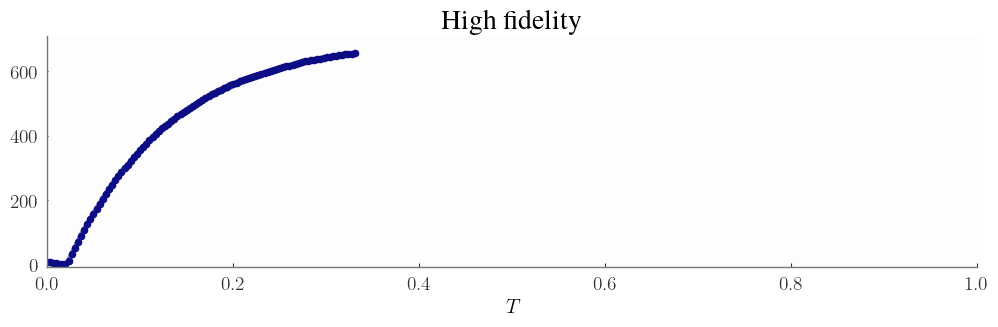

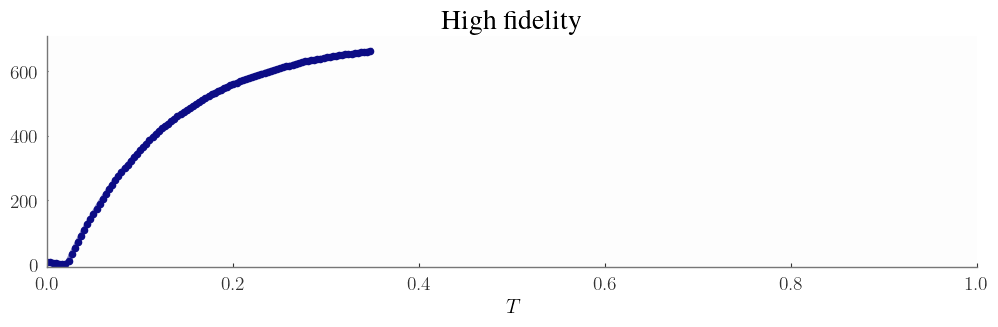

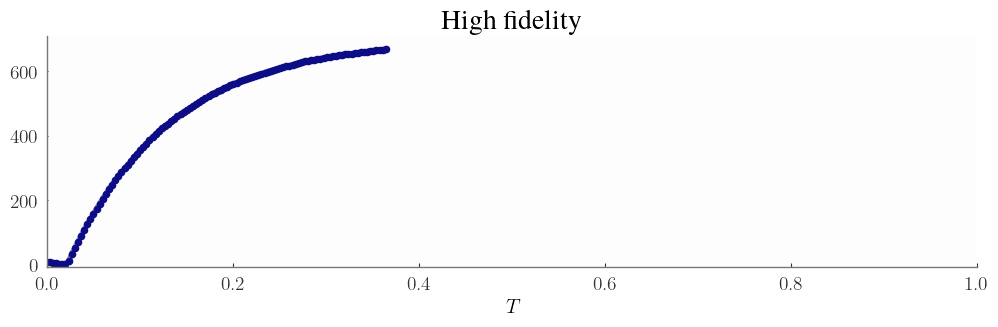

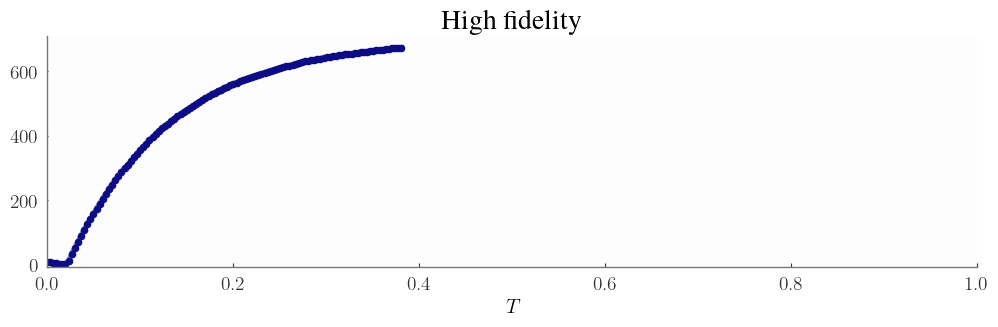

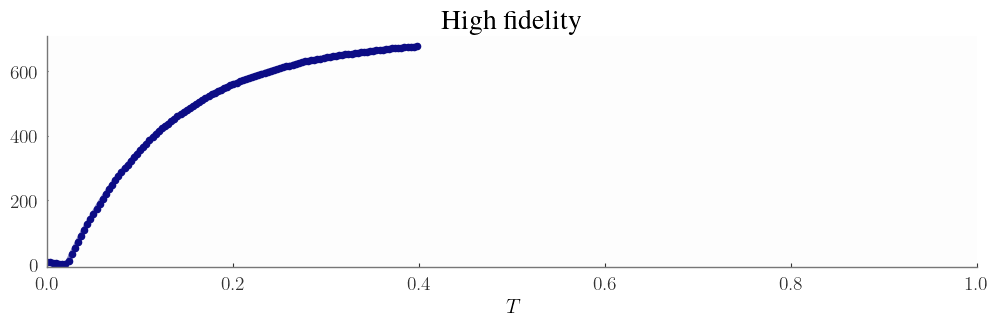

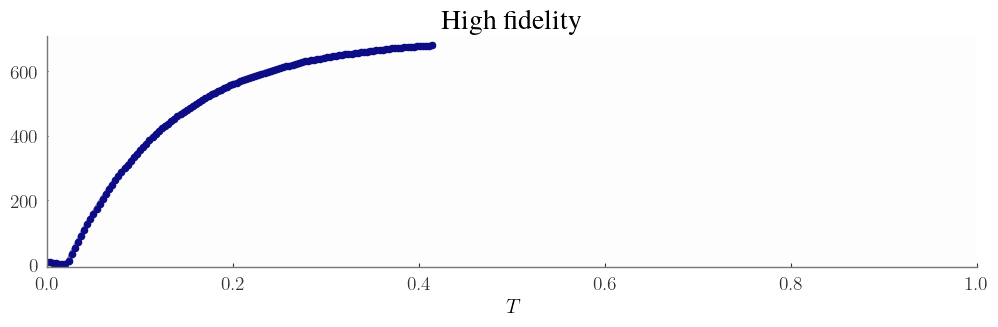

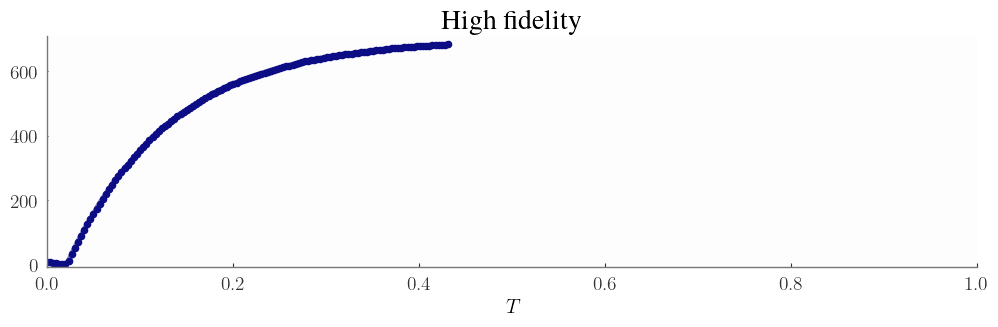

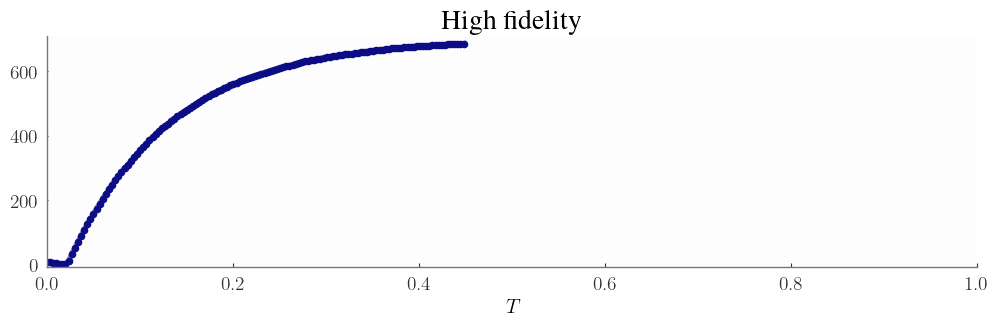

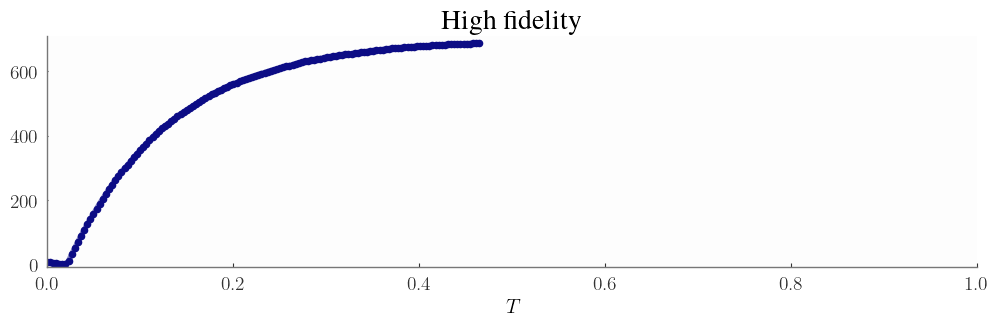

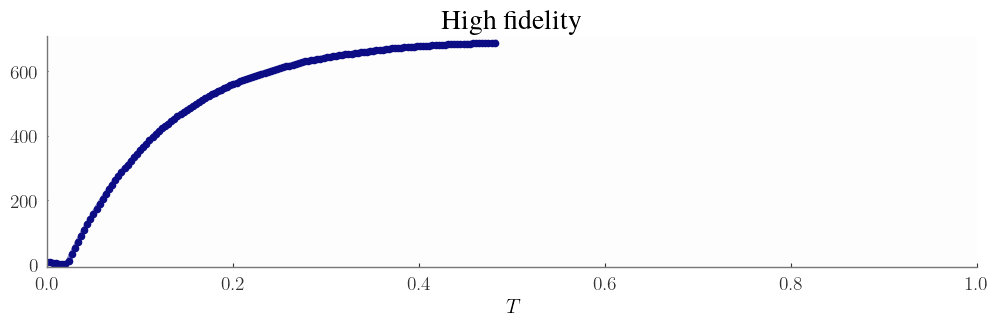

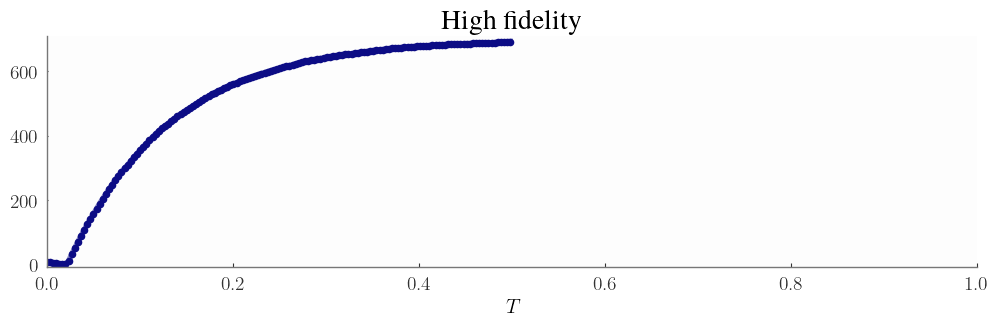

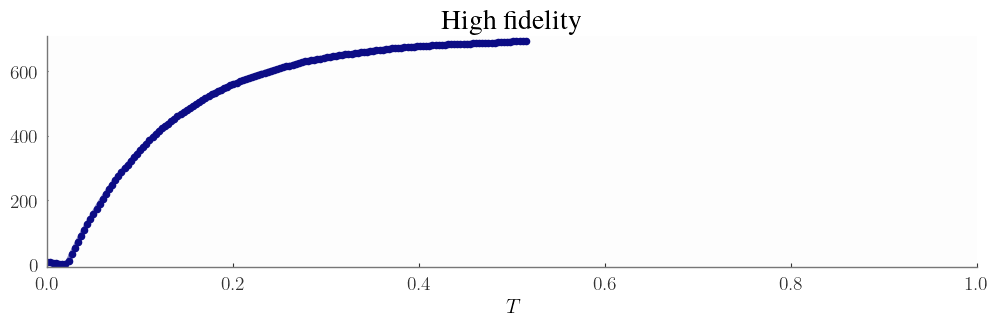

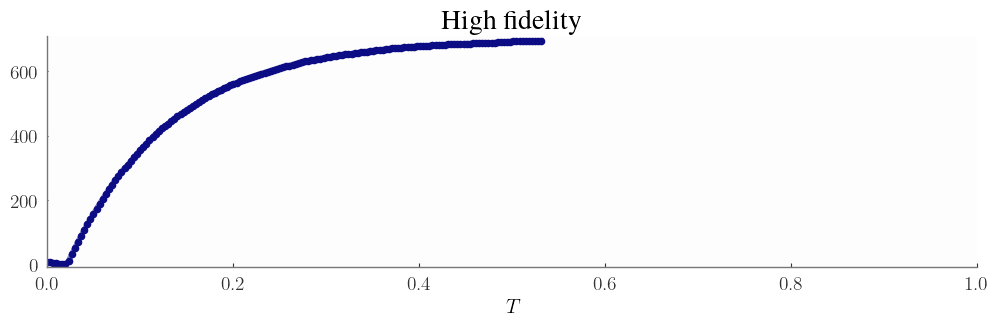

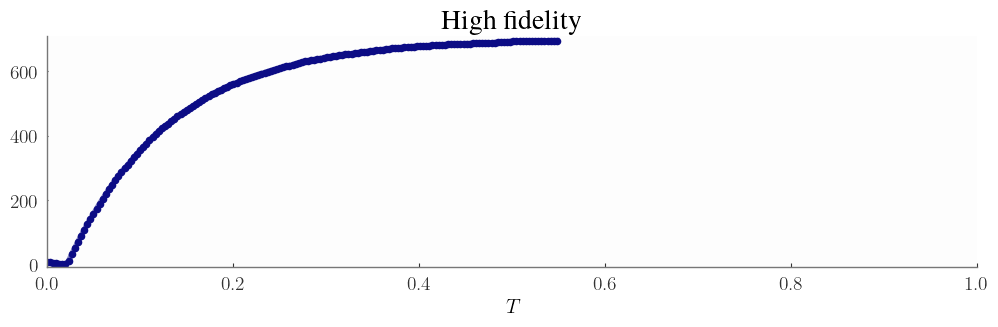

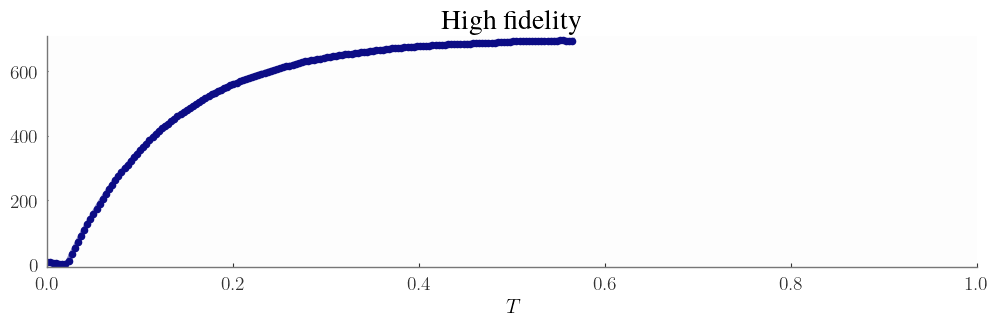

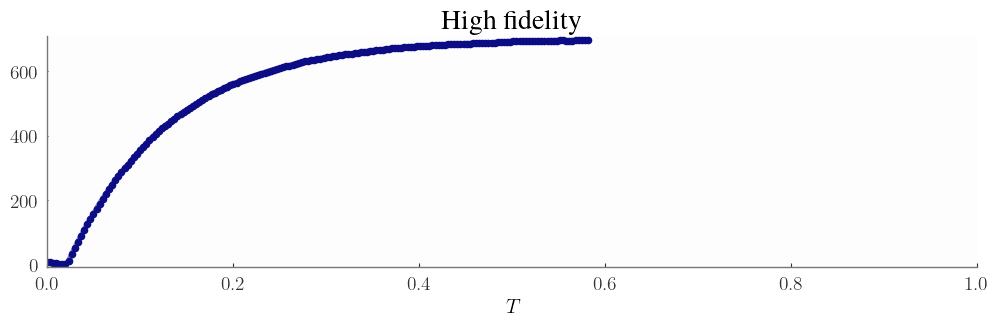

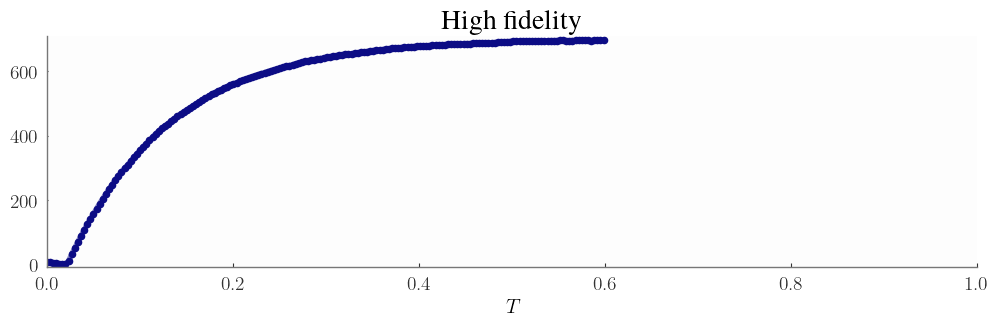

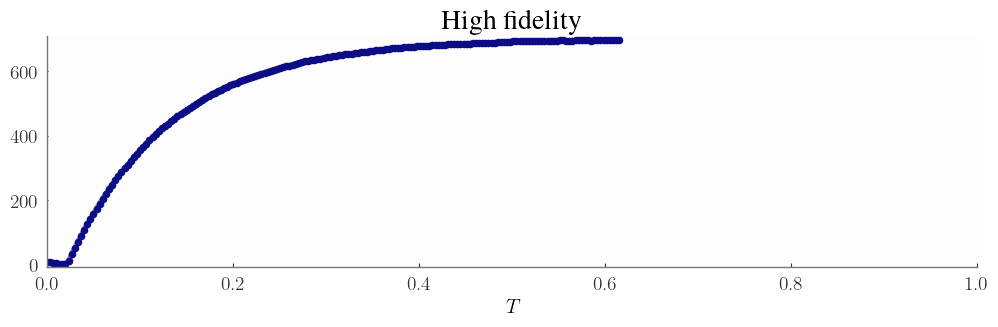

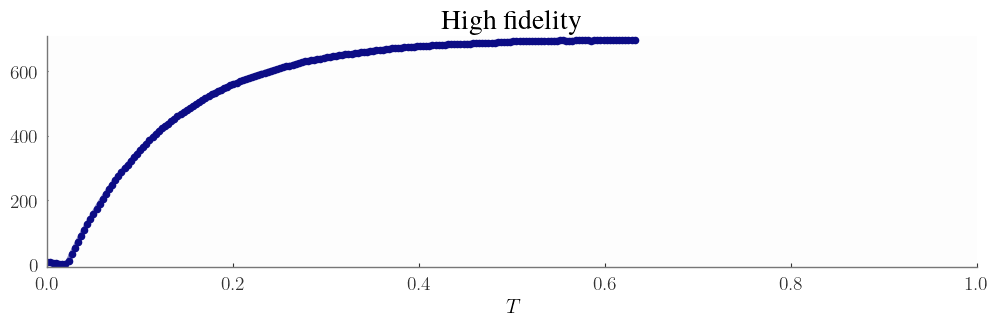

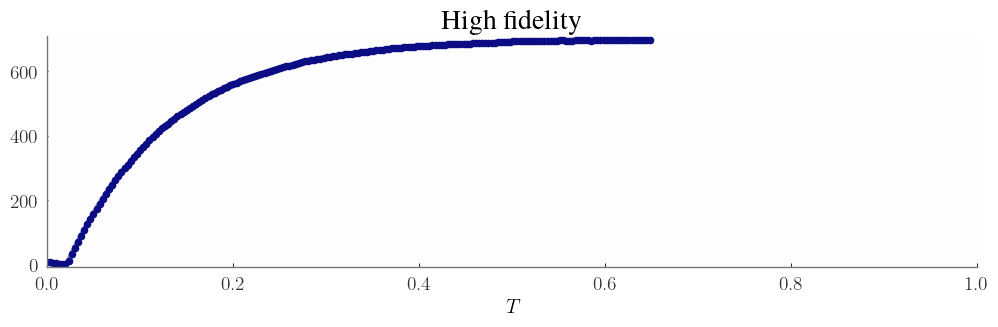

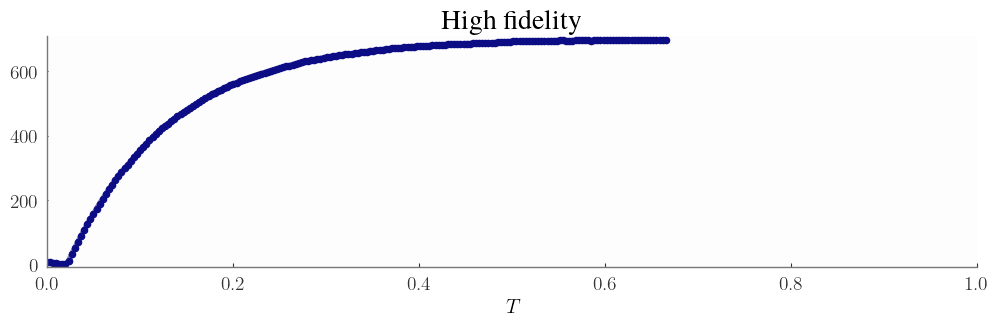

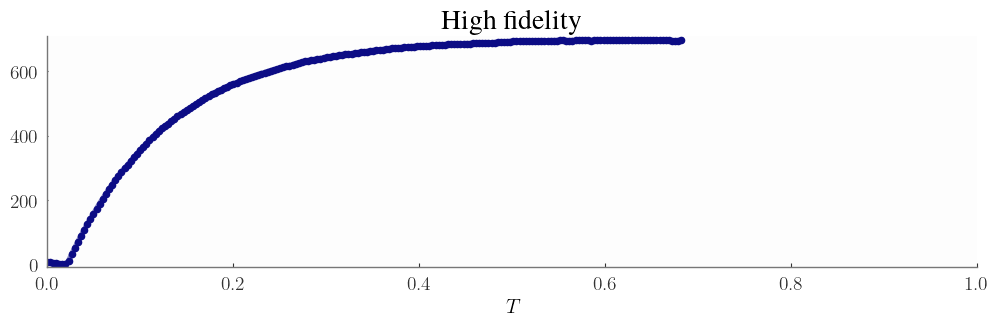

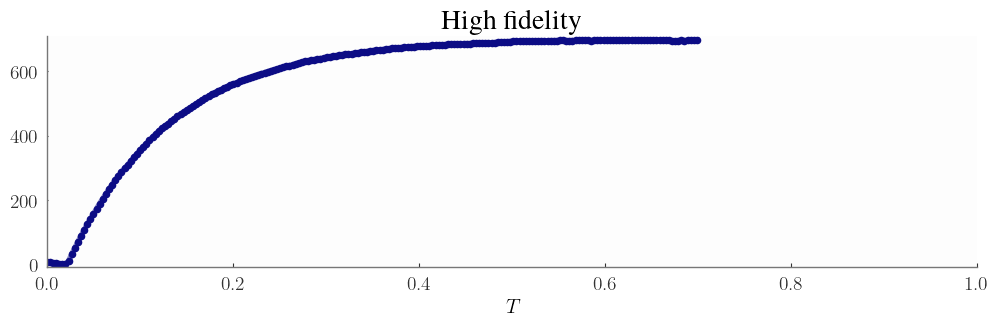

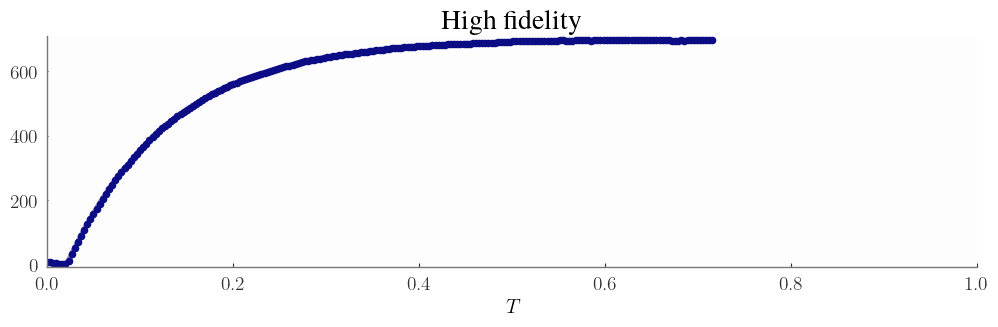

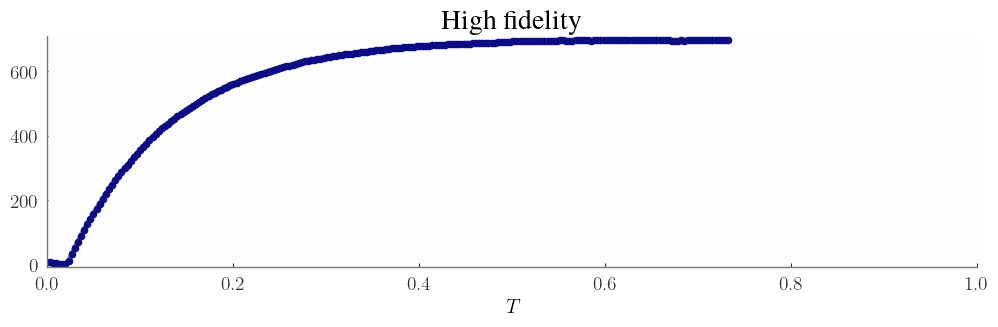

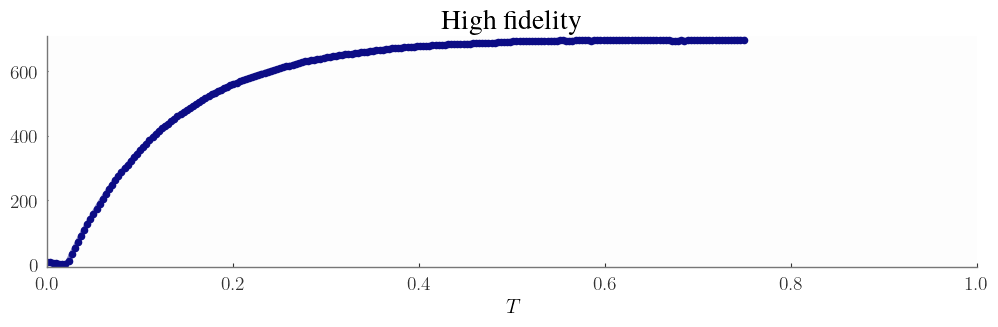

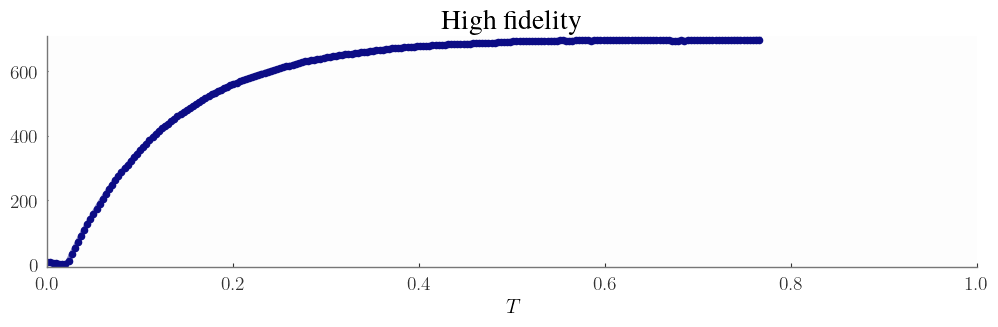

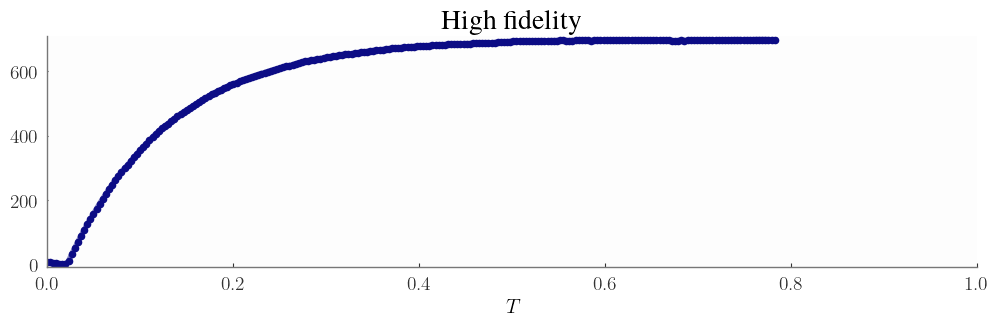

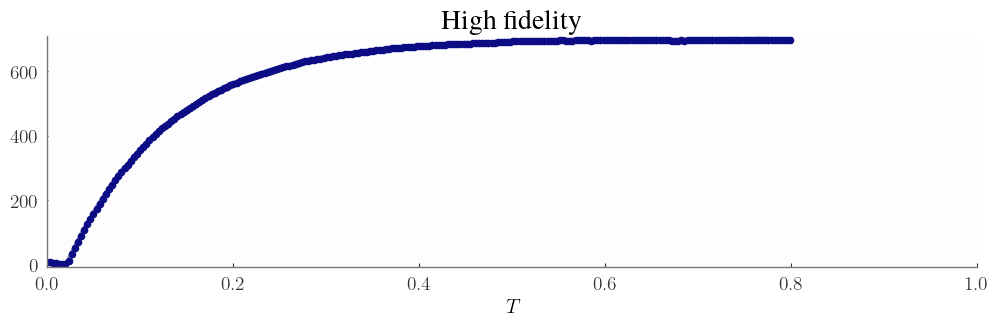

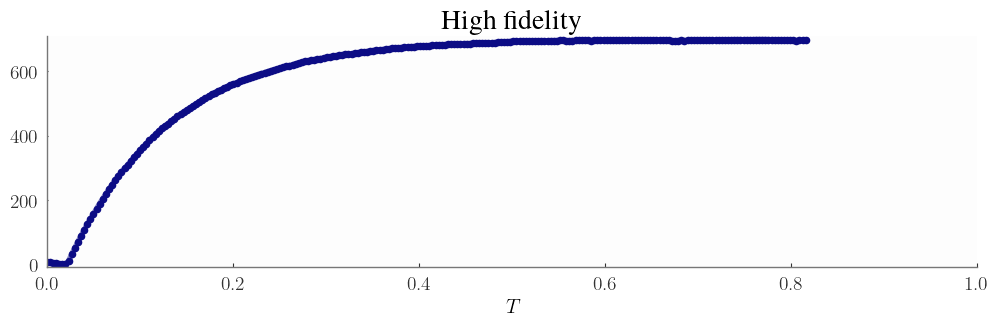

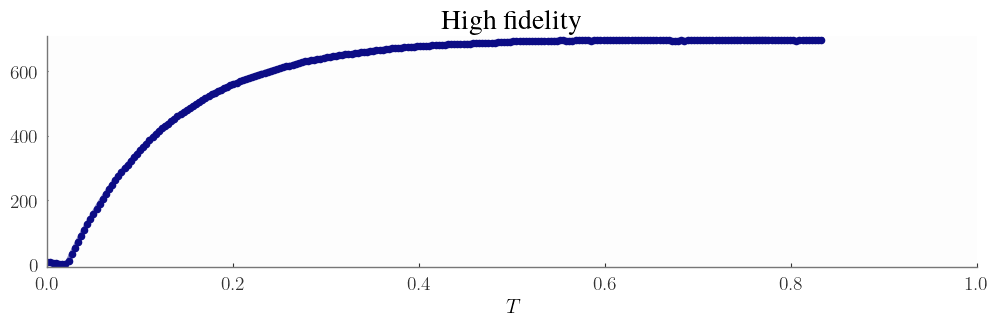

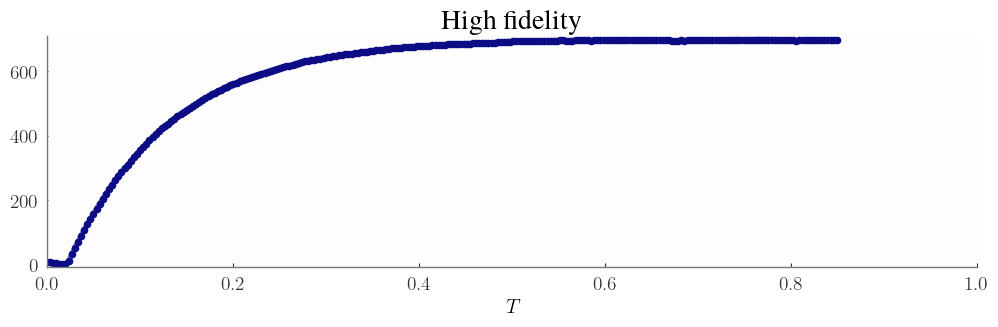

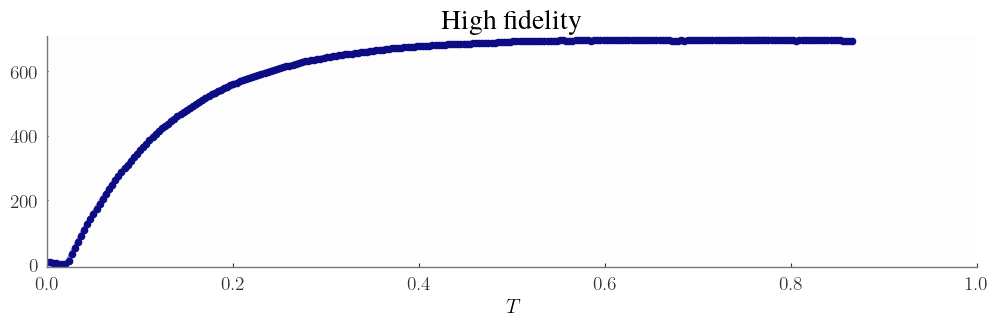

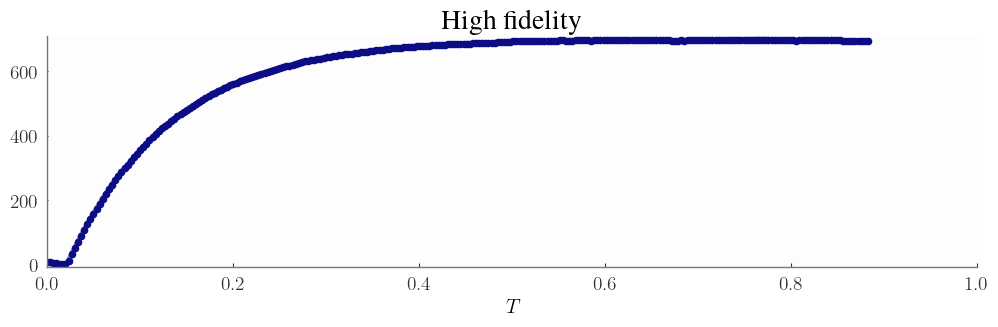

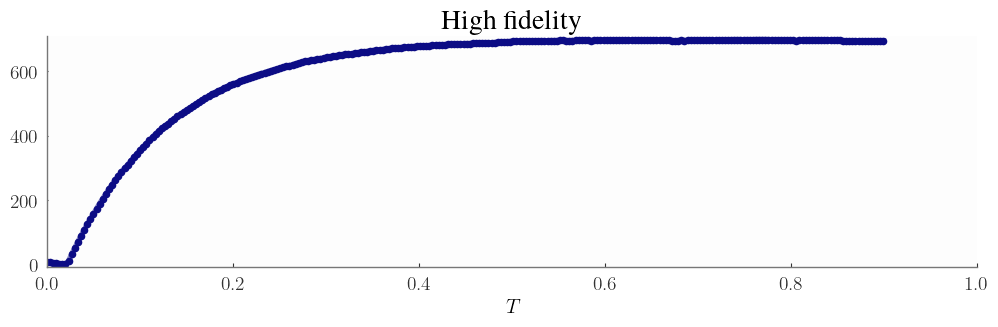

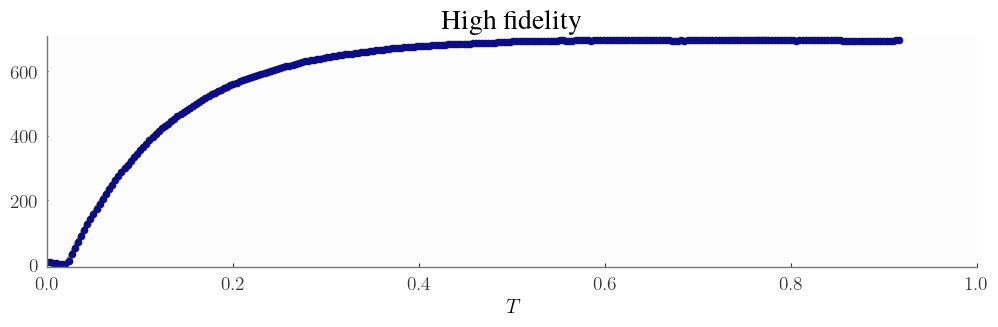

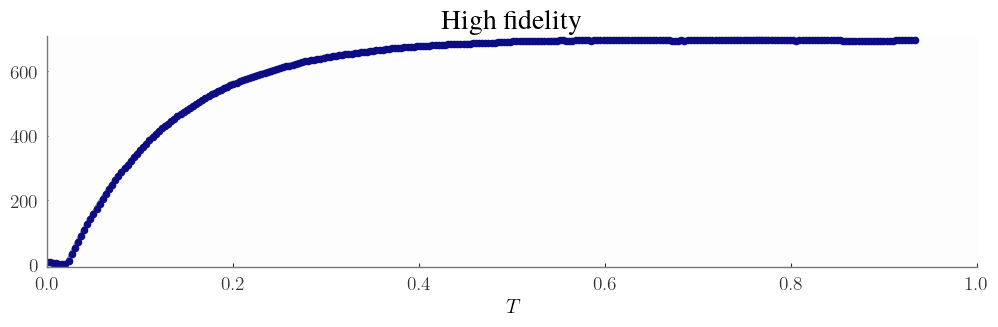

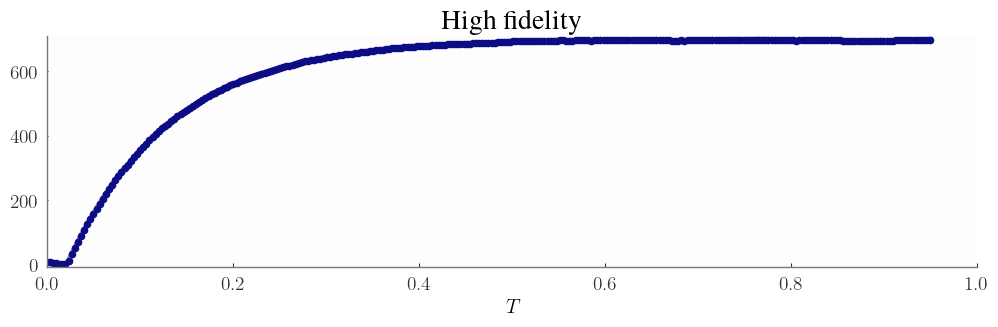

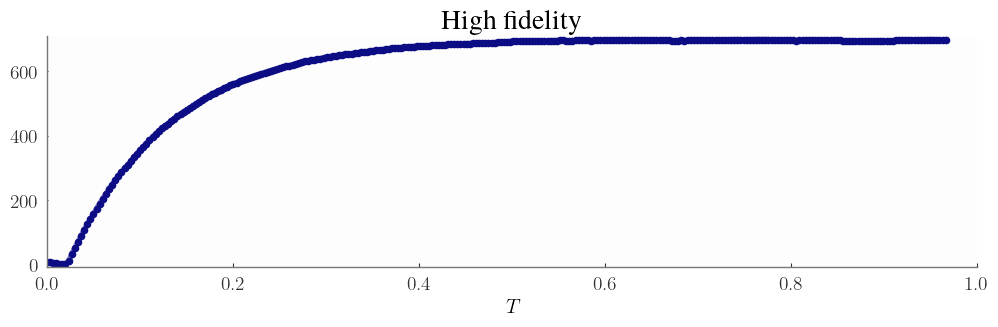

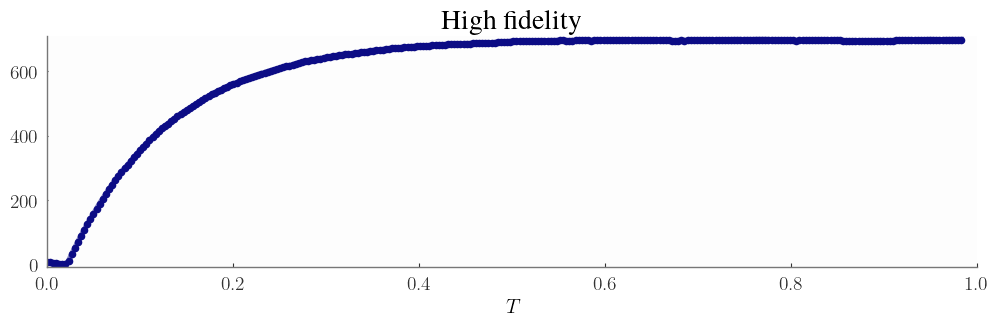

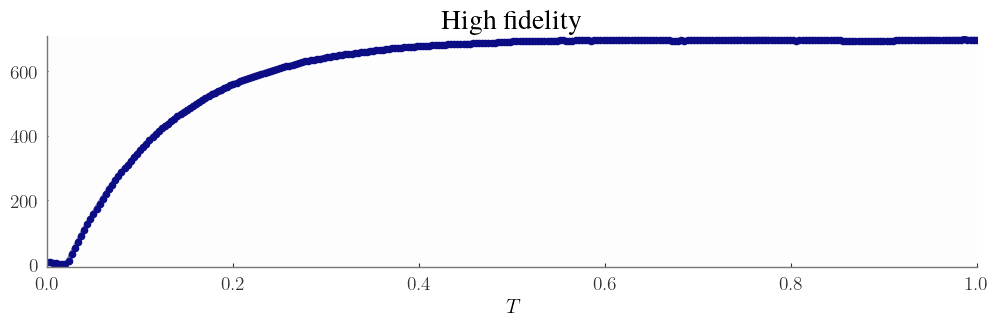

In [206]:
i = 0
for T in T_list:
    for t in range(0, T + 1, 5):
        fig, ax = plot_for_gif(T = T, t = t)
        # path = os.path.join(gif_dir, f'{i}_toggle_switch_{T}_{t}.pdf')
        path = os.path.join(gif_dir, f'ts_{str(i).zfill(3)}.png')
        fig.savefig(path, dpi = 300, bbox_inches = 'tight')
        i += 1

In [ ]:
f = plot_for_gif(T = 50, t = 300)